# Spectral Analysis pipeline using a CNN from Bjerrum et al. 2017

In this notebook I try to reproduce the spectral analysis pipeline that was proposed in Bjerrum et al 2017 ( [paper here](https://arxiv.org/abs/1710.01927) ). The data and some preprocessing functions (in ChemUtils.py) were borrowed from the author's [Deep-Chemometrics GitHub](https://github.com/EBjerrum/Deep-Chemometrics). I'm also including an additional dataset details (data_details.zip) file for those how are interested (it was copied from the data's original web source). To better understand the workflow here, please check their paper.

This is a regression problem. Basically we use the spectra information (our X) to predict the ammount of some chemical compound (our Y). The error metrics obtained with an "optimal" PLS model is used as a baseline for comparisons with the CNN model. Some analysis functions (e.g. PLS optimization, etc.) where adapted from this awesome spectroscopy blog, [nirpyresearch](https://nirpyresearch.com/).

From the several pre-processed dadasets options that Bjerrum et al 2017 use, I implement only two here for simplification pursposes. The main objective here is to reproduce the training methodology and some of the results they presented in their 2017 paper in order to validate my implementation of their analysis pipeline. In principle, the results should be possible to replicate within the practical uncertainties associated with the dataset train/test split and shuffle and the stochastic nature of neural network training process. That being said, if you run this notebook on your machine you might get slightly different results as well.
The long term goal is to apply this CNN model/methodology on [CEOT@UAlg](https://www.ceot.ualg.pt/research-groups/sensing-and-biology) fruit spectral datasets, for a comparasion with other Machine Learning models benchmarked at [Passos, D. et al 2019 (Sensors)](https://www.mdpi.com/1424-8220/19/23/5165).

#### Practical notes
> This notebook was devolped for personal academic research purposes. Implementation errors might exist! You can use and adapt its content to your own projects, but if you do so, please be kind and cite the authors.

> Main software setup used: python 3.6, tensorflow 2.1, scikitlearn, scipy, GpyOpt, optuna...

> The timestamps of the cells (that can be used as a measure of computation time) where obtained by running this notebook on a Intel i7-4770 CPU + Nvidia GeForce RTS 2080 Ti.

For comments/suggestions please contact me: [Dário Passos](https://www.researchgate.net/profile/Dario_Passos)

###  Quick Summary 
#### Metrics based on training on train set 1 and predicting on test set 2   (*run 6/10/2020*).
NOTE: The results found in the last cells of this version of the notebook, might be slighlty different due to various tests of the CNN model implementation (related with the use of padding='same' or padding='valid' in the Conv1d layers).

**PLS MODEL:** <br>

GS dataset <br>
> PLS comps = 6 <br>
R2  	(Train/Test) = 	0.973	/  0.944 <br>
RMSE  	(Train/Test) = 	2.767 	/  3.816<br>
Huber 	(Train/Test) = 	1.506	/  2.343<br>

 
EMSC+GS dataset<br> 
>PLS comps = 10 <br>
R2  	(Train/Test) = 	0.985	/  0.912 <br>
RMSE  	(Train/Test) = 	2.097 	/  4.775 <br>
Huber 	(Train/Test) = 	1.043	/  3.244 <br>


**B. Optimized CNN model** <br>

GS dataset <br>
> Optimized Parameters:<br>
	DenseN:	168.0<br>
	DropoutR:	0.5<br>
	C1_K:	2.0<br>
	C1_S:	244.0<br>
	C2_K:	46.0<br>
	C2_S:	49.0<br>
optimized huber loss on internal validation set: 1.004680363591854 <br>
R2  	(Train/Test) = 	0.983	/  0.963<br>
RMSE  	(Train/Test) = 	2.219 	/  3.108<br>
Huber 	(Train/Test) = 	1.098	/  1.772<br>

EMSC + GS dataset <br>
> Optimized Parameters:<br>
	DenseN:	294.0 <br>
	DropoutR:	0.1846 <br>
	C1_K:	20.0 <br>
	C1_S:	247.0 <br>
	C2_K:	57.0 <br>
	C2_S:	87.0 <br>
optimized huber loss: 1.0346314002035393 <br>
R2  	(Train/Test) = 	0.984	/  0.980 <br>
RMSE  	(Train/Test) = 	2.112 	/  2.261 <br>
Huber 	(Train/Test) = 	1.015	/  1.220 <br>

## Import libs and dataset

The original dataset used by Bjerrum et al 2017, can be downloaded directly from http://www.eigenvector.com/data/tablets/index.html and should be placed in the Dataset folder.

In [1]:
import scipy.io as sio
import scipy
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from sys import stdout
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns 
from scipy.signal import savgol_filter
from scipy.optimize import minimize_scalar
import scipy.linalg as linalg
from cycler import cycler

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold , \
    cross_validate, StratifiedKFold

from ChemUtils import GlobalStandardScaler, EmscScaler

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, Reshape#, MaxPooling1D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback
# from livelossplot.tf_keras import PlotLossesCallback
# from livelossplot.keras import PlotLossesCallback


## Define random seeds ir order to maintain reproducible results through multiple testing phases
def set_reproducible():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)
    
set_reproducible()

Read the data (matlab format) using the scipy.io module (source: [Deep-Chemometrics GitHub](https://github.com/EBjerrum/Deep-Chemometrics) )

In [92]:
def get_xY(filename, maxx=600):
    
    #sio.whosmat(filename)

    matcontents = sio.loadmat(filename)
    keys = list(matcontents.keys())
    for key in list(keys):
        if key[0] == '_':
            keys.remove(key)
            
    keys.sort()
            
    d = {}            
    for key in keys:
        data = matcontents[key][0][0]
        if key[-1] == "Y":
            Ydata = data[5] 
            d[key] = Ydata
        else:
            xdata = data[5][:,:maxx]
            d[key] = xdata
            d["axisscale"]= data[7][1][0][0][:maxx].astype(np.float)
                    
    return d

## Assuming file is in the same folder of this notebook!
filename = 'nir_shootout_2002.mat'
dataset = get_xY(filename)

The dataset contains measurements of chemical compounds in tablets that were obtained using two different spectrometers (1 and 2). The data from each spectrometer is already separated into train, test, validate sub-sets **but we will not use this split.**

In [3]:
dataset.keys()

dict_keys(['calibrate_1', 'axisscale', 'calibrate_2', 'calibrate_Y', 'test_1', 'test_2', 'test_Y', 'validate_1', 'validate_2', 'validate_Y'])

In [5]:
for name,val in zip(dataset.keys(),dataset.values()):
    print('Shape of {} = {}'.format(name,val.shape))

Shape of calibrate_1 = (155, 600)
Shape of axisscale = (600,)
Shape of calibrate_2 = (155, 600)
Shape of calibrate_Y = (155, 3)
Shape of test_1 = (460, 600)
Shape of test_2 = (460, 600)
Shape of test_Y = (460, 3)
Shape of validate_1 = (40, 600)
Shape of validate_2 = (40, 600)
Shape of validate_Y = (40, 3)


The notation for the names of the original datasets is a bit out of context since the dataset was introduced as a data science challeng on cross-calibration between 2 different spectrometers. Therefore, we can pool the data (per instrument) and partition it our way. This shuffle and data partition makes the datasets used here different from those used in the original paper. 

In [6]:
## Concatenate all data subsets into two datasets (inst1 and inst2) and shuflle (use same random_state 
## to ensure that X and Y are shuffle the same way)

## Instrument 1 spectra
X1=shuffle(np.concatenate([dataset['test_1'],dataset['calibrate_1'],dataset['validate_1']]),random_state=42)
## Instrument 2 spectra
X2=shuffle(np.concatenate([dataset['test_2'],dataset['calibrate_2'],dataset['validate_2']]),random_state=42)

## Assay values (y, labels)
Y=shuffle(np.concatenate([dataset['test_Y'],dataset['calibrate_Y'],dataset['validate_Y']]),random_state=42)
## wavelenght
l=dataset['axisscale'].reshape(-1,1)

print(X1.shape)
print(X1.shape)
print(Y.shape)                                                    
print(l.shape)

(655, 600)
(655, 600)
(655, 3)
(600, 1)


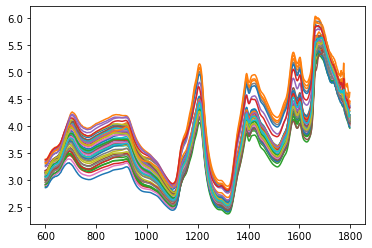

In [34]:
## Visual check: plotting 50 spectra
_= plt.plot(l,X2[0:50].T)

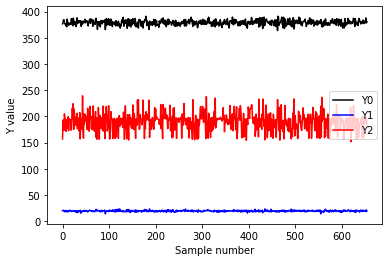

In [8]:
## Visual check
plt.plot(Y[:,0],'k',label='Y0')
plt.plot(Y[:,1],'b',label='Y1')
plt.plot(Y[:,2],'r',label='Y2')
plt.xlabel('Sample number')
plt.ylabel('Y value')
plt.legend()

In this notebook we will try to predict the red curve, i.e., <code>Y[:,2]</code>

## Outlier removal 

Now that we have our dataset defined, the first thing to according to the paper is to find and remove outliers.

THEORY NOTE on loss functions: *"You’ll want to use the Huber loss any time you feel that you need a balance between giving outliers some weight, but not too much. For cases where outliers are very important to you, use the MSE! For cases where you don’t care at all about the outliers, use the MAE!"* ( [web source](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3))

In [30]:
## Help functions to help tune the PLS models, find outliers, etc...
## TODO: Group these 3 functions into just one function with multiple choice parameters

## Define the Huber distance (source DeepChemometrics)
def huber(y_true, y_pred, delta=1.0):
    y_true = y_true.reshape(-1,1)
    y_pred = y_pred.reshape(-1,1)
    return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

## Create a huber loss scorer for cross_val_score()
huber_score=make_scorer(huber)


## Function to help find the best number of components of the PLS based on 10 CV Huber Loss
def pls_data_optimization(X, Y, plot_components=False):
    """
    This function finds the optimal number of PLS components (up to 40) that best models the data
    based on huber loss and 10 CV
    X - The training data X
    Y - The training data Y
    plot_components - Plot the model's optimization and optimized model
    """
    #Run PLS including a variable number of components, up to 40,  and calculate mean of 10 CV huber loss
    cv_huber=[]
    component = np.arange(1, 40)
    for i in component:
        pls = PLSRegression(n_components=i)
        cv_score=cross_val_score(pls, X, Y, cv=KFold(10, shuffle = True),\
                        n_jobs=-1, scoring=huber_score)
        cv_huber.append(np.mean(cv_score))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum
    cv_hubermin = np.argmin(cv_huber)
    print("Suggested number of components based in Mean of 10 CV huber loss: ", cv_hubermin+1)
    print('Minimum found in Mean of 10 CV huber loss: {}'.format(np.min(cv_huber)))
    stdout.write("\n")
 
    # Define PLS with suggested number of components and fit train data
    pls = PLSRegression(n_components=cv_hubermin+1)
    pls.fit(X, Y)
    
    # Get predictions for calibration(train) and validation(test) sets
    Y_pred = pls.predict(X) 
    
    # Calculate and print scores for validation set
    R2_p = r2_score(Y, Y_pred)
    mse_p = mean_squared_error(Y, Y_pred)
    hub_p = huber(Y, Y_pred)
    sep = np.std(Y_pred[:,0]-Y)
    rmse_p = np.sqrt(mse_p)
    
    print('\nError metrics for test set:')
    print('R2: %5.3f'  % R2_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
 
    # Plot regression and PLS LV search
    rangey = max(Y) - min(Y)
    rangex = max(Y_pred) - min(Y_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        ax1=plt.subplot(1,2,1)
        ax1.plot(component, np.array(cv_huber), '-v', color = 'blue', mfc='blue')
        ax1.plot(component[cv_hubermin], np.array(cv_huber)[cv_hubermin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel('Mean od 10 CV Huber loss')
        plt.title('# PLS components')
        plt.xlim(left=-1)

        z = np.polyfit(np.ravel(Y), np.ravel(Y_pred), 1)        
        ax2 = plt.subplot(1,2,2, aspect=1)
        ax2.scatter(Y,Y_pred,c='k',s=2)
        ax2.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y, Y, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.1*rangey, 'R$^{2}=$ %5.3f'  % R2_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y)-0.2*rangey, 'Huber loss: %5.3f' % hub_p)
        plt.show()    
    return 




## Function to help find the best number of components of the PLS based in the MSE or Huber Loss
def pls_prediction(X_calib, Y_calib, X_valid, Y_valid, loss='huber', plot_components=False):
    """
    This function finds the optimal number of PLS components (up to 40) that best models the data
    Here we compute some internal metrics based on MSE and Huber loss
    X_calib - The training data X
    Y_calib - The training data Y
    X_valid - The validation or test data X
    Y_valid - The validation or test data Y
    loss - Choose the error metric of the optimization. Options are 'mse' and 'huber'(default)
    plot_components - Plot the model's optimization and optimized model
    """
    #Run PLS including a variable number of components, up to 40,  and calculate MSE and huber loss
    mse = []
    hub = []
    component = np.arange(1, 40)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Fit
        pls.fit(X_calib, Y_calib)
        # Prediction
        Y_pred = pls.predict(X_valid)
        mse_p = mean_squared_error(Y_valid, Y_pred)
        hub_p = huber(Y_valid,Y_pred)
        mse.append(mse_p)
        hub.append(hub_p)
 
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    hubmin = np.argmin(hub)
    print("Suggested number of components based in MSE: ", msemin+1)
    print("Suggested number of components based in huber: ", hubmin+1)
    stdout.write("\n")
 
    # Define PLS with suggested number of components and fit train data
    if loss=='mse':
        pls = PLSRegression(n_components=msemin+1)
        loss_name = 'MSE'
    else:
        pls = PLSRegression(n_components=hubmin+1)
        loss_name='Huber loss'
    pls.fit(X_calib, Y_calib)
    
    # Get predictions for calibration(train) and validation(test) sets
    Y_calib_pred = pls.predict(X_calib) 
    Y_valid_pred = pls.predict(X_valid) 
    
    # Calculate and print scores for validation set
    R2_p = r2_score(Y_valid, Y_valid_pred)
    mse_p = mean_squared_error(Y_valid, Y_valid_pred)
    hub_p = huber(Y_valid, Y_valid_pred)
    sep = np.std(Y_valid_pred[:,0]-Y_valid)
    rmse_p = np.sqrt(mse_p)
    # rpd = np.std(Y_valid)/sep
    # bias = np.mean(Y_pred[:,0]-Y_valid)
    
    print('\nError metrics for test set:')
    print('R2: %5.3f'  % R2_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
    # print('RPD: %5.3f' % rpd)
    # print('Bias: %5.3f' %  bias)
 
    # Plot regression and figures of merit
    rangey = max(Y_valid) - min(Y_valid)
    rangex = max(Y_valid_pred) - min(Y_valid_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        ax1=plt.subplot(1,2,1)
        if loss=='mse':
            ax1.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            ax1.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
        else:
            ax1.plot(component, np.array(hub), '-v', color = 'blue', mfc='blue')
            ax1.plot(component[hubmin], np.array(hub)[hubmin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel(loss_name)
        plt.title('# PLS components')
        plt.xlim(left=-1)

        z = np.polyfit(np.ravel(Y_valid), np.ravel(Y_valid_pred), 1)        
        ax2 = plt.subplot(1,2,2, aspect=1)
        ax2.scatter(Y_calib,Y_calib_pred,c='k',s=2)
        ax2.scatter(Y_valid,Y_valid_pred,c='r',s=2)
        ax2.plot(Y_valid, z[1]+z[0]*Y_valid, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y_valid, Y_valid, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.1*rangey, 'R$^{2}=$ %5.3f'  % R2_p)
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_valid_pred)+0.02*rangex, max(Y_valid)-0.2*rangey, 'Huber loss: %5.3f' % hub_p)
        # plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.25*rangey, 'RPD: %5.3f' % rpd)
        # plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.3*rangey, 'Bias: %5.3f' %  bias)
        plt.show()    
    return Y_calib, Y_valid, Y_valid_pred, Y_calib_pred   




## Function that computes the PLS model and metrics for a train - test set pair and a given number of LV
def pls_prediction2(X_calib, Y_calib, X_valid, Y_valid, components, plot_components=False):
    """
    Very similar to the two previous functions but without the optimization part
    This function is simply used to compute the PLS model and the error metrics.
    NOTE: For the final error metrics we should use the benchmark() because we need
    take into consideration the unscaled version of the data.
    """
    i=components
    pls = PLSRegression(n_components=i)
    # Fit
    pls.fit(X_calib, Y_calib)
    # Prediction
    Y_pred = pls.predict(X_valid)
         
    # Calculate and print scores
    score_p = r2_score(Y_valid, Y_pred)
    mse_p = mean_squared_error(Y_valid, Y_pred)
    hub_p = huber(Y_valid, Y_pred)
    rmse_p = np.sqrt(mse_p)
    y_err = Y_valid-Y_pred
    sep = np.std(Y_pred[:,0]-Y_valid)
  
    print('R2: %5.3f'  % score_p)
#    print('Mean Squared Error (MSE): %5.3f' % mse_p)
    print('Root Mean Squared Error (RMSE): %5.3f' % rmse_p)
    print('Huber loss (huber): %5.3f' % hub_p)
    print('Standard Error Prediction (SEP): %5.3f' % sep)
    # print('RPD: %5.3f' % rpd)
    # print('Bias: %5.3f' %  bias)
 
    # Plot regression and figures of merit
    rangey = max(Y_valid) - min(Y_valid)
    rangex = max(Y_pred) - min(Y_pred)
 
    if plot_components is True:
        plt.figure(figsize=(15,5))
        z = np.polyfit(np.ravel(Y_valid), np.ravel(Y_pred), 1)
        ax2 = plt.subplot(aspect=1)
#         ax2.fill_between(Y_cal, y_est-y_err, y np.ravel(z[1]+z[0]*np.arange(150,240))-2.5*sep, facecolor='red', alpha=0.5)
        ax2.scatter(Y_valid,Y_pred,c='r',s=2)
        ax2.plot(Y_valid, z[1]+z[0]*Y_valid, c='blue', linewidth=2,label='linear fit')
        ax2.plot(Y_valid, Y_valid, color='orange', linewidth=1.5, label='y=x')
        plt.ylabel('Predicted')
        plt.xlabel('Measured')
        plt.title('Prediction from PLS')
        plt.legend(loc=4)
 
        # Print the scores on the plot
        plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.15*rangey, 'RMSE: %5.3f' % rmse_p)
        plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.2*rangey, 'Huber loss: %5.3f' % hub_p)
        # plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.25*rangey, 'RPD: %5.3f' % rpd)
        # plt.text(min(Y_pred)+0.02*rangex, max(Y_valid)-0.3*rangey, 'Bias: %5.3f' %  bias)
        plt.show() 
        
    return Y_calib, Y_pred, pls


## Function to benchmark model error metrics (adapted from DeepChemometrics)
## This function computes error between the predictions made by a "model" and the original data.
def benchmark(x_train,y_train,x_test, y_test, model):
    """
    Think of this as:
    model(x_train, y_train) -> trained_model
    predicted_y = trained_model(x_test)
    error_metric = compute_error_between(y_test, predicted_y)
    """
    ## ORIGINAL 
#     rmse = np.mean((y_train - model.predict(X_train).reshape(y_train.shape))**2)**0.5
#     rmse_test = np.mean((y_test - model.predict(X_test).reshape(y_test.shape))**2)**0.5
#     hub = huber(y_train, model.predict(X_train))
#     hub_test = huber(y_test, model.predict(X_test))
    ######
    ## CONVERT Y values to initial scale before computing error metrics 
    y_train_true=yscaler.inverse_transform(y_train)
    y_test_true=yscaler.inverse_transform(y_test)
    y_train_pred=yscaler.inverse_transform(model.predict(x_train)).reshape(y_train_true.shape)
    y_test_pred=yscaler.inverse_transform(model.predict(x_test)).reshape(y_test_true.shape)
    
    ## Compute error metrics
    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    R2_train= r2_score(y_train_true, y_train_pred)
    R2_test= r2_score(y_test_true, y_test_pred)
    hub_train = huber(y_train_true, y_train_pred)
    hub_test = huber(y_test_true, y_test_pred)
    
    ## Print stuff
    print('\n\n*********** Benchmark results *********** \n')
    print("R2  \t(Train/Test) = \t{:.3f}\t/  {:.3f}".format(R2_train, R2_test))    
    print("RMSE  \t(Train/Test) = \t{:.3f} \t/  {:.3f}".format(rmse_train, rmse_test))
    print ("Huber \t(Train/Test) = \t{:.3f}\t/  {:.3f}".format(hub_train, hub_test))


We first run the pls_data_optimization() to find the number of PLS latent variables that best model the full dataset. This will be used for the outlier removal task on the full datasets 1 and 2. This is done by sampling the datasets using a 10 fold cross-validation (CV) procedure.

100% completed
Suggested number of components based in Mean of 10 CV huber loss:  9
Minimum found in Mean of 10 CV huber loss: 1.6249559454826994


Error metrics for test set:
R2: 0.950
Root Mean Squared Error (RMSE): 3.831
Huber loss (huber): 1.523
Standard Error Prediction (SEP): 3.831


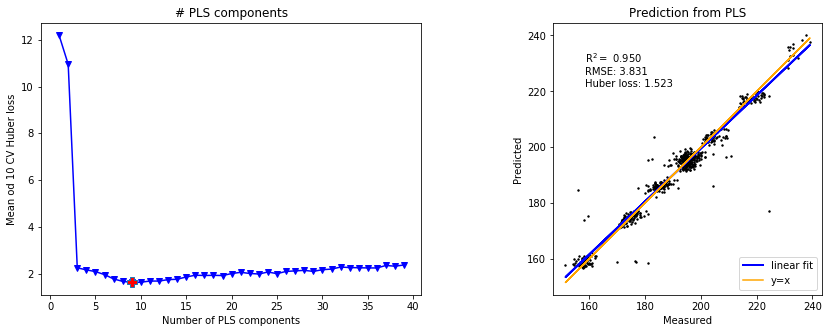

In [9]:
## Find the number of PLS LV that best simulates dataset 1
pls_data_optimization(X1, Y[:,2],plot_components=True)

100% completed
Suggested number of components based in Mean of 10 CV huber loss:  15
Minimum found in Mean of 10 CV huber loss: 1.8751193699653785


Error metrics for test set:
R2: 0.956
Root Mean Squared Error (RMSE): 3.582
Huber loss (huber): 1.539
Standard Error Prediction (SEP): 3.582


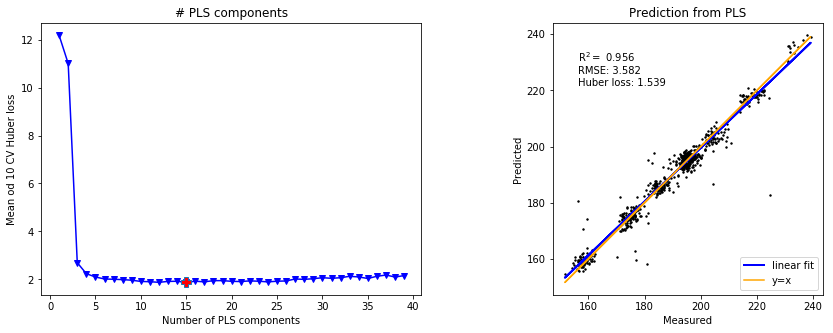

In [32]:
## Find the number of PLS LV that best simulate dataset 2
pls_data_optimization(X2, Y[:,2],plot_components=True)

Optimal PLS model applyed to full dataset from instrument 1
R2: 0.950
Root Mean Squared Error (RMSE): 3.831
Huber loss (huber): 1.523
Standard Error Prediction (SEP): 3.831


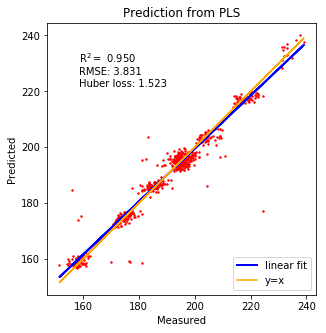

optimal PLS model applyed to full dataset from instrument 2
R2: 0.956
Root Mean Squared Error (RMSE): 3.582
Huber loss (huber): 1.539
Standard Error Prediction (SEP): 3.582


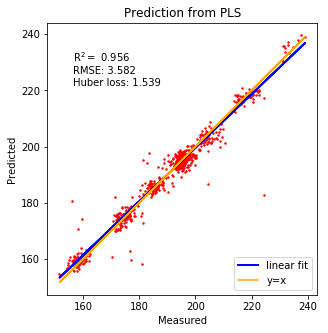

In [10]:
## Applying the PLS model with the found number of latent variables to the full datasets and compute error metrics

## Visualize the prediction of the PLS model and get the predicted values
print('Optimal PLS model applyed to full dataset from instrument 1')    
y1, ypred1, _= pls_prediction2(X1,Y[:,2], X1 , Y[:,2],components=9,plot_components=True)     
print('optimal PLS model applyed to full dataset from instrument 2')     
y2, ypred2, _= pls_prediction2(X2,Y[:,2], X2 , Y[:,2],components=15,plot_components=True)     


Compute the absolute prediction error and find the index of the data points where this error is above 2.5 the standard deviation of the error (as suggested in the paper).

In [11]:
## instrument 1
pred_error1=np.abs(y1-np.ravel(ypred1))
pred_error1_std=pred_error1.std()
print('Standard Deviation of error = {}'.format(pred_error1_std))
ind1=np.ravel(np.where(pred_error1>=2.5*pred_error1_std)).reshape(-1,1)

## instrument 2
pred_error2=np.abs(y2-np.ravel(ypred2))
pred_error2_std=pred_error2.std()
print('Standard Deviation of error = {}'.format(pred_error2_std))
ind2=np.ravel(np.where(pred_error2>=2.5*pred_error2_std)).reshape(-1,1)

Standard Deviation of error = 3.172309266322385
Standard Deviation of error = 2.838251297687213


Plot the error and the points that are above the established limit.

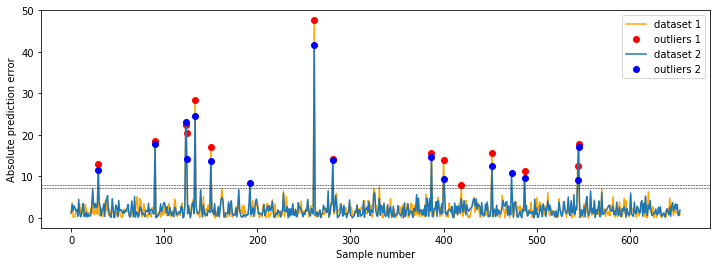

In [12]:
plt.figure(figsize=(12,4))
plt.plot(pred_error1, c='orange',label='dataset 1')
plt.plot(ind1, pred_error1[pred_error1>=2.5*pred_error1_std],'ro',label='outliers 1')
plt.axhline(2.5*pred_error1_std,c='k',ls='--',lw=0.5)

plt.plot(pred_error2, label='dataset 2')
plt.plot(ind2, pred_error2[pred_error2>=2.5*pred_error2_std],'bo', label='outliers 2')
plt.axhline(2.5*pred_error2_std,c='k',ls='--',lw=0.5)

plt.xlabel('Sample number')
plt.ylabel('Absolute prediction error')
plt.legend()
plt.show()

In [13]:
## Take a look at the indices of the outlier points in both datasets
print(np.ravel(ind1))
print(np.ravel(ind2))

[ 29  90 123 124 133 150 261 281 387 400 419 452 487 544 545]
[ 29  90 123 124 133 150 192 261 281 387 400 452 473 487 544 545]


In [10]:
### Pre-computed outliers indices (for speed up the process in case of skiping outlier removal steps...)
# ind1=[ 29, 90, 123, 124, 133, 150, 261, 281, 387, 400, 419, 452, 487, 544, 545]
# ind2=[ 29, 90, 123, 124, 133, 150, 192, 261, 281, 387, 400, 452, 473, 487, 544, 545]

Personal note: Note that the data points that show an abnormal behaviour are basically the same in both datasets (1 and 2). This might indicate that if there was a problem during the sample measurement, this occurred on the chemical analysis side, not on the spectroscopic measurements (since both instruments were independent).

Next: Remove the outliers from the original dataset and recompute the PLS model

PLS model for full clean dataset from instrument 1 

R2: 0.982
Root Mean Squared Error (RMSE): 2.264
Huber loss (huber): 1.154
Standard Error Prediction (SEP): 2.264


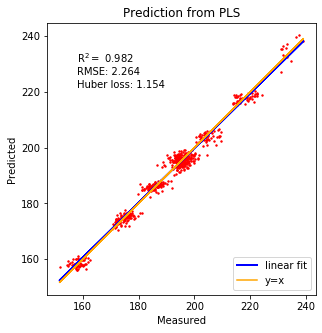

PLS model for full clean dataset from instrument 2 

R2: 0.986
Root Mean Squared Error (RMSE): 2.036
Huber loss (huber): 1.002
Standard Error Prediction (SEP): 2.036


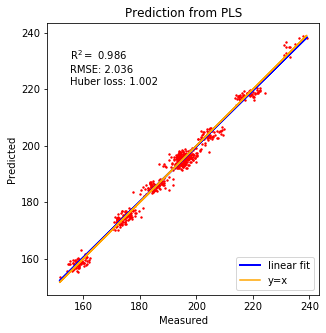

In [11]:
## Recompute PLS for the full clean datasets

print('PLS model for full clean dataset from instrument 1 \n')
X1_clean=np.delete(X1,ind1,axis=0)
Y1_clean=np.delete(Y,ind1,axis=0)
_=pls_prediction2(X1_clean,Y1_clean[:,2], X1_clean , Y1_clean[:,2],components=9,plot_components=True)  

print('PLS model for full clean dataset from instrument 2 \n')
X2_clean=np.delete(X2,ind2,axis=0)
Y2_clean=np.delete(Y,ind2,axis=0)
_=pls_prediction2(X2_clean,Y2_clean[:,2], X2_clean , Y2_clean[:,2],components=16,plot_components=True)  

In [12]:
## check for nans
print('NANs on X1_clean? = ',np.isnan(np.sum(X1_clean)))
print('NANs on Y1_clean? = ',np.isnan(np.sum(Y1_clean)))
print('NANs on X2_clean? = ',np.isnan(np.sum(X2_clean)))
print('NANs on Y2_clean? = ',np.isnan(np.sum(Y2_clean)))

NANs on X1_clean? =  False
NANs on Y1_clean? =  False
NANs on X2_clean? =  False
NANs on Y2_clean? =  False


In [13]:
print('Instrument 1 clean data size after outlier removed = {}'.format(X1_clean.shape))
print('Instrument 2 clean data size after outlier removed = {}'.format(X2_clean.shape))

Instrument 1 clean data size after outlier removed = (640, 600)
Instrument 2 clean data size after outlier removed = (639, 600)


As a result of the outlier removal (e.g. datasets **X1_clean/Y1_clean** and **X2_clean/Y2_clean** , all error metrics improved visibly! Now that we have got rid of the outliers lets process forward to the pre-preocessing stage. 

## Data split, global scaling and EMSC pre-prossessing

Althought in the Bjerrum et al 2017 paper the authors study several datasets preprocessing, here we just check two of them (identified in the paper as Standard (GS) and EMSC (EMSC+GS).

First we do a split of the clean datasets into train/test subsets. We will use this 20% split to generate our working datasets.

In [14]:
## Data from spectrometer 1
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X1_clean, Y1_clean[:,2], test_size=0.2, random_state=42)
## Data from spectrometer 2
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X2_clean, Y2_clean[:,2], test_size=0.2, random_state=42)

EMSC+GS Train1 std:  0.5
EMSC+GS Train1 mean:  -6.079396245676586e-16
EMSC+GS Train1 max:  1.6312835305566895
EMSC+GS Train1 min:  -1.0425559972852785


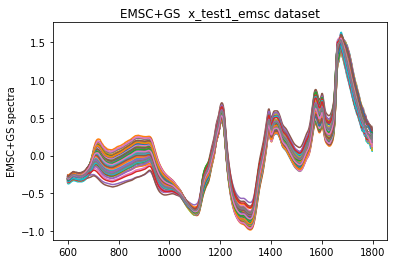

In [15]:
## EMSC correction + GlobalScaling dataset (adapted from DeepChemometrics)

## Check if ChemUtils is imported

## First: do the EMSC correction based only on the unscaled training dataset 1
emsc = EmscScaler()
emsc.fit(x_train_1)

x_train1_emsc0 = emsc.fit_transform(x_train_1)
x_train2_emsc0 = emsc.transform(x_train_2)
x_test1_emsc0 = emsc.transform(x_test_1)
x_test2_emsc0 = emsc.transform(x_test_2)


## Second: Rescale the EMSC data (more or less to near [-1, 1])
xscaler0 = GlobalStandardScaler(normfact=2) # normfact=2 ensure that we are dividing by 2. std 

## We use the avalaible data from the training set to create the scaler, and use that 
## same scaler to scale the other (unseen) subsets
x_train1_emsc = xscaler0.fit_transform(x_train1_emsc0)

x_train2_emsc = xscaler0.transform(x_train2_emsc0)
x_test1_emsc = xscaler0.transform(x_test1_emsc0)
x_test2_emsc= xscaler0.transform(x_test2_emsc0)

print('EMSC+GS Train1 std: ',x_train1_emsc.std())
print('EMSC+GS Train1 mean: ',x_train1_emsc.mean())
print('EMSC+GS Train1 max: ',x_train1_emsc.max())
print('EMSC+GS Train1 min: ',x_train1_emsc.min())

plt.plot(l,x_test1_emsc.T)
plt.title('EMSC+GS  x_test1_emsc dataset')
plt.ylabel('EMSC+GS spectra')
plt.show()

The differences between spectrums are not changed, but the range is adjusted and the mean moved to zero.

GS Train1 std:  0.5
GS Train1 mean:  -1.022052812752842e-15
GS Train1 max:  2.0138568880448253
GS Train1 min:  -0.9790231524089619


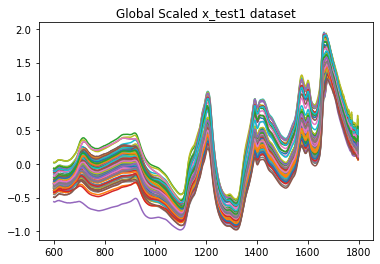

In [16]:
## GlobalScaling dataset  (adapted from DeepChemometrics)

## Check if ChemUtils is imported
xscaler = GlobalStandardScaler(normfact=2) # normfact=2 ensure that we are dividing by 2. std 

## We use the avalaible data from the training set to create the scaler, and use that 
## same scaler to scale the other (unseen) sets
x_train1_gs = xscaler.fit_transform(x_train_1)

x_train2_gs = xscaler.transform(x_train_2)
x_test1_gs = xscaler.transform(x_test_1)
x_test2_gs= xscaler.transform(x_test_2)

print('GS Train1 std: ',x_train1_gs.std())
print('GS Train1 mean: ',x_train1_gs.mean())
print('GS Train1 max: ',x_train1_gs.max())
print('GS Train1 min: ',x_train1_gs.min())

plt.plot(l,x_test1_gs.T)
# plt.plot(l,x_test2.T,'k')
plt.title('Global Scaled x_test1 dataset')
plt.show()

And finally, we also scale the target (label) values Y. Note that error predictions should be done with unscalled Y values! For the PLS model this rescaling makes no difference (in principle) but it will be useful for the CNN model.

y_train1 shape=(512, 1), 	 y_test1 shape=(128, 1)


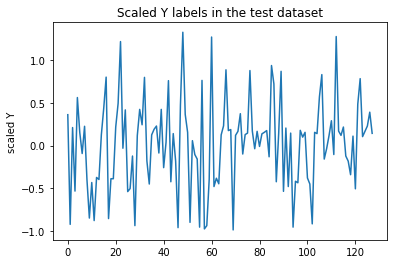

In [17]:
yscaler = GlobalStandardScaler(normfact=2.)
y_train1_scaled = yscaler.fit_transform(y_train_1).reshape(-1,1)
y_train2_scaled = yscaler.transform(y_train_2).reshape(-1,1)
y_test1_scaled = yscaler.transform(y_test_1).reshape(-1,1)
y_test2_scaled = yscaler.transform(y_test_2).reshape(-1,1)

print('y_train1 shape={}, \t y_test1 shape={}'.format(y_train1_scaled.shape,y_test1_scaled.shape))
plt.plot(y_test1_scaled)
plt.title('Scaled Y labels in the test dataset')
plt.ylabel('scaled Y')
plt.show()

In [18]:
## Dimensions sanity check
print(np.shape(x_test1_gs))
print(np.shape(x_test1_emsc))
print(np.shape(y_test1_scaled))
print(np.shape(x_test2_gs))
print(np.shape(x_test2_emsc))
print(np.shape(y_test2_scaled))

(128, 600)
(128, 600)
(128, 1)
(128, 600)
(128, 600)
(128, 1)


## PLS model (metrics baseline)

Just as proposed in Bjerrum etal 2017, in order to find the optimal PLS model, we "cheat" by using the test set to find the optimal LV number. In a normal calibration setup we would split the training set further into _cal and _val subsets and optimize the model that way (we will do this for the CNN model though).

Note: The error metrics that the PLS optimization function outputs are not scaled in the right range because we scaled the Y data. The proper error metric will be computed later using the optimal PLS model and the benchmark function. 

**** GS Datasets ****
** Calibrate PLS on data1 and validate on data1
100% completed
Suggested number of components based in MSE:  11
Suggested number of components based in huber:  11


Error metrics for test set:
R2: 0.987
Root Mean Squared Error (RMSE): 0.059
Huber loss (huber): 0.002
Standard Error Prediction (SEP): 0.731


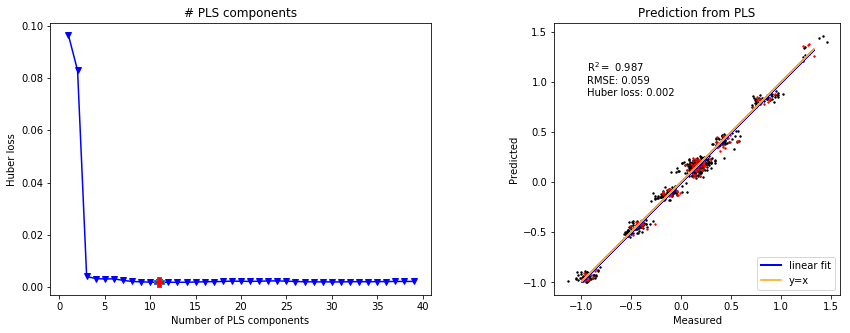

** Calibrate PLS on data1 and validate on data2
100% completed
Suggested number of components based in MSE:  6
Suggested number of components based in huber:  6


Error metrics for test set:
R2: 0.944
Root Mean Squared Error (RMSE): 0.113
Huber loss (huber): 0.006
Standard Error Prediction (SEP): 0.656


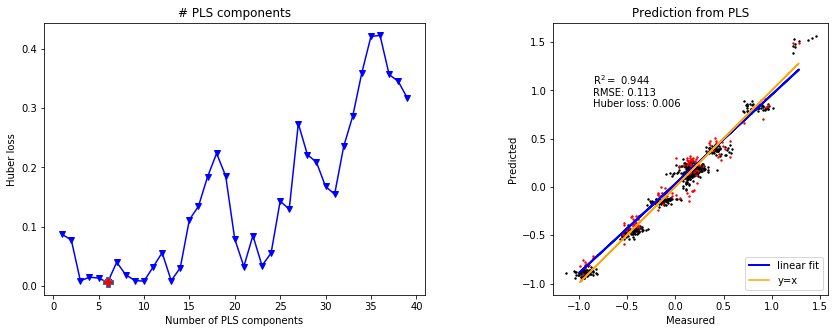

In [45]:
## Find optimimal PLS components for global scaled datasets 1 and 2
print('**** GS Datasets ****')

print('** Calibrate PLS on data1 and validate on data1')
_ = pls_prediction(x_train1_gs, y_train1_scaled, x_test1_gs, y_test1_scaled, loss='huber',plot_components=True)

print('** Calibrate PLS on data1 and validate on data2')
_ =pls_prediction(x_train1_gs, y_train1_scaled, x_test2_gs, y_test2_scaled, loss='huber',plot_components=True)



Metrics training on train set 1 and predicting on test set 1
R2: 0.987
Root Mean Squared Error (RMSE): 0.059
Huber loss (huber): 0.002
Standard Error Prediction (SEP): 0.731


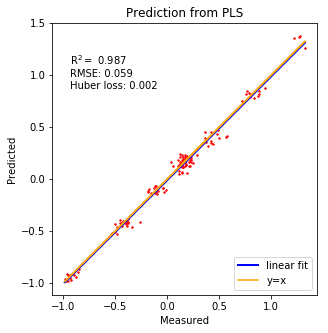

Unscaled Y metrics


*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.984	/  0.987
RMSE  	(Train/Test) = 	2.135 	/  2.004
Huber 	(Train/Test) = 	1.062	/  0.995


Metrics training on train set 1 and predicting on test set 2
R2: 0.944
Root Mean Squared Error (RMSE): 0.113
Huber loss (huber): 0.006
Standard Error Prediction (SEP): 0.656


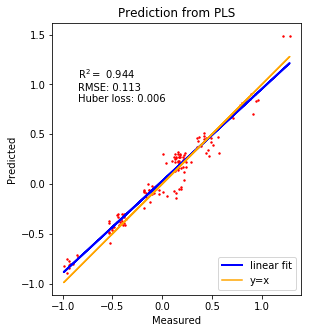

Unscaled Y metrics


*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.973	/  0.944
RMSE  	(Train/Test) = 	2.767 	/  3.816
Huber 	(Train/Test) = 	1.506	/  2.343


In [46]:
## Training on train1 and testing in test1 is not used in the paper but I tested it here nonetheless 
print('\n\nMetrics training on train set 1 and predicting on test set 1')
## Computing optimal PLS metrics training on dataset 1 and predicting on dataset 1
y11, y11_pred, pls_model11 = pls_prediction2(x_train1_gs, y_train1_scaled, x_test1_gs, y_test1_scaled, components=11,plot_components=True)
print('Unscaled Y metrics')
benchmark(x_train1_gs, y_train1_scaled, x_test1_gs, y_test1_scaled, pls_model11)


print('\n\nMetrics training on train set 1 and predicting on test set 2')
## Computing optimal PLS metrics training on dataset 1 and predicting on dataset 2
y12, y12_pred, pls_model12 = pls_prediction2(x_train1_gs, y_train1_scaled, x_test2_gs, y_test2_scaled, components=6,plot_components=True)
print('Unscaled Y metrics')
benchmark(x_train1_gs, y_train1_scaled, x_test2_gs, y_test2_scaled, pls_model12)

**** EMSC+GS Datasets ****
** Calibrate PLS on data1 and validate on data1
100% completed
Suggested number of components based in MSE:  10
Suggested number of components based in huber:  10


Error metrics for test set:
R2: 0.989
Root Mean Squared Error (RMSE): 0.055
Huber loss (huber): 0.002
Standard Error Prediction (SEP): 0.729


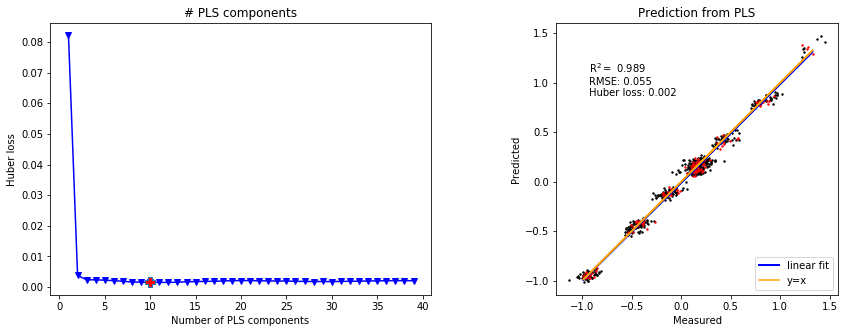

** Calibrate PLS on data1 and validate on data2
100% completed
Suggested number of components based in MSE:  10
Suggested number of components based in huber:  10


Error metrics for test set:
R2: 0.912
Root Mean Squared Error (RMSE): 0.141
Huber loss (huber): 0.010
Standard Error Prediction (SEP): 0.655


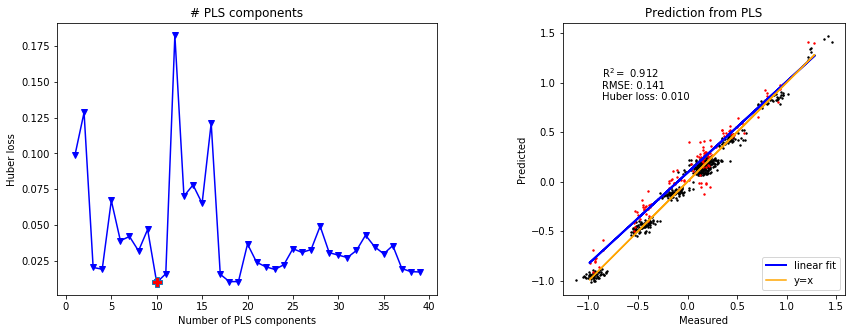

In [47]:
## Find optimimal PLS components for EMSC+GS scaled datasets 1 and 2
print('**** EMSC+GS Datasets ****')

print('** Calibrate PLS on data1 and validate on data1')
_ = pls_prediction(x_train1_emsc, y_train1_scaled, x_test1_emsc, y_test1_scaled, loss='huber',plot_components=True)

print('** Calibrate PLS on data1 and validate on data2')
_ =pls_prediction(x_train1_emsc, y_train1_scaled, x_test2_emsc, y_test2_scaled, loss='huber',plot_components=True)



Metrics training on EMSC train set 1 and predicting on EMSC test set 1
R2: 0.989
Root Mean Squared Error (RMSE): 0.055
Huber loss (huber): 0.002
Standard Error Prediction (SEP): 0.729


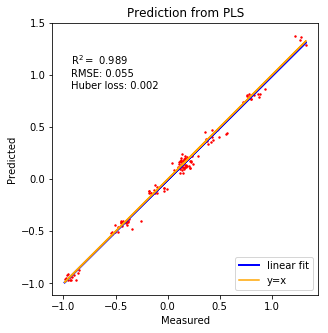

Unscaled Y metrics


*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.985	/  0.989
RMSE  	(Train/Test) = 	2.097 	/  1.858
Huber 	(Train/Test) = 	1.043	/  0.894


Metrics training on train set 1 and predicting on test set 2
R2: 0.912
Root Mean Squared Error (RMSE): 0.141
Huber loss (huber): 0.010
Standard Error Prediction (SEP): 0.655


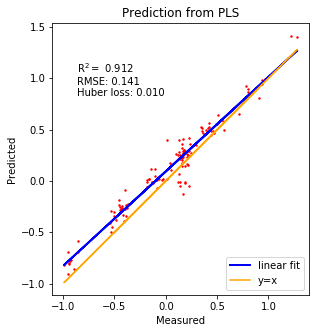

Unscaled Y metrics


*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.985	/  0.912
RMSE  	(Train/Test) = 	2.097 	/  4.775
Huber 	(Train/Test) = 	1.043	/  3.244


In [51]:
## Training on train1 and testing in test1 is not used in the paper but I tested it here nonetheless 
print('\n\nMetrics training on EMSC train set 1 and predicting on EMSC test set 1')
## Computing optimal PLS metrics training on dataset 1 and predicting on dataset 1
y11_emsc, y11_pred_emsc, pls_model11_emsc = pls_prediction2(x_train1_emsc, y_train1_scaled, x_test1_emsc, y_test1_scaled, components=10,plot_components=True)
print('Unscaled Y metrics')
benchmark(x_train1_emsc, y_train1_scaled, x_test1_emsc, y_test1_scaled, pls_model11_emsc)


print('\n\nMetrics training on train set 1 and predicting on test set 2')
## Computing optimal PLS metrics training on dataset 1 and predicting on dataset 2
y12_emsc, y12_pred_emsc, pls_model12_emsc = pls_prediction2(x_train1_emsc, y_train1_scaled, x_test2_emsc, y_test2_scaled, components=10,plot_components=True)
print('Unscaled Y metrics')
benchmark(x_train1_emsc, y_train1_scaled, x_test2_emsc, y_test2_scaled, pls_model12_emsc)

**Comments:** Strange! EMSC+GS does not seem to improve the results over the GS data... Could it be related with the way I'm using using the EMSC scaler of dataset 1 into transforming the test set comming dataset 2? From the paper its not very clear how the authors do this. Maybe for the EMSC correction of test set 2, we should use the average of that test set, not the mean of train set 1 ??

Now that we have defined our error baseline for the predictions using this "optimal" PLS model, lets check if the CNN model does a better job at it.

## Define the CNN model of Bjerrum et al 2017

Check if tensorflow, tensorflow.keras, etc are imported at the begining.

In [43]:
## Dont mind this cell. Its here for testing purposes that is why it is commented!

# ## Data from spectrometer 1
# x_cal1_gs, x_val1_gs, y_cal1_gs, y_val1_gs = train_test_split(x_train1_gs, y_train1_scaled, test_size=0.2, random_state=1234)
# ## Data from spectrometer 2
# x_cal2_gs, x_val2_gs, y_cal2_gs, y_val2_gs = train_test_split(x_train2_gs, y_train2_scaled, test_size=0.2, random_state=1234)


# ## Data from spectrometer 1 emsc
# x_cal1_emsc, x_val1_emsc, y_cal1_emsc, y_val1_emsc = train_test_split(x_train1_emsc, y_train1_scaled, test_size=0.2, random_state=1234)
# ## Data from spectrometer 2 emsc
# x_cal2_emsc, x_val2_emsc, y_cal2_emsc, y_val2_emsc = train_test_split(x_train2_emsc, y_train2_scaled, test_size=0.2, random_state=1234)


### The model

The CNN model consists of two convolutional layers, followed by a flattening to give a 1D vector, whose output is fed to a dense layer with the ReLU activation function which feed a single output neuron. Dropout is added after the flatten layer where there are the most connections and a bit of Gaussian noise is added at the beggining for regularization purposes.
The used loss function is the 'huber_loss' and the optimizer is Adam ( in the original paper the authors used AdaDelta).

In [19]:
## Reference hyperparameters used in Bjerrum 2017 for the standard GS dataset

## Hyperparameters for the network
DENSE = 176      # Number of neurons in the DENSE (a.k.a Fully connected) layer
DROPOUT = 0.045  # Dropout rate
C1_K  = 14       # Number of kernels/filters for conv. first layer
C1_S  = 29       # Width of the filters for first conv. layer
C2_K  = 30       # Number of kernels/filters for second conv. layer
C2_S  = 22       # Width of the filters for second conv. layer

activation='relu'  # activation function (other possible options 'elu' or 'Leaky relu')

input_dim = x_train_1.shape[1]

## The model
def make_model():
    """ This functions outputs the CNN model already compiled """
    model = keras.Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(keras.layers.GaussianNoise(0.01, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(keras.layers.Reshape((input_dim, 1)))
    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='same', activation=activation))
    model.add(keras.layers.Conv1D(C2_K, (C2_S), padding='same', activation=activation))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(DENSE, activation=activation))
    model.add(keras.layers.Dense(1, activation='linear'))
    
    ## Compile options for the model
#     model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])
#     model.compile(loss='mse', optimizer='adam')#, metrics=['mean_absolute_error'])
    model.compile(loss='huber_loss', optimizer=keras.optimizers.Adam(lr=0.0004), metrics=['mean_absolute_error'])
#     model.compile(loss='huber_loss', optimizer='adam', metrics=['mean_squared_error'])

    return model

In [20]:
model_gs = make_model()
print(model_gs.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 600)               0         
_________________________________________________________________
reshape (Reshape)            (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 14)           420       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 30)           9270      
_________________________________________________________________
flatten (Flatten)            (None, 18000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18000)             0         
_________________________________________________________________
dense (Dense)                (None, 176)               3

Run the CNN model with some initial parameters just to check that everything is working. Besides using ReduceLOnPlateau() for automatically adjust the learning rate, I also like to use EarlyStopping to save time in the training. If the loss function does not improve after a few epoch, the computation is over. This also avoids overfitting the data! We do this initial training using a validation_split of 20% over the training dataset.

In [23]:
## In some systems livelossplot might not work properly when used in parallel with ReduceLROnPlateau(). Here I'm importing 
## it but I'm not using it in the callbacks section of the model .fit precedure. Livelossplot allows for a visualization of 
## error metrics in real time during the training process...
from livelossplot.tf_keras import PlotLossesCallback


rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                                           restore_best_weights=True)
plot_losses = PlotLossesCallback(plot_extrema=False)

## Also, use or not the ReduceLOnPlateau() in the callbacks. In this case we have adam fixed at 0.0004 and only use early_stop.

h = model_gs.fit(x_train1_gs, y_train1_scaled, epochs=250, batch_size=45, validation_split=0.2, callbacks=[early_stop])

Epoch 1/250
10/10 [==============================] - 0s 39ms/step - loss: 0.2830 - mean_absolute_error: 0.6128 - val_loss: 0.1321 - val_mean_absolute_error: 0.4098
Epoch 2/250
10/10 [==============================] - 0s 8ms/step - loss: 0.1201 - mean_absolute_error: 0.3827 - val_loss: 0.1065 - val_mean_absolute_error: 0.3592
Epoch 3/250
10/10 [==============================] - 0s 8ms/step - loss: 0.1074 - mean_absolute_error: 0.3633 - val_loss: 0.0962 - val_mean_absolute_error: 0.3500
Epoch 4/250
10/10 [==============================] - 0s 7ms/step - loss: 0.0969 - mean_absolute_error: 0.3528 - val_loss: 0.0921 - val_mean_absolute_error: 0.3483
Epoch 5/250
10/10 [==============================] - 0s 7ms/step - loss: 0.0876 - mean_absolute_error: 0.3364 - val_loss: 0.0801 - val_mean_absolute_error: 0.3204
Epoch 6/250
10/10 [==============================] - 0s 8ms/step - loss: 0.0779 - mean_absolute_error: 0.3152 - val_loss: 0.0711 - val_mean_absolute_error: 0.3049
Epoch 7/250
10/10 [==

10/10 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0689 - val_loss: 0.0042 - val_mean_absolute_error: 0.0711
Epoch 52/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0649 - val_loss: 0.0031 - val_mean_absolute_error: 0.0619
Epoch 53/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0634 - val_loss: 0.0031 - val_mean_absolute_error: 0.0609
Epoch 54/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0649 - val_loss: 0.0044 - val_mean_absolute_error: 0.0740
Epoch 55/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0682 - val_loss: 0.0031 - val_mean_absolute_error: 0.0625
Epoch 56/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0647 - val_loss: 0.0053 - val_mean_absolute_error: 0.0828
Epoch 57/250
10/10 [=========

10/10 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_absolute_error: 0.0814 - val_loss: 0.0119 - val_mean_absolute_error: 0.1357
Epoch 102/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_error: 0.0917 - val_loss: 0.0063 - val_mean_absolute_error: 0.0933
Epoch 103/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0718 - val_loss: 0.0033 - val_mean_absolute_error: 0.0642
Epoch 104/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0659 - val_loss: 0.0032 - val_mean_absolute_error: 0.0630
Epoch 105/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0638 - val_loss: 0.0071 - val_mean_absolute_error: 0.0992
Epoch 106/250
10/10 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_error: 0.0855 - val_loss: 0.0039 - val_mean_absolute_error: 0.0683
Epoch 107/250
10/10 [===

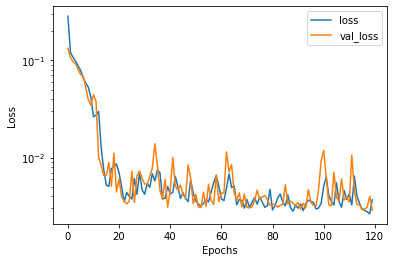

In [24]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
# ax2 = plt.gca().twinx()
# ax2.plot(h.history['lr'], color='r')
# ax2.set_ylabel('lr',color='r')

# _ = plt.legend()

Lets just take a look at the predictions of the model

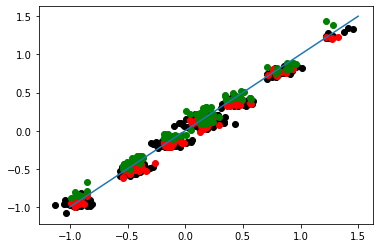

In [25]:
plt.scatter(y_train1_scaled, model_gs.predict(x_train1_gs),c='k')
plt.scatter(y_test1_scaled, model_gs.predict(x_test1_gs),c='r')

plt.scatter(y_test2_scaled, model_gs.predict(x_test2_gs),c='g')
plt.plot([-1,1.5],[-1,1.5]) # Y = PredY line

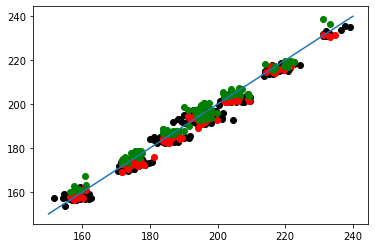

In [26]:
## The same as above but this time with the Y in the original scale. We use the inverse_transform method of our yscaler to 
## convert data into the initial range. This is important for error analysis...

plt.scatter(yscaler.inverse_transform(y_train1_scaled), yscaler.inverse_transform(model_gs.predict(x_train1_gs)),c='k')
plt.scatter(yscaler.inverse_transform(y_test1_scaled), yscaler.inverse_transform(model_gs.predict(x_test1_gs)),c='r')
plt.scatter(yscaler.inverse_transform(y_test2_scaled), yscaler.inverse_transform(model_gs.predict(x_test2_gs)),c='g')
plt.plot([150,240],[150,240]) # Y = PredY line

In [28]:
## run our metrics benchmark by testing on test set2
benchmark(x_train1_gs, y_train1_scaled, x_test2_gs, y_test2_scaled, model_gs)



*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.973	/  0.972
RMSE  	(Train/Test) = 	2.790 	/  2.708
Huber 	(Train/Test) = 	1.538	/  1.528


### Implementing the Bayesian optimization section

First optmization method follows the example of GPyOpt utilization given in:<br>
https://github.com/shibuiwilliam/keras_gpyopt/blob/master/bopt_nn.ipynb

First redifine the model into a function where the hyperparameters are inputs. This function evaluates the model and ouptups a desired score/metric

In [35]:


# The model proposed by Bjerrum et al 2017 and defined earlier
def Bjerrum_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, input_dim):
    activation='relu'
    model = keras.Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(keras.layers.GaussianNoise(0.01, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(keras.layers.Reshape((input_dim, 1)))
    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='same',activation=activation))
    model.add(keras.layers.Conv1D(C2_K, (C2_S),  padding='same', activation=activation))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DropoutR))
    model.add(keras.layers.Dense(DenseN, activation=activation))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss='huber_loss', optimizer=keras.optimizers.Adam(lr=0.0004), metrics=['mean_absolute_error'])
    ## other compile trials
#    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])
#    model.compile(loss='mse', optimizer='adam')#, metrics=['mean_absolute_error'])
#    model.compile(loss='huber_loss', optimizer='adam')#, metrics=['mean_absolute_error'])
    return model



def evaluate_Bjerrum_model(X, Y, DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S):
    
    ## Use the train dataset this way: 80% train(calibrate) and 20% validation
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)
    
    ## compute the input dimensions for the first layer according to input data
    input_dim = x_train.shape[1]
    
    ## define an initial learning rate
    # lr=0.084
    
    ## generate the model
    model = Bjerrum_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, input_dim)
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=4e-5,\
               patience=50, verbose=0, mode='auto', restore_best_weights=True)
    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
#     plot_losses = PlotLossesCallback()
    
    ## fit the train data using x_train (80% of training data) and validate of x_val (20% of training data)
    h=model.fit(x_train,y_train, batch_size=45, validation_data=(x_val, y_val), \
                 callbacks=[rdlr, monitor], verbose=0, epochs=250)
#    h=model.fit(x_train,y_train, batch_size=45, validation_data=(x_val, y_val), \
#                 verbose=0, epochs=200)
#     epochs = monitor.stopped_epoch
        
    ## Make prediction on the validation set and compute final error metrics
    ## In order to better understand the error we must compute it in the original scale of the Y data. Therefore we 
    ## have to rescale the Y data using the yscaler used before.  
      
    y_pred = yscaler.inverse_transform(model.predict(x_val)) # prediction in the right Y scale
    y_true = yscaler.inverse_transform(y_val)                # True Y in the right Y scale
    score_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    score_huber=huber(y_true, y_pred)
    print('RMSE = {}, Huber = {}'.format(score_rmse, score_huber))
#     print('score={}, epochs={}'.format(score, epochs))
    
    ## clear session 
    tf.keras.backend.clear_session()
    
#     return(-score)
    return(score_huber, h, model)




## Since NN training involves random sampling and weights initialization (in this case), it is usefull to
## use averages of several models. In this case we compute the mean of 10 model runs ensuring a lower spread
## of the final error metrics. The trade-off is the longer compution time neeeded...
def evaluate_10_Bjerrum_model(repeats, X, Y, DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S):
    """ This computes the mean of N (repeats) error metrics of the Bjerrum_model"""
    ## Use the train dataset this way: 80% train and 20% validation
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)
    
    ## compute the input dimensions for the first layer according to input data
    input_dim = x_train.shape[1]
    
    ## define an initial learning rate
    # lr=0.084
    
    ## generate the model
    model = Bjerrum_model(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, input_dim)
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=4e-5,\
               patience=50, verbose=0, mode='auto', restore_best_weights=True)
#    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
#     plot_losses = PlotLossesCallback()

    scores_rmse=[]
    scores_huber=[]
    
    # run an experiment

    for r in range(repeats):    
        ## fit the train data using x_train (80% of training data) and validate of x_val (20% of training data)
        h=model.fit(x_train,y_train, batch_size=45, validation_data=(x_val, y_val), \
                     callbacks=[monitor], verbose=0, epochs=150)
        epochs=monitor.stopped_epoch
       
        ## Make prediction on the validation set and compute final error metrics
        ## In order to better understand the error we must compute it in the original scale of the Y data. Therefore we 
        ## have to rescale the Y data using the yscaler used before.  
      
        y_pred = yscaler.inverse_transform(model.predict(x_val)) # prediction in the right Y scale
        y_true = yscaler.inverse_transform(y_val)                # True Y in the right Y scale
        score_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        score_huber=huber(y_true, y_pred)
        print('>#%d' % (r+1))
        scores_rmse.append(score_rmse)
        scores_huber.append(score_huber)
        print('RMSE = {}, Huber = {} over {} epochs' .format(score_rmse, score_huber, epochs))
    
    ## clear session 
    tf.keras.backend.clear_session()
    
#     return(-score)
#     return(score_huber, h, model)
    score_10rmse=np.mean(scores_rmse)
    score_10huber=np.mean(scores_huber)
    print('RMSE (mean of 10 models)= {} \nHuber Loss (mean of 10 models)= {}'.format(score_10rmse, score_10huber))
    return(score_10huber)

Check is everything is working properly by running the model just 3 times

In [20]:
_ = evaluate_10_Bjerrum_model(3, x_train1_gs, y_train1_scaled, DenseN=266, DropoutR=0.07, C1_K=18, C1_S=40, C2_K=18, C2_S=29)

>#1
RMSE = 3.041885313593335, Huber = 1.7317546769540597 over 0 epochs
>#2
RMSE = 2.4329112616358266, Huber = 1.2529156049761707 over 61 epochs
>#3
RMSE = 2.377566089476123, Huber = 1.2068304821159488 over 138 epochs
RMSE (mean of 10 models)= 2.617454221568428 
Huber Loss (mean of 10 models)= 1.3971669213487266


No handles with labels found to put in legend.


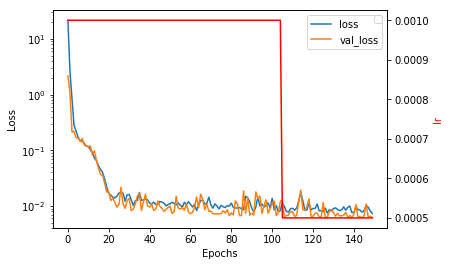

In [141]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r')
ax2.set_ylabel('lr',color='r')

_ = plt.legend()

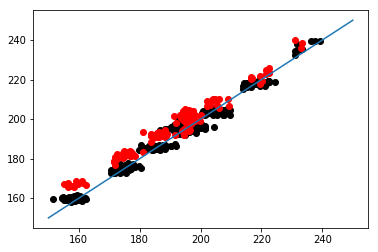

In [142]:
plt.scatter(yscaler.inverse_transform(y_train1_scaled), yscaler.inverse_transform(model_gs1.predict(x_train1_gs)),c='k')
plt.scatter(yscaler.inverse_transform(y_test2_scaled), yscaler.inverse_transform(model_gs1.predict(x_test2_gs)),c='r')

plt.plot([150,250],[150,250]) # Y = PredY line

In [144]:
## Benchmark the model using test data 2
benchmark(x_train1_gs, y_train1_scaled, x_test2_gs, y_test2_scaled, model_gs1)



*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.977	/  0.869
RMSE  	(Train/Test) = 	2.563 	/  6.185
Huber 	(Train/Test) = 	1.375	/  4.661


Ok, everything seems to be working with the way we implemented the model functions so lets proceed to the Bayesian Optimization of the CNN model.

### Bayesian Optimization of the model
The Bayesian optimization routine was adapted from [this example](https://github.com/shibuiwilliam/keras_gpyopt/blob/master/bopt_nn.ipynb)

Define bounds for hyperparameter optimization

In [41]:
import GPy, GPyOpt

## Range of parameters used by Bjerrum etal 2017
dense_range=np.arange(4,720,1)
c1_k_range=np.arange(2,64,1)
c1_s_range=np.arange(2,256,1)
c2_k_range=np.arange(2,64,1)
c2_s_range=np.arange(2,256,1)
# batch_number=np.array([8,16,32,64])

# bounds for hyperparameters in the model
bounds = [{'name': 'DenseN',   'type': 'discrete',  'domain': (dense_range)},
          {'name': 'DropoutR', 'type': 'continuous',  'domain': (0.0, 0.5)},
          {'name': 'C1_K',     'type': 'discrete',  'domain': c1_k_range},
          {'name': 'C1_S',     'type': 'discrete',  'domain': c1_s_range},
          {'name': 'C2_K',     'type': 'discrete',  'domain': c2_k_range},
          {'name': 'C2_S',     'type': 'discrete',  'domain': c2_s_range}]


# optimizer = GPyOpt.methods.BayesianOptimization(
#     f=evaluate_model,
#     domain=bounds,
#     verbose=2,  # verbose = 1 prints only when a maximum 
#     is observed, verbose = 0 is silent
#     random_state=1,
# )

#### BO of the CNN for the GS dataset

In [46]:
# function to optimize the model
def f(x):
    print(x)
    evaluation = evaluate_10_Bjerrum_model(10, x_train1_gs, y_train1_scaled,  
                                DenseN = int(x[:,0]), 
                                DropoutR = float(x[:,1]), 
                                C1_K=int(x[:,2]), 
                                C1_S=int(x[:,3]), 
                                C2_K=int(x[:,4]), 
                                C2_S=int(x[:,5]))
    print(evaluation)
    return evaluation

## This function outputs the huber_loss metric of the CNN model (this is parameter evaluate_Bjerrum_model()[0] ).
## The inputs of the function are the CNN hyperparameters. The BO will look for hyperparameters values defined by the "bounds" interval and try to minimze the huber_loss score!

In [48]:
## Initialize the model with 10 random hyperparameters
opt_model_gs = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, initial_design_numdata=10,verbose=1)

[[228.           0.32542589  20.          48.          17.
  100.        ]]
>#1
RMSE = 2.8692130965059306, Huber = 1.5677712352149797 over 137 epochs
>#2
RMSE = 2.7434897173075776, Huber = 1.4815489039964167 over 127 epochs
RMSE (mean of 10 models)= 2.806351406906754 
Huber Loss (mean of 10 models)= 1.5246600696056982
1.5246600696056982
[[125.           0.15646645   7.         155.          28.
   30.        ]]
>#1
RMSE = 2.6264090235126942, Huber = 1.3639434988015764 over 133 epochs
>#2
RMSE = 2.5481239648400678, Huber = 1.2888105222165989 over 131 epochs
RMSE (mean of 10 models)= 2.587266494176381 
Huber Loss (mean of 10 models)= 1.3263770105090877
1.3263770105090877
[[216.           0.38436772  62.         173.          34.
  137.        ]]
>#1
RMSE = 3.5742055152828867, Huber = 2.151835211223937 over 0 epochs
>#2
RMSE = 4.098394222303737, Huber = 2.514185648326489 over 0 epochs
RMSE (mean of 10 models)= 3.836299868793312 
Huber Loss (mean of 10 models)= 2.333010429775213
2.33301042

In [49]:
# optimize the model over 200 iteration (takes about 1h on GTX 1070 Ti or RTX 2080 Ti GPUs)
opt_model_gs.run_optimization(max_iter=200)

[[146.           0.34285681  21.         129.          51.
  208.        ]]
>#1
RMSE = 2.8654453988227866, Huber = 1.5679895041557237 over 136 epochs
>#2
RMSE = 3.4098970301019134, Huber = 1.9856179411699857 over 0 epochs
RMSE (mean of 10 models)= 3.13767121446235 
Huber Loss (mean of 10 models)= 1.7768037226628546
1.7768037226628546
[[3.60000000e+01 5.68114914e-02 4.00000000e+01 2.50000000e+02
  4.90000000e+01 3.60000000e+01]]
>#1
RMSE = 2.766199375614916, Huber = 1.5157943331873511 over 121 epochs
>#2
RMSE = 2.599546281193307, Huber = 1.3685805817215053 over 81 epochs
RMSE (mean of 10 models)= 2.6828728284041112 
Huber Loss (mean of 10 models)= 1.4421874574544282
1.4421874574544282
[[134.          0.3092307  41.        187.         53.        161.       ]]
>#1
RMSE = 3.884706311476888, Huber = 2.3981728089861267 over 0 epochs
>#2
RMSE = 2.73271385438731, Huber = 1.464836077382847 over 63 epochs
RMSE (mean of 10 models)= 3.308710082932099 
Huber Loss (mean of 10 models)= 1.93150444318

[[628.   0.  63. 108.   2.  66.]]
>#1
RMSE = 2.839072017686264, Huber = 1.5328097902328497 over 0 epochs
>#2
RMSE = 2.460476137131434, Huber = 1.233532342535324 over 121 epochs
RMSE (mean of 10 models)= 2.649774077408849 
Huber Loss (mean of 10 models)= 1.3831710663840868
1.3831710663840868
[[575.   0.  35.  59.  63.  90.]]
>#1
RMSE = 2.9287256864989444, Huber = 1.5963179176526627 over 0 epochs
>#2
RMSE = 2.4603733759639326, Huber = 1.235423912628423 over 124 epochs
RMSE (mean of 10 models)= 2.6945495312314387 
Huber Loss (mean of 10 models)= 1.4158709151405429
1.4158709151405429
[[671.   0.  63.  61.  63.  41.]]
>#1
RMSE = 2.821445201087776, Huber = 1.5057971400935266 over 0 epochs
>#2
RMSE = 2.399109808331687, Huber = 1.2003493808496428 over 59 epochs
RMSE (mean of 10 models)= 2.6102775047097317 
Huber Loss (mean of 10 models)= 1.3530732604715847
1.3530732604715847
[[6.33e+02 5.00e-01 2.00e+00 1.08e+02 5.30e+01 3.10e+01]]
>#1
RMSE = 4.077188415143119, Huber = 2.62583273327866 over 0 

[[105.           0.24923242  13.         206.          39.
   37.        ]]
>#1
RMSE = 2.763270653467469, Huber = 1.4860637799938032 over 0 epochs
>#2
RMSE = 2.4970783052797194, Huber = 1.2404019345004569 over 65 epochs
RMSE (mean of 10 models)= 2.6301744793735944 
Huber Loss (mean of 10 models)= 1.3632328572471302
1.3632328572471302
[[4.63000000e+02 2.72971562e-01 2.40000000e+01 2.70000000e+01
  2.20000000e+01 2.12000000e+02]]
>#1
RMSE = 2.905606243381016, Huber = 1.5737954454038463 over 0 epochs
>#2
RMSE = 2.4549601361195625, Huber = 1.2389783610831184 over 126 epochs
RMSE (mean of 10 models)= 2.6802831897502895 
Huber Loss (mean of 10 models)= 1.4063869032434824
1.4063869032434824
[[5.66000000e+02 7.29880529e-02 1.80000000e+01 5.20000000e+01
  6.10000000e+01 2.31000000e+02]]
>#1
RMSE = 3.1269231365595, Huber = 1.7739405065517224 over 0 epochs
>#2
RMSE = 2.492618882775606, Huber = 1.2474461311393887 over 53 epochs
RMSE (mean of 10 models)= 2.809771009667553 
Huber Loss (mean of 10 mo

>#2
RMSE = 2.5438226966646384, Huber = 1.3422063285151795 over 121 epochs
RMSE (mean of 10 models)= 2.840409967478887 
Huber Loss (mean of 10 models)= 1.5829927206107084
1.5829927206107084
[[105.   0.   2. 210.   2.   2.]]
>#1
RMSE = 3.0066301765702077, Huber = 1.6344072723786607 over 0 epochs
>#2
RMSE = 2.7068824745187277, Huber = 1.4201277531536263 over 96 epochs
RMSE (mean of 10 models)= 2.8567563255444677 
Huber Loss (mean of 10 models)= 1.5272675127661435
1.5272675127661435
[[638.   0.  15.  55.   2. 155.]]
>#1
RMSE = 2.6505382050079076, Huber = 1.4105740152867863 over 93 epochs
>#2
RMSE = 2.644506110549468, Huber = 1.414887499679771 over 51 epochs
RMSE (mean of 10 models)= 2.647522157778688 
Huber Loss (mean of 10 models)= 1.4127307574832786
1.4127307574832786
[[5.47e+02 5.00e-01 6.30e+01 6.80e+01 1.70e+01 2.55e+02]]
>#1
RMSE = 16.702197167732255, Huber = 11.977526708807689 over 50 epochs
>#2
RMSE = 16.73364053503226, Huber = 12.024537184172052 over 50 epochs
RMSE (mean of 10 mod

>#2
RMSE = 2.417396463021525, Huber = 1.2140452313362111 over 86 epochs
RMSE (mean of 10 models)= 3.39816089467238 
Huber Loss (mean of 10 models)= 2.0805797310506158
2.0805797310506158
[[643.   0.  22.  63.  22.   2.]]
>#1
RMSE = 2.498734057262162, Huber = 1.292061754132021 over 142 epochs
>#2
RMSE = 2.442461198535115, Huber = 1.2266857028555238 over 135 epochs
RMSE (mean of 10 models)= 2.4705976278986386 
Huber Loss (mean of 10 models)= 1.2593737284937725
1.2593737284937725
[[7.15e+02 5.00e-01 2.00e+00 2.20e+02 6.30e+01 2.90e+01]]
>#1
RMSE = 2.6052542288829303, Huber = 1.3548448534703594 over 135 epochs
>#2
RMSE = 2.5964787658716566, Huber = 1.3329282234520747 over 95 epochs
RMSE (mean of 10 models)= 2.6008664973772935 
Huber Loss (mean of 10 models)= 1.343886538461217
1.343886538461217
[[688.   0.   2. 228.  63.  85.]]
>#1
RMSE = 2.5576926366080044, Huber = 1.3424669902273982 over 126 epochs
>#2
RMSE = 2.501090263128007, Huber = 1.2823719603993484 over 88 epochs
RMSE (mean of 10 mod

[[184.   0.   2. 133.   2.  39.]]
>#1
RMSE = 2.452580074907585, Huber = 1.253040749413813 over 138 epochs
>#2
RMSE = 2.509385006647813, Huber = 1.2931248530416486 over 50 epochs
RMSE (mean of 10 models)= 2.480982540777699 
Huber Loss (mean of 10 models)= 1.2730828012277309
1.2730828012277309
[[119.    0.5  63.  255.   63.  161. ]]
>#1
RMSE = 2.912347652481929, Huber = 1.6166433117141166 over 124 epochs
>#2
RMSE = 2.7090247073430844, Huber = 1.3900843513568972 over 131 epochs
RMSE (mean of 10 models)= 2.8106861799125067 
Huber Loss (mean of 10 models)= 1.503363831535507
1.503363831535507
[[212.   0.   2. 119.   2.  97.]]
>#1
RMSE = 2.652853330591751, Huber = 1.3874111532022584 over 132 epochs
>#2
RMSE = 2.9982261183117367, Huber = 1.6367001705546549 over 0 epochs
RMSE (mean of 10 models)= 2.825539724451744 
Huber Loss (mean of 10 models)= 1.5120556618784566
1.5120556618784566
[[250.   0.   2.  79.  63.  78.]]
>#1
RMSE = 2.379574127598523, Huber = 1.1999707556874084 over 137 epochs
>#2
R

[[186.    0.5  24.   39.   63.  102. ]]
>#1
RMSE = 4.078463622763468, Huber = 2.591067717961026 over 0 epochs
>#2
RMSE = 3.0110126633665564, Huber = 1.6768239956400444 over 0 epochs
RMSE (mean of 10 models)= 3.544738143065012 
Huber Loss (mean of 10 models)= 2.133945856800535
2.133945856800535
[[212.   0.   2. 177.   2.   2.]]
>#1
RMSE = 2.49299976939499, Huber = 1.2812276789012416 over 0 epochs
>#2
RMSE = 2.4582153633026245, Huber = 1.2373515941823565 over 74 epochs
RMSE (mean of 10 models)= 2.475607566348807 
Huber Loss (mean of 10 models)= 1.2592896365417992
1.2592896365417992
[[178.   0.   2. 147.  41.   2.]]
>#1
RMSE = 2.5303074120373563, Huber = 1.3208746900298243 over 0 epochs
>#2
RMSE = 2.352478637951178, Huber = 1.1609102766086496 over 136 epochs
RMSE (mean of 10 models)= 2.4413930249942672 
Huber Loss (mean of 10 models)= 1.240892483319237
1.240892483319237
[[251.   0.   2. 193.   2.  54.]]
>#1
RMSE = 2.5563624843658195, Huber = 1.3259850725556734 over 132 epochs
>#2
RMSE = 2

[[396.   0.   2.   2.   8.  88.]]
>#1
RMSE = 2.6434974045166024, Huber = 1.4140166193111472 over 132 epochs
>#2
RMSE = 2.786572747824482, Huber = 1.534135468353292 over 0 epochs
RMSE (mean of 10 models)= 2.715035076170542 
Huber Loss (mean of 10 models)= 1.4740760438322196
1.4740760438322196
[[220.   0.  54.  61.  63. 226.]]
>#1
RMSE = 15.608209476645108, Huber = 11.260939018029084 over 52 epochs
>#2
RMSE = 2.7431839923187535, Huber = 1.450714470622875 over 133 epochs
RMSE (mean of 10 models)= 9.175696734481932 
Huber Loss (mean of 10 models)= 6.35582674432598
6.35582674432598
[[6.75e+02 5.00e-01 2.00e+00 2.55e+02 2.00e+00 8.00e+01]]
>#1
RMSE = 3.0537141632965414, Huber = 1.8088896036738444 over 149 epochs
>#2
RMSE = 4.717709546324298, Huber = 3.144884536319267 over 0 epochs
RMSE (mean of 10 models)= 3.8857118548104195 
Huber Loss (mean of 10 models)= 2.4768870699965557
2.4768870699965557
[[247.   0.  52.   2.  33.  63.]]
>#1
RMSE = 3.8508447024745824, Huber = 2.434046176695626 over 0 

In [50]:
# print optimized model parameters
print("""
Optimized Parameters based on means of 10 models:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"],opt_model_gs.x_opt[0],
           bounds[1]["name"],opt_model_gs.x_opt[1],
           bounds[2]["name"],opt_model_gs.x_opt[2],
           bounds[3]["name"],opt_model_gs.x_opt[3],
           bounds[4]["name"],opt_model_gs.x_opt[4],
           bounds[5]["name"],opt_model_gs.x_opt[5]))
print("optimized huber loss: {0}".format(opt_model_gs.fx_opt))


Optimized Parameters based on means of 10 models:
	DenseN:	590.0
	DropoutR:	0.0
	C1_K:	2.0
	C1_S:	27.0
	C2_K:	63.0
	C2_S:	223.0

optimized huber loss: 1.1615340778383885


In [51]:
# print optimized model parameters (shorter way!)
opt_model_gs.x_opt

array([590.,   0.,   2.,  27.,  63., 223.])

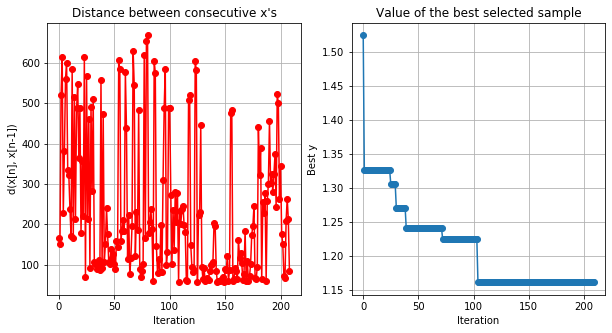

In [52]:
opt_model_gs.plot_convergence()

In [61]:
## re-compute the model with optimized parameters found with the BO 
score_huber, h, model_gs_optimized = evaluate_Bjerrum_model(x_train1_gs, y_train1_scaled, DenseN=590, DropoutR=0., C1_K=2, C1_S=27, C2_K=63, C2_S=223)


Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
RMSE = 2.3328150534404566, Huber = 1.1739032980214739


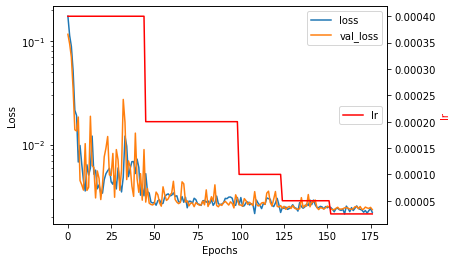

In [62]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r',label='lr')
ax2.set_ylabel('lr',color='r')

plt.legend(loc=5)
plt.show()

In [63]:
benchmark(x_train1_gs, y_train1_scaled, x_test2_gs, y_test2_scaled, model_gs_optimized)



*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.983	/  0.956
RMSE  	(Train/Test) = 	2.192 	/  3.368
Huber 	(Train/Test) = 	1.095	/  1.980


#### BO of the CNN for the GS+EMSC dataset

In [102]:
# function to optimize the model
def f2(x):
    print(x)
    evaluation = evaluate_10_Bjerrum_model(10,x_train1_emsc, y_train1_scaled,  
                                DenseN = int(x[:,0]), 
                                DropoutR = float(x[:,1]), 
                                C1_K=int(x[:,2]), 
                                C1_S=int(x[:,3]), 
                                C2_K=int(x[:,4]), 
                                C2_S=int(x[:,5]))
#    print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0], evaluation[1]))
    print(evaluation)
    return evaluation

In [103]:
opt_model_emsc = GPyOpt.methods.BayesianOptimization(f=f2, domain=bounds, initial_design_numdata=10,verbosity=True)

[[211.           0.43151128  50.         196.          27.
  168.        ]]
>#1
RMSE = 2.7824900392115737, Huber = 1.403831559836892 over 125 epochs
>#2
RMSE = 2.796206334404918, Huber = 1.4989399205087717 over 0 epochs
>#3
RMSE = 2.6407812086238516, Huber = 1.3457500549708277 over 77 epochs
>#4
RMSE = 2.473086815934231, Huber = 1.2275511102823686 over 96 epochs
>#5
RMSE = 2.6771391759286063, Huber = 1.3660470842000612 over 52 epochs
>#6
RMSE = 2.573216151677757, Huber = 1.3052995236711733 over 90 epochs
>#7
RMSE = 2.5473649464462813, Huber = 1.2600474943487985 over 66 epochs
>#8
RMSE = 2.59665704616618, Huber = 1.314060065282629 over 93 epochs
>#9
RMSE = 2.5396284583325595, Huber = 1.2631193958210563 over 51 epochs
>#10
RMSE = 2.6471683649030626, Huber = 1.3676266039909153 over 63 epochs
RMSE (mean of 10 models)= 2.627373854162902 
Huber Loss (mean of 10 models)= 1.3352272812913495
1.3352272812913495
[[3.78000000e+02 1.46232287e-01 5.40000000e+01 8.90000000e+01
  3.10000000e+01 2.6000

>#1
RMSE = 2.619086255763984, Huber = 1.3752750425485738 over 0 epochs
>#2
RMSE = 2.569402336926734, Huber = 1.3044806622394038 over 94 epochs
>#3
RMSE = 2.5693553408849805, Huber = 1.3074954034637223 over 100 epochs
>#4
RMSE = 2.547107486676255, Huber = 1.2838716242086612 over 52 epochs
>#5
RMSE = 2.4669155044794726, Huber = 1.2207037953808804 over 96 epochs
>#6
RMSE = 2.4100967881133077, Huber = 1.191648872434169 over 128 epochs
>#7
RMSE = 2.402344853891976, Huber = 1.1675092260820865 over 52 epochs
>#8
RMSE = 2.4074635956398223, Huber = 1.1709769057388448 over 52 epochs
>#9
RMSE = 2.441231346042378, Huber = 1.1963109739573345 over 52 epochs
>#10
RMSE = 2.3643890130079392, Huber = 1.1361532188912882 over 136 epochs
RMSE (mean of 10 models)= 2.4797392521426853 
Huber Loss (mean of 10 models)= 1.2354425724944964
1.2354425724944964


In [107]:
opt_model_emsc.run_optimization(max_iter=200)

[[130.           0.15428132   6.          30.          11.
  123.        ]]
>#1
RMSE = 2.6616038623997462, Huber = 1.4399187643283407 over 80 epochs
>#2
RMSE = 2.5663420454611217, Huber = 1.3248905925571195 over 127 epochs
>#3
RMSE = 2.5790104807690573, Huber = 1.3596779119625955 over 73 epochs
>#4
RMSE = 2.4973397595290536, Huber = 1.2755415461289636 over 120 epochs
>#5
RMSE = 2.4936412428614103, Huber = 1.2426708975260505 over 96 epochs
>#6
RMSE = 2.4579156854017707, Huber = 1.2437959949543915 over 128 epochs
>#7
RMSE = 2.4233527877787298, Huber = 1.1854531261396404 over 128 epochs
>#8
RMSE = 2.4414483611368456, Huber = 1.2255912355131127 over 74 epochs
>#9
RMSE = 2.4526284160487566, Huber = 1.2159766354304054 over 70 epochs
>#10
RMSE = 2.431723802205245, Huber = 1.20714730575902 over 56 epochs
RMSE (mean of 10 models)= 2.5005006443591737 
Huber Loss (mean of 10 models)= 1.272066401029964
1.272066401029964
[[4.50000000e+02 2.56187052e-01 6.00000000e+01 1.88000000e+02
  2.70000000e+01

>#1
RMSE = 2.6479964313055757, Huber = 1.3832300014952805 over 0 epochs
>#2
RMSE = 2.4779897081748286, Huber = 1.2357736714307035 over 0 epochs
>#3
RMSE = 2.3146799215540272, Huber = 1.1035477716139948 over 127 epochs
>#4
RMSE = 2.3437017998587524, Huber = 1.1031872806686525 over 59 epochs
>#5
RMSE = 2.424242710541732, Huber = 1.16295723302445 over 65 epochs
>#6
RMSE = 2.313851919543793, Huber = 1.118574239775536 over 65 epochs
>#7
RMSE = 2.333217324775355, Huber = 1.0988989362514228 over 148 epochs
>#8
RMSE = 2.321672730996119, Huber = 1.0812114639968635 over 95 epochs
>#9
RMSE = 2.3601799724964914, Huber = 1.1693723968572765 over 54 epochs
>#10
RMSE = 2.267729016127723, Huber = 1.0411888901091368 over 97 epochs
RMSE (mean of 10 models)= 2.3805261535374402 
Huber Loss (mean of 10 models)= 1.1497941885223315
1.1497941885223315
[[ 87.           0.49635762  18.         150.          47.
   43.        ]]
>#1
RMSE = 3.429054527502625, Huber = 2.0335946432033376 over 0 epochs
>#2
RMSE = 2.5

>#1
RMSE = 2.5048370716492068, Huber = 1.3108614175379405 over 0 epochs
>#2
RMSE = 2.493158042275141, Huber = 1.306819661665546 over 79 epochs
>#3
RMSE = 2.5216634778462095, Huber = 1.3170194156502077 over 53 epochs
>#4
RMSE = 2.5452005952180308, Huber = 1.3366148986402224 over 59 epochs
>#5
RMSE = 2.471693953557207, Huber = 1.2817542933174628 over 79 epochs
>#6
RMSE = 2.6344682150279244, Huber = 1.4067732680843619 over 0 epochs
>#7
RMSE = 2.4178258599336506, Huber = 1.224187511682196 over 55 epochs
>#8
RMSE = 2.401926463352112, Huber = 1.2049180884620674 over 94 epochs
>#9
RMSE = 2.4297582824092396, Huber = 1.2320406544601226 over 109 epochs
>#10
RMSE = 2.394937108315871, Huber = 1.2162978891670604 over 78 epochs
RMSE (mean of 10 models)= 2.4815469069584593 
Huber Loss (mean of 10 models)= 1.283728709866719
1.283728709866719
[[3.07000000e+02 1.05596189e-01 5.50000000e+01 2.22000000e+02
  3.60000000e+01 1.03000000e+02]]
>#1
RMSE = 3.1732806465313343, Huber = 1.7870382871787975 over 0 e

>#5
RMSE = 2.3545285321384166, Huber = 1.1662910934778163 over 64 epochs
>#6
RMSE = 2.3023267686361693, Huber = 1.1099464646324222 over 127 epochs
>#7
RMSE = 2.3455419670585584, Huber = 1.1376656735392834 over 96 epochs
>#8
RMSE = 2.363620025719774, Huber = 1.14977931810912 over 52 epochs
>#9
RMSE = 2.353716842382617, Huber = 1.149628168446457 over 74 epochs
>#10
RMSE = 2.3354126966280235, Huber = 1.130753280683209 over 103 epochs
RMSE (mean of 10 models)= 2.3678189343405505 
Huber Loss (mean of 10 models)= 1.1661372688323977
1.1661372688323977
[[200.   0.  63.   2.   2. 190.]]
>#1
RMSE = 2.562382714012462, Huber = 1.3289446969798848 over 132 epochs
>#2
RMSE = 2.4086997473064904, Huber = 1.2039961887589412 over 0 epochs
>#3
RMSE = 2.346435840642447, Huber = 1.1562537816458043 over 98 epochs
>#4
RMSE = 2.3672057177546812, Huber = 1.1722317947762413 over 66 epochs
>#5
RMSE = 2.307575293333585, Huber = 1.103189533449507 over 128 epochs
>#6
RMSE = 2.3223226178067193, Huber = 1.128661451963

>#10
RMSE = 2.407643628857204, Huber = 1.17974233049493 over 99 epochs
RMSE (mean of 10 models)= 2.4294289914313207 
Huber Loss (mean of 10 models)= 1.211938736499242
1.211938736499242
[[640.   0.   2. 145.  63. 255.]]
>#1
RMSE = 2.4909209090323614, Huber = 1.2354218819907434 over 98 epochs
>#2
RMSE = 2.4038436341525036, Huber = 1.1645342457983558 over 105 epochs
>#3
RMSE = 2.413247454153584, Huber = 1.199942125974551 over 91 epochs
>#4
RMSE = 2.306425745422656, Huber = 1.096680768776264 over 128 epochs
>#5
RMSE = 2.3356374722969537, Huber = 1.1402356787608987 over 72 epochs
>#6
RMSE = 2.3555485353202887, Huber = 1.1456708672916756 over 72 epochs
>#7
RMSE = 2.4012715601236065, Huber = 1.204777553243514 over 0 epochs
>#8
RMSE = 2.313782473242751, Huber = 1.0876020628326692 over 99 epochs
>#9
RMSE = 2.2868518958282835, Huber = 1.0677964705306358 over 52 epochs
>#10
RMSE = 2.324210437800604, Huber = 1.0876254752926198 over 72 epochs
RMSE (mean of 10 models)= 2.3631740117373594 
Huber Loss

>#3
RMSE = 2.4277992676367477, Huber = 1.2453004745913492 over 98 epochs
>#4
RMSE = 2.378075243531894, Huber = 1.2101705905834248 over 134 epochs
>#5
RMSE = 2.406736572754555, Huber = 1.2431953861156806 over 63 epochs
>#6
RMSE = 2.4245916472394393, Huber = 1.2443480204890014 over 62 epochs
>#7
RMSE = 2.372715035501379, Huber = 1.2049985579438942 over 71 epochs
>#8
RMSE = 2.331868107502741, Huber = 1.1686415898035218 over 134 epochs
>#9
RMSE = 2.3859254967296457, Huber = 1.2220396543367178 over 52 epochs
>#10
RMSE = 2.333578515908083, Huber = 1.1759617816123757 over 64 epochs
RMSE (mean of 10 models)= 2.4042737850961684 
Huber Loss (mean of 10 models)= 1.2253770124208887
1.2253770124208887
[[719.   0.  63.  70.  63. 188.]]
>#1
RMSE = 2.8894350545545104, Huber = 1.5774386188339737 over 0 epochs
>#2
RMSE = 2.395183132919688, Huber = 1.173838513277357 over 128 epochs
>#3
RMSE = 2.4919203836699615, Huber = 1.224384662884706 over 0 epochs
>#4
RMSE = 2.3789413260362653, Huber = 1.146137237729

>#8
RMSE = 2.307961531898933, Huber = 1.1324681746294754 over 64 epochs
>#9
RMSE = 2.264337154123525, Huber = 1.0884668303064973 over 65 epochs
>#10
RMSE = 2.3544444266607307, Huber = 1.1463784298116064 over 51 epochs
RMSE (mean of 10 models)= 2.3723541332999734 
Huber Loss (mean of 10 models)= 1.165476148433498
1.165476148433498
[[590.   0.   2. 195.  63.   2.]]
>#1
RMSE = 2.5460735808841606, Huber = 1.250515306973359 over 0 epochs
>#2
RMSE = 2.4567621205064896, Huber = 1.2213145613945267 over 80 epochs
>#3
RMSE = 2.4334117492660017, Huber = 1.166027162716028 over 117 epochs
>#4
RMSE = 2.437018828414188, Huber = 1.1660687749999565 over 134 epochs
>#5
RMSE = 2.4199167002606985, Huber = 1.1657370979831165 over 52 epochs
>#6
RMSE = 2.4196855343963644, Huber = 1.1558308624307738 over 117 epochs
>#7
RMSE = 2.429822319857799, Huber = 1.16653383315346 over 52 epochs
>#8
RMSE = 2.425075432353412, Huber = 1.1680291330421408 over 59 epochs
>#9
RMSE = 2.3752154223028397, Huber = 1.12838964313028

[[345.   0.   2.   2.   2.   2.]]
>#1
RMSE = 2.7045251652444957, Huber = 1.4625618574240373 over 0 epochs
>#2
RMSE = 2.493575373877005, Huber = 1.2967449169858067 over 65 epochs
>#3
RMSE = 2.448784465513581, Huber = 1.2389498774644696 over 123 epochs
>#4
RMSE = 2.443471194182168, Huber = 1.250720208005949 over 55 epochs
>#5
RMSE = 2.46112733379654, Huber = 1.2610197905347844 over 67 epochs
>#6
RMSE = 2.5038657206707473, Huber = 1.3044557988176306 over 55 epochs
>#7
RMSE = 2.4234579533063827, Huber = 1.2289387505409526 over 138 epochs
>#8
RMSE = 2.390077523008012, Huber = 1.1805103169436164 over 135 epochs
>#9
RMSE = 2.417011802512287, Huber = 1.206262526180199 over 50 epochs
>#10
RMSE = 2.407873489458085, Huber = 1.1972341717564936 over 51 epochs
RMSE (mean of 10 models)= 2.469377002156931 
Huber Loss (mean of 10 models)= 1.262739821465394
1.262739821465394
[[719.   0.   2. 125.  63. 119.]]
>#1
RMSE = 3.235717446427374, Huber = 1.8882783664474376 over 0 epochs
>#2
RMSE = 2.428538819371

>#5
RMSE = 2.3405885442411227, Huber = 1.1600561359794053 over 121 epochs
>#6
RMSE = 2.3382647526643963, Huber = 1.1469491725316978 over 59 epochs
>#7
RMSE = 2.3037565913736677, Huber = 1.1139717514660432 over 99 epochs
>#8
RMSE = 2.312290017288614, Huber = 1.1350935551655044 over 74 epochs
>#9
RMSE = 2.305048404615042, Huber = 1.124293854864836 over 96 epochs
>#10
RMSE = 2.2920327478221543, Huber = 1.116472643533329 over 138 epochs
RMSE (mean of 10 models)= 2.4053214116167174 
Huber Loss (mean of 10 models)= 1.2157804802931478
1.2157804802931478
[[  4.   0.   2.   2.   2. 255.]]
>#1
RMSE = 16.738066327518094, Huber = 12.03098997721545 over 50 epochs
>#2
RMSE = 16.743080607834482, Huber = 12.038256942478037 over 50 epochs
>#3
RMSE = 16.74806219231841, Huber = 12.04543209135624 over 50 epochs
>#4
RMSE = 16.752995277338208, Huber = 12.052495385218297 over 50 epochs
>#5
RMSE = 16.75787983316822, Huber = 12.059449542261822 over 50 epochs
>#6
RMSE = 16.762715982567194, Huber = 12.0662973332

>#10
RMSE = 2.4106982765162557, Huber = 1.1708320720620613 over 59 epochs
RMSE (mean of 10 models)= 2.4127714181430644 
Huber Loss (mean of 10 models)= 1.186608370107881
1.186608370107881
[[274.   0.   2.   2.  63. 165.]]
>#1
RMSE = 2.5129965377903907, Huber = 1.3017903347495348 over 146 epochs
>#2
RMSE = 2.5267971083866527, Huber = 1.322263292844937 over 57 epochs
>#3
RMSE = 2.531754198831092, Huber = 1.319713478172225 over 55 epochs
>#4
RMSE = 2.4780517633114187, Huber = 1.2884014165791107 over 81 epochs
>#5
RMSE = 2.4873678296736625, Huber = 1.2875153903828014 over 62 epochs
>#6
RMSE = 2.406514837947442, Huber = 1.2182267221984888 over 70 epochs
>#7
RMSE = 2.427235298839422, Huber = 1.2310194720047898 over 70 epochs
>#8
RMSE = 2.420392049498971, Huber = 1.2282249328520602 over 81 epochs
>#9
RMSE = 2.403810662913969, Huber = 1.2112703166114316 over 70 epochs
>#10
RMSE = 2.4201778323189185, Huber = 1.237394208401728 over 70 epochs
RMSE (mean of 10 models)= 2.4615098119511942 
Huber Lo

>#3
RMSE = 2.358503419991428, Huber = 1.1476837293801747 over 90 epochs
>#4
RMSE = 2.347173784974242, Huber = 1.133023791881899 over 64 epochs
>#5
RMSE = 2.3017173773998265, Huber = 1.0969079737600678 over 86 epochs
>#6
RMSE = 2.415529622474685, Huber = 1.1934487796262754 over 55 epochs
>#7
RMSE = 2.3449209323950813, Huber = 1.1243475101482523 over 64 epochs
>#8
RMSE = 2.296529853277302, Huber = 1.0915211415863746 over 137 epochs
>#9
RMSE = 2.393061952240148, Huber = 1.156076196459343 over 0 epochs
>#10
RMSE = 2.2931562669334604, Huber = 1.1047664317878128 over 64 epochs
RMSE (mean of 10 models)= 2.3903190591282377 
Huber Loss (mean of 10 models)= 1.1680435162430927
1.1680435162430927
[[582.   0.  63.  65.  63. 255.]]
>#1
RMSE = 2.6631198903526987, Huber = 1.4489043198778988 over 100 epochs
>#2
RMSE = 2.614063711490473, Huber = 1.3712802887792146 over 91 epochs
>#3
RMSE = 2.6244339707241338, Huber = 1.389331152575562 over 71 epochs
>#4
RMSE = 2.510576303604296, Huber = 1.27700600043069

>#8
RMSE = 2.4119986686948987, Huber = 1.2257562630049437 over 50 epochs
>#9
RMSE = 2.3993098465823337, Huber = 1.194858454909751 over 81 epochs
>#10
RMSE = 2.360951405380865, Huber = 1.1442475460221575 over 146 epochs
RMSE (mean of 10 models)= 2.4563146654904626 
Huber Loss (mean of 10 models)= 1.2416190864300718
1.2416190864300718
[[247.   0.   2.   2.  63.  40.]]
>#1
RMSE = 2.912328309463579, Huber = 1.6807312173011988 over 0 epochs
>#2
RMSE = 2.3657816887027865, Huber = 1.1774488268329646 over 71 epochs
>#3
RMSE = 2.3059169266887705, Huber = 1.1057261914455465 over 128 epochs
>#4
RMSE = 2.296620833071354, Huber = 1.0978809983881659 over 96 epochs
>#5
RMSE = 2.3087834868549826, Huber = 1.120880418174656 over 75 epochs
>#6
RMSE = 2.2527880119360293, Huber = 1.0609883664023738 over 115 epochs
>#7
RMSE = 2.2447070735619756, Huber = 1.0526637513810815 over 143 epochs
>#8
RMSE = 2.270508192885001, Huber = 1.0646704337652868 over 115 epochs
>#9
RMSE = 2.2984195560084126, Huber = 1.0960768

[[646.   0.  63. 255.  63.   2.]]
>#1
RMSE = 2.788722675984362, Huber = 1.4881168727692071 over 0 epochs
>#2
RMSE = 2.3797276552266293, Huber = 1.1674332585576184 over 96 epochs
>#3
RMSE = 2.4041233303810605, Huber = 1.1731122653456711 over 0 epochs
>#4
RMSE = 2.352749420564859, Huber = 1.1128486734671317 over 52 epochs
>#5
RMSE = 2.4141729985523703, Huber = 1.1753620599151182 over 57 epochs
>#6
RMSE = 2.389734063985204, Huber = 1.1486829318566405 over 57 epochs
>#7
RMSE = 2.3811090422852295, Huber = 1.129712381791098 over 52 epochs
>#8
RMSE = 2.363819683490469, Huber = 1.1218438568083449 over 51 epochs
>#9
RMSE = 2.3702933890419065, Huber = 1.1799398743940994 over 53 epochs
>#10
RMSE = 2.364613376559971, Huber = 1.1529997309220137 over 57 epochs
RMSE (mean of 10 models)= 2.4209065636072062 
Huber Loss (mean of 10 models)= 1.1850051905826944
1.1850051905826944
[[ 99.   0.   2. 164.  40.  83.]]
>#1
RMSE = 2.956796383464808, Huber = 1.6110320468239319 over 0 epochs
>#2
RMSE = 2.456915728

>#6
RMSE = 2.427321735446064, Huber = 1.18275673984853 over 51 epochs
>#7
RMSE = 2.4245861836878206, Huber = 1.1911265356291838 over 92 epochs
>#8
RMSE = 2.5055895139961133, Huber = 1.2271950149723274 over 65 epochs
>#9
RMSE = 2.4238232248518887, Huber = 1.1737286624540082 over 121 epochs
>#10
RMSE = 2.428130881276966, Huber = 1.1701471033770277 over 60 epochs
RMSE (mean of 10 models)= 2.479966881342965 
Huber Loss (mean of 10 models)= 1.228609109385002
1.228609109385002
[[628.   0.   2.   2.  63.   2.]]
>#1
RMSE = 2.800271871106298, Huber = 1.5070096329009766 over 0 epochs
>#2
RMSE = 2.6207392860851852, Huber = 1.3922138028461268 over 0 epochs
>#3
RMSE = 2.4777272351989548, Huber = 1.2381745785337461 over 135 epochs
>#4
RMSE = 2.442603474344328, Huber = 1.2104397450902595 over 132 epochs
>#5
RMSE = 2.446124703875212, Huber = 1.226194597206842 over 73 epochs
>#6
RMSE = 2.457865084473126, Huber = 1.2235176279418916 over 53 epochs
>#7
RMSE = 2.4190091039175705, Huber = 1.188818901727852 

[[211.   0.   2. 171.  63.   2.]]
>#1
RMSE = 2.639483911462536, Huber = 1.3607974624366217 over 0 epochs
>#2
RMSE = 2.5358352859594993, Huber = 1.2946182269496564 over 56 epochs
>#3
RMSE = 2.5262648367148652, Huber = 1.2669921690647186 over 100 epochs
>#4
RMSE = 2.526285720110575, Huber = 1.2650066991065885 over 100 epochs
>#5
RMSE = 2.485712205180364, Huber = 1.2353503226261482 over 59 epochs
>#6
RMSE = 2.4880643970192535, Huber = 1.2438330672012141 over 59 epochs
>#7
RMSE = 2.466856919283417, Huber = 1.2003607455144767 over 138 epochs
>#8
RMSE = 2.4832918969037574, Huber = 1.2234079067291164 over 51 epochs
>#9
RMSE = 2.4884109794815696, Huber = 1.2536091641086542 over 91 epochs
>#10
RMSE = 2.4896761308935216, Huber = 1.2331989278572741 over 99 epochs
RMSE (mean of 10 models)= 2.512988228300936 
Huber Loss (mean of 10 models)= 1.257717469159447
1.257717469159447
[[244.   0.   2.   2.   2.  83.]]
>#1
RMSE = 2.9048594845201157, Huber = 1.602250419367862 over 0 epochs
>#2
RMSE = 2.512469

>#5
RMSE = 2.483026295545114, Huber = 1.2569543641973187 over 55 epochs
>#6
RMSE = 2.4374216764513266, Huber = 1.1908033078205633 over 105 epochs
>#7
RMSE = 2.4141516452491967, Huber = 1.1709452736904544 over 127 epochs
>#8
RMSE = 2.4061960240862255, Huber = 1.1724475152408393 over 63 epochs
>#9
RMSE = 2.4434595223293587, Huber = 1.2044384352246547 over 64 epochs
>#10
RMSE = 2.4196186745733117, Huber = 1.1825469384334228 over 62 epochs
RMSE (mean of 10 models)= 2.460307069719355 
Huber Loss (mean of 10 models)= 1.226803992026499
1.226803992026499
[[143.   0.   2. 198.   2.   2.]]
>#1
RMSE = 2.561062849893466, Huber = 1.316542060239434 over 0 epochs
>#2
RMSE = 2.519476410229831, Huber = 1.2626323290770058 over 55 epochs
>#3
RMSE = 2.5082298966832184, Huber = 1.2860177597250801 over 52 epochs
>#4
RMSE = 2.4962065838383998, Huber = 1.2328206638564518 over 53 epochs
>#5
RMSE = 2.4754415703345485, Huber = 1.286590903961544 over 91 epochs
>#6
RMSE = 2.493723761006547, Huber = 1.3046988511412

>#10
RMSE = 2.407082994296457, Huber = 1.1843598371417792 over 96 epochs
RMSE (mean of 10 models)= 2.503829812277366 
Huber Loss (mean of 10 models)= 1.278513791300235
1.278513791300235
[[601.   0.  63.  45.  63.   2.]]
>#1
RMSE = 2.4482011815500573, Huber = 1.2312580294876152 over 137 epochs
>#2
RMSE = 2.7954142941810485, Huber = 1.5624185319591286 over 0 epochs
>#3
RMSE = 2.2800830244502577, Huber = 1.0952675727737036 over 138 epochs
>#4
RMSE = 2.292881803980159, Huber = 1.1006545623848525 over 99 epochs
>#5
RMSE = 2.3085812710744715, Huber = 1.1327446445683187 over 93 epochs
>#6
RMSE = 2.3016532082973127, Huber = 1.1038785428380287 over 98 epochs
>#7
RMSE = 2.3380228012941817, Huber = 1.145902943626303 over 65 epochs
>#8
RMSE = 2.311606987045904, Huber = 1.1153807490489693 over 65 epochs
>#9
RMSE = 2.3169412358790953, Huber = 1.1233481182526937 over 96 epochs
>#10
RMSE = 2.2971583373528106, Huber = 1.1070302798424736 over 95 epochs
RMSE (mean of 10 models)= 2.36905441451053 
Huber L

>#3
RMSE = 4.570622635187434, Huber = 2.8185933169436725 over 95 epochs
>#4
RMSE = 4.314739914698775, Huber = 2.6584389107645507 over 118 epochs
>#5
RMSE = 4.463925456846426, Huber = 2.8594247638916745 over 50 epochs
>#6
RMSE = 4.2804563614204545, Huber = 2.5796368266796814 over 95 epochs
>#7
RMSE = 4.020087848105763, Huber = 2.4878900746984454 over 124 epochs
>#8
RMSE = 4.009727624705803, Huber = 2.4006152475676372 over 57 epochs
>#9
RMSE = 4.057850702300402, Huber = 2.484749189617366 over 50 epochs
>#10
RMSE = 3.985476216078439, Huber = 2.390631578236774 over 132 epochs
RMSE (mean of 10 models)= 4.299077422901175 
Huber Loss (mean of 10 models)= 2.633389013970583
2.633389013970583
[[209.   0.   2.   2.  63. 100.]]
>#1
RMSE = 2.717445609860161, Huber = 1.4525026666628285 over 0 epochs
>#2
RMSE = 2.4812963304755367, Huber = 1.2385124190395314 over 93 epochs
>#3
RMSE = 2.4649877805526095, Huber = 1.2245103250174683 over 52 epochs
>#4
RMSE = 2.4630474559573323, Huber = 1.2220950376933921

>#8
RMSE = 2.477928097060769, Huber = 1.2760370608878124 over 59 epochs
>#9
RMSE = 2.4474118771276214, Huber = 1.2437364741200356 over 128 epochs
>#10
RMSE = 2.4090250938505697, Huber = 1.1997368621392215 over 137 epochs
RMSE (mean of 10 models)= 2.5523646398128683 
Huber Loss (mean of 10 models)= 1.3461202417864333
1.3461202417864333
[[109.   0.  63. 145.  63.  78.]]
>#1
RMSE = 2.628707363562125, Huber = 1.3604721750977682 over 114 epochs
>#2
RMSE = 2.675557679706314, Huber = 1.381568103503898 over 58 epochs
>#3
RMSE = 2.4527950191631946, Huber = 1.1940611163854955 over 128 epochs
>#4
RMSE = 2.566079867161196, Huber = 1.3156593334667572 over 52 epochs
>#5
RMSE = 2.6267601188573506, Huber = 1.3759486908015346 over 0 epochs
>#6
RMSE = 2.3126199139289634, Huber = 1.1106238213618886 over 59 epochs
>#7
RMSE = 2.3373791160743975, Huber = 1.1621385422420556 over 52 epochs
>#8
RMSE = 2.385415376894543, Huber = 1.150506238784368 over 55 epochs
>#9
RMSE = 2.3483793929704904, Huber = 1.139392601

[[548.   0.  63.   2.  63. 255.]]
>#1
RMSE = 3.51479739680126, Huber = 2.0928426970455396 over 0 epochs
>#2
RMSE = 2.3684694330124603, Huber = 1.1735926307397024 over 136 epochs
>#3
RMSE = 2.3825337509708686, Huber = 1.1660561431863854 over 148 epochs
>#4
RMSE = 2.373415945363895, Huber = 1.1626293984119909 over 62 epochs
>#5
RMSE = 2.388414847442298, Huber = 1.1944417778153547 over 52 epochs
>#6
RMSE = 2.3516349290659266, Huber = 1.1272387306889977 over 137 epochs
>#7
RMSE = 2.378897335178734, Huber = 1.162993714065053 over 59 epochs
>#8
RMSE = 2.396539950817055, Huber = 1.2002506671373412 over 52 epochs
>#9
RMSE = 2.349501973332939, Huber = 1.1467670383167559 over 96 epochs
>#10
RMSE = 2.3472440901054172, Huber = 1.128137549093312 over 59 epochs
RMSE (mean of 10 models)= 2.485144965209085 
Huber Loss (mean of 10 models)= 1.255495034650043
1.255495034650043
[[555.   0.   2. 255.  63. 127.]]
>#1
RMSE = 2.4638747902595814, Huber = 1.2635514815305213 over 146 epochs
>#2
RMSE = 2.37584436

>#5
RMSE = 2.4973048548933625, Huber = 1.2531381006982447 over 99 epochs
>#6
RMSE = 3.0704360787894065, Huber = 1.749411241746826 over 0 epochs
>#7
RMSE = 2.34988707163517, Huber = 1.1263539200844706 over 91 epochs
>#8
RMSE = 2.348913984356341, Huber = 1.128149373861381 over 52 epochs
>#9
RMSE = 2.4219930711385085, Huber = 1.178835170677662 over 51 epochs
>#10
RMSE = 2.418500705150212, Huber = 1.1953236218535006 over 99 epochs
RMSE (mean of 10 models)= 2.5539640783432906 
Huber Loss (mean of 10 models)= 1.299155971498314
1.299155971498314
[[296.   0.   2. 105.  63. 116.]]
>#1
RMSE = 2.566510006965973, Huber = 1.3190656470784305 over 127 epochs
>#2
RMSE = 2.4972870625696304, Huber = 1.2501488213075918 over 128 epochs
>#3
RMSE = 2.504930738102864, Huber = 1.2582340267624577 over 53 epochs
>#4
RMSE = 2.534419198394319, Huber = 1.2792041216647139 over 53 epochs
>#5
RMSE = 2.5094198561546857, Huber = 1.261152258643524 over 100 epochs
>#6
RMSE = 2.4666228438689672, Huber = 1.2446042090650273

>#10
RMSE = 2.3028992154814043, Huber = 1.096546880580842 over 92 epochs
RMSE (mean of 10 models)= 2.4904533288890134 
Huber Loss (mean of 10 models)= 1.2692145636211314
1.2692145636211314
[[163.   0.  41.  59.  21. 255.]]
>#1
RMSE = 2.484258664966233, Huber = 1.2464003792554232 over 129 epochs
>#2
RMSE = 2.378682481755959, Huber = 1.176761292811974 over 128 epochs
>#3
RMSE = 2.3335301413672425, Huber = 1.1209117202040964 over 137 epochs
>#4
RMSE = 2.3407675866872633, Huber = 1.1429011990188152 over 127 epochs
>#5
RMSE = 2.278802942441845, Huber = 1.0714612463621753 over 141 epochs
>#6
RMSE = 2.290620170331532, Huber = 1.0912911012248387 over 64 epochs
>#7
RMSE = 2.269123296613034, Huber = 1.0655630200735273 over 73 epochs
>#8
RMSE = 2.3112980542512105, Huber = 1.1175724287193936 over 65 epochs
>#9
RMSE = 2.270364245524578, Huber = 1.0618646811846393 over 100 epochs
>#10
RMSE = 2.2945312604998485, Huber = 1.0844293098650721 over 52 epochs
RMSE (mean of 10 models)= 2.3251978844438748 
H

In [108]:
# print optimized model parameters
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"],opt_model_emsc.x_opt[0],
           bounds[1]["name"],opt_model_emsc.x_opt[1],
           bounds[2]["name"],opt_model_emsc.x_opt[2],
           bounds[3]["name"],opt_model_emsc.x_opt[3],
           bounds[4]["name"],opt_model_emsc.x_opt[4],
           bounds[5]["name"],opt_model_emsc.x_opt[5]))
print("optimized huber loss: {0}".format(opt_model_emsc.fx_opt))


Optimized Parameters:
	DenseN:	719.0
	DropoutR:	0.0
	C1_K:	2.0
	C1_S:	137.0
	C2_K:	22.0
	C2_S:	179.0

optimized huber loss: 1.1051391343721912


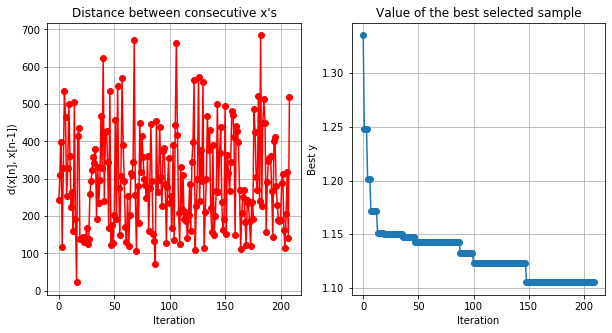

In [109]:
opt_model_emsc.plot_convergence()

In [110]:
opt_model_emsc.x_opt

array([719.,   0.,   2., 137.,  22., 179.])

In [53]:
## re-compute the model with optimized parameters found with the BO 
score_huber2, h2, model_emsc_optimized = evaluate_Bjerrum_model(x_train1_emsc, y_train1_scaled, DenseN=719, DropoutR=0, C1_K=2, C1_S=137, C2_K=22, C2_S=179)


Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
RMSE = 2.3816590388619225, Huber = 1.172286728145514


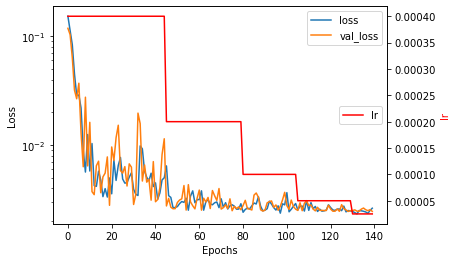

In [56]:
plt.plot(h2.history['loss'], label='loss')
plt.plot(h2.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h2.history['lr'], color='r',label='lr')
ax2.set_ylabel('lr',color='r')

plt.legend(loc=5)
plt.show()

In [54]:
benchmark(x_train1_emsc, y_train1_scaled, x_test2_emsc, y_test2_scaled, model_emsc_optimized)



*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.982	/  0.968
RMSE  	(Train/Test) = 	2.239 	/  2.880
Huber 	(Train/Test) = 	1.117	/  1.655


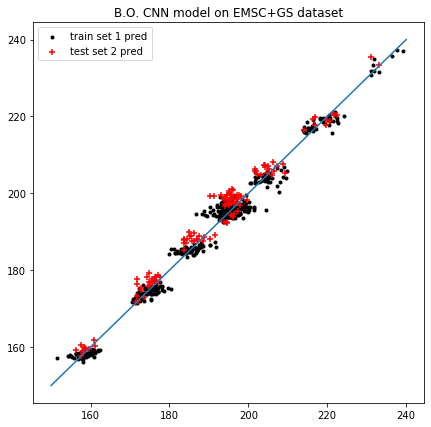

In [57]:
plt.figure(figsize=(7,7))
plt.title('B.O. CNN model on EMSC+GS dataset')
plt.scatter(yscaler.inverse_transform(y_train1_scaled), yscaler.inverse_transform(model_emsc_optimized.predict(x_train1_emsc)),c='k', marker='.',label='train set 1 pred')
plt.scatter(yscaler.inverse_transform(y_test2_scaled), yscaler.inverse_transform(model_emsc_optimized.predict(x_test2_emsc)),c='r', marker='+', label='test set 2 pred')
plt.plot([150,240],[150,240]) # Y = PredY line
plt.legend()
plt.show()

This is the final plot for the optmization process using the BO. 

# EXTRA TESTS
Some extra tests about hyperparameter optimization, layer interpretability, etc...

## Implementing the Tree-structured Parzen Estimator (TPE) optimization section

According to some research literature (e.g. [this MsC thesis](https://www.semanticscholar.org/paper/A-Comparative-Study-of-Black-box-Optimization-for-Olof/1b679138f24bcefb42738f5aea41dee56aa20927)), the TPE hyperparameter optimization method performs better than standand Bayesian Optimization. I've implemented it here but the results are non-conclusive for this dataset. This optimization test is done only for the GS preprocessed dataset.

In [22]:
import optuna
from optuna.samplers import TPESampler

In [24]:
# Again redefine the model proposed by Bjerrum et al 2017 

def Bjerrum_model2(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, input_dim):
    activation='relu'
    model = keras.Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(keras.layers.GaussianNoise(0.01, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(keras.layers.Reshape((input_dim, 1)))
    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='same',activation=activation))
    model.add(keras.layers.Conv1D(C2_K, (C2_S),  padding='same', activation=activation))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DropoutR))
    model.add(keras.layers.Dense(DenseN, activation=activation))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(loss='huber_loss', optimizer=keras.optimizers.Adam(lr=0.0004), metrics=['mean_absolute_error'])
    ## other compile trials
#    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])
#    model.compile(loss='mse', optimizer='adam')#, metrics=['mean_absolute_error'])
#    model.compile(loss='huber_loss', optimizer='adam')#, metrics=['mean_absolute_error'])
    return model


def evaluate_Bjerrum_model2(X, Y, DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S):
    
    ## Use the train dataset this way: 80% train and 20% validation
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)
    
    ## compute the input dimensions for the first layer according to input data
    input_dim = x_train.shape[1]
    
    ## define an initial learning rate
    # lr=0.084
    
    ## generate the model
    model = Bjerrum_model2(DenseN, DropoutR, C1_K, C1_S, C2_K, C2_S, input_dim)
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=4e-5,\
               patience=50, verbose=0, mode='auto', restore_best_weights=True)
    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
#     plot_losses = PlotLossesCallback()
    
    ## fit the train data using x_train (80% of training data) and validate of x_val (20% of training data)
    h=model.fit(x_train,y_train, batch_size=45, validation_data=(x_val, y_val), \
                 callbacks=[monitor, rdlr], verbose=0, epochs=500)
#    h=model.fit(x_train,y_train, batch_size=45, validation_data=(x_val, y_val), \
#                 verbose=0, epochs=200)
#     epochs = monitor.stopped_epoch
        
    ## Make prediction on the validation set and compute final error metrics
    ## In order to better understand the error we must compute it in the original scale of the Y data. Therefore we 
    ## have to rescale the Y data using the yscaler used before.  
      
    y_pred = yscaler.inverse_transform(model.predict(x_val)) # prediction in the right Y scale
    y_true = yscaler.inverse_transform(y_val)                # True Y in the right Y scale
    score_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    score_huber=huber(y_true, y_pred)
    print('RMSE = {}, Huber = {}'.format(score_rmse, score_huber))
#     print('score={}, epochs={}'.format(score, epochs))
    
    ## clear session 
    tf.keras.backend.clear_session()
    
#     return(-score)
    return(score_huber, h, model)


## The parameters of the model are passed in as a trial object that the optuna sampler handles
def evaluate_10_Bjerrum_model2(trial):
    
    ## Use the train dataset this way: 80% train and 20% validation
    X,Y = x_train1_gs, y_train1_scaled
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)
    
    ## compute the input dimensions for the first layer according to input data
    input_dim = x_train.shape[1]
   
    ## Define the model
    activation='relu'
    model = keras.Sequential()
    
    #Adding a bit of GaussianNoise also works as regularization
    model.add(keras.layers.GaussianNoise(0.01, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(keras.layers.Reshape((input_dim, 1)))
    model.add(keras.layers.Conv1D(filters=trial.suggest_int("C1_K",2,64,step=1),\
                                  kernel_size=trial.suggest_int("C1_S",2,256,step=1),\
                                  padding='same',activation=activation))
    model.add(keras.layers.Conv1D(filters=trial.suggest_int("C2_K",2,64,step=1),\
                                  kernel_size=trial.suggest_int("C2_S",2,256,step=1),\
                                  padding='same', activation=activation))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(rate=trial.suggest_uniform("DropoutR",0.,0.5)))
    model.add(keras.layers.Dense(units=trial.suggest_int("DenseN",2,720,step=1),activation=activation))
    model.add(keras.layers.Dense(1, activation='linear'))
              
    model.compile(loss='huber_loss', optimizer=keras.optimizers.Adam(lr=0.0004), metrics=['mean_absolute_error'])
    
    ## define an initial learning rate
    # lr=0.084
       
    monitor = EarlyStopping(monitor='val_loss', min_delta=4e-5,\
               patience=50, verbose=0, mode='auto', restore_best_weights=True)
#    rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)
#     plot_losses = PlotLossesCallback()

    scores_rmse=[]
    scores_huber=[]
    
    # run an experiment

    for r in range(10):    
        ## fit the train data using x_train (80% of training data) and validate of x_val (20% of training data)
        h=model.fit(x_train,y_train, batch_size=45, validation_data=(x_val, y_val), \
                     callbacks=[monitor], verbose=0, epochs=150)
        epochs=monitor.stopped_epoch
       
        ## Make prediction on the validation set and compute final error metrics
        ## In order to better understand the error we must compute it in the original scale of the Y data. Therefore we 
        ## have to rescale the Y data using the yscaler used before.  
      
        y_pred = yscaler.inverse_transform(model.predict(x_val)) # prediction in the right Y scale
        y_true = yscaler.inverse_transform(y_val)                # True Y in the right Y scale
        score_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        score_huber=huber(y_true, y_pred)
#         print('>#%d' % (r+1))
        scores_rmse.append(score_rmse)
        scores_huber.append(score_huber)
#         print('RMSE = {}, Huber = {} over {} epochs' .format(score_rmse, score_huber, epochs))
    
    ## clear session 
    tf.keras.backend.clear_session()
    
#     return(-score)
#     return(score_huber, h, model)
    score_10rmse=np.mean(scores_rmse)
    score_10huber=np.mean(scores_huber)
    print('RMSE (mean of 10 models)= {} \nHuber Loss (mean of 10 models)= {}'.format(score_10rmse, score_10huber))
    return score_10huber


In [25]:
## Run the optuna study, aiming at minimize the output of our model function. Remember that the function 
## evaluate_10_Bjerrum_models2 returns the huber error, which is the thing we want to minimize in this example.
study = optuna.create_study(direction="minimize", sampler=TPESampler())

## perform optimization over 200 trials
study.optimize(evaluate_10_Bjerrum_model2, n_trials=200)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

RMSE (mean of 10 models)= 2.525324963595935 
Huber Loss (mean of 10 models)= 1.2444943013769787


[I 2020-06-26 00:02:32,024] Finished trial#0 with value: 1.2444943013769787 with parameters: {'C1_K': 7, 'C1_S': 161, 'C2_K': 46, 'C2_S': 157, 'DropoutR': 0.24956342183887514, 'DenseN': 389}. Best is trial#0 with value: 1.2444943013769787.


RMSE (mean of 10 models)= 2.709358808747644 
Huber Loss (mean of 10 models)= 1.42041226532865


[I 2020-06-26 00:03:27,497] Finished trial#1 with value: 1.42041226532865 with parameters: {'C1_K': 8, 'C1_S': 22, 'C2_K': 5, 'C2_S': 81, 'DropoutR': 0.47777589257433645, 'DenseN': 86}. Best is trial#0 with value: 1.2444943013769787.


RMSE (mean of 10 models)= 2.5907097932946677 
Huber Loss (mean of 10 models)= 1.3330712850724105


[I 2020-06-26 00:04:24,202] Finished trial#2 with value: 1.3330712850724105 with parameters: {'C1_K': 38, 'C1_S': 222, 'C2_K': 31, 'C2_S': 71, 'DropoutR': 0.27688257937027666, 'DenseN': 477}. Best is trial#0 with value: 1.2444943013769787.


RMSE (mean of 10 models)= 2.467064043851871 
Huber Loss (mean of 10 models)= 1.224375998135009


[I 2020-06-26 00:05:24,975] Finished trial#3 with value: 1.224375998135009 with parameters: {'C1_K': 64, 'C1_S': 252, 'C2_K': 23, 'C2_S': 15, 'DropoutR': 0.4362019932061262, 'DenseN': 622}. Best is trial#3 with value: 1.224375998135009.


RMSE (mean of 10 models)= 2.676071609593941 
Huber Loss (mean of 10 models)= 1.389997561662391


[I 2020-06-26 00:06:51,128] Finished trial#4 with value: 1.389997561662391 with parameters: {'C1_K': 36, 'C1_S': 89, 'C2_K': 47, 'C2_S': 208, 'DropoutR': 0.15029918685058424, 'DenseN': 56}. Best is trial#3 with value: 1.224375998135009.


RMSE (mean of 10 models)= 2.9457658783339395 
Huber Loss (mean of 10 models)= 1.647216565055618


[I 2020-06-26 00:07:54,334] Finished trial#5 with value: 1.647216565055618 with parameters: {'C1_K': 32, 'C1_S': 146, 'C2_K': 16, 'C2_S': 164, 'DropoutR': 0.18644949253998072, 'DenseN': 158}. Best is trial#3 with value: 1.224375998135009.


RMSE (mean of 10 models)= 2.5979345915867116 
Huber Loss (mean of 10 models)= 1.3350412584537696


[I 2020-06-26 00:09:03,515] Finished trial#6 with value: 1.3350412584537696 with parameters: {'C1_K': 47, 'C1_S': 117, 'C2_K': 41, 'C2_S': 65, 'DropoutR': 0.4458435381712994, 'DenseN': 404}. Best is trial#3 with value: 1.224375998135009.


RMSE (mean of 10 models)= 2.725049377448996 
Huber Loss (mean of 10 models)= 1.4561813625423343


[I 2020-06-26 00:10:12,711] Finished trial#7 with value: 1.4561813625423343 with parameters: {'C1_K': 54, 'C1_S': 157, 'C2_K': 44, 'C2_S': 38, 'DropoutR': 0.3652908077177442, 'DenseN': 488}. Best is trial#3 with value: 1.224375998135009.


RMSE (mean of 10 models)= 2.4502321337485222 
Huber Loss (mean of 10 models)= 1.2211725049882403


[I 2020-06-26 00:11:20,762] Finished trial#8 with value: 1.2211725049882403 with parameters: {'C1_K': 10, 'C1_S': 164, 'C2_K': 49, 'C2_S': 69, 'DropoutR': 0.10752586702296196, 'DenseN': 677}. Best is trial#8 with value: 1.2211725049882403.


RMSE (mean of 10 models)= 16.76867234377358 
Huber Loss (mean of 10 models)= 12.074517020557789


[I 2020-06-26 00:11:56,415] Finished trial#9 with value: 12.074517020557789 with parameters: {'C1_K': 28, 'C1_S': 169, 'C2_K': 5, 'C2_S': 225, 'DropoutR': 0.2505047058055909, 'DenseN': 694}. Best is trial#8 with value: 1.2211725049882403.


RMSE (mean of 10 models)= 2.496670609358503 
Huber Loss (mean of 10 models)= 1.2709906863436469


[I 2020-06-26 00:13:06,169] Finished trial#10 with value: 1.2709906863436469 with parameters: {'C1_K': 17, 'C1_S': 61, 'C2_K': 62, 'C2_S': 117, 'DropoutR': 0.08054678913786367, 'DenseN': 235}. Best is trial#8 with value: 1.2211725049882403.


RMSE (mean of 10 models)= 2.541737946967705 
Huber Loss (mean of 10 models)= 1.2983630215497242


[I 2020-06-26 00:14:03,348] Finished trial#11 with value: 1.2983630215497242 with parameters: {'C1_K': 64, 'C1_S': 244, 'C2_K': 24, 'C2_S': 7, 'DropoutR': 0.009006567849135158, 'DenseN': 709}. Best is trial#8 with value: 1.2211725049882403.


RMSE (mean of 10 models)= 2.501520915304522 
Huber Loss (mean of 10 models)= 1.2542344760728716


[I 2020-06-26 00:15:11,711] Finished trial#12 with value: 1.2542344760728716 with parameters: {'C1_K': 19, 'C1_S': 210, 'C2_K': 61, 'C2_S': 16, 'DropoutR': 0.0004488928858366048, 'DenseN': 597}. Best is trial#8 with value: 1.2211725049882403.


RMSE (mean of 10 models)= 2.4307467799058537 
Huber Loss (mean of 10 models)= 1.2017359697534775


[I 2020-06-26 00:16:07,733] Finished trial#13 with value: 1.2017359697534775 with parameters: {'C1_K': 62, 'C1_S': 252, 'C2_K': 20, 'C2_S': 40, 'DropoutR': 0.36952013159637054, 'DenseN': 614}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.4929473267539555 
Huber Loss (mean of 10 models)= 1.2725317763695123


[I 2020-06-26 00:17:24,309] Finished trial#14 with value: 1.2725317763695123 with parameters: {'C1_K': 52, 'C1_S': 201, 'C2_K': 56, 'C2_S': 106, 'DropoutR': 0.3357820721369638, 'DenseN': 570}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.4589354308492295 
Huber Loss (mean of 10 models)= 1.2241836040892196


[I 2020-06-26 00:18:15,676] Finished trial#15 with value: 1.2241836040892196 with parameters: {'C1_K': 3, 'C1_S': 188, 'C2_K': 12, 'C2_S': 44, 'DropoutR': 0.08372151645554399, 'DenseN': 708}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.6164898276664714 
Huber Loss (mean of 10 models)= 1.343055504859683


[I 2020-06-26 00:19:22,420] Finished trial#16 with value: 1.343055504859683 with parameters: {'C1_K': 23, 'C1_S': 122, 'C2_K': 35, 'C2_S': 96, 'DropoutR': 0.36367961944311833, 'DenseN': 266}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.59782166165993 
Huber Loss (mean of 10 models)= 1.3477482139068928


[I 2020-06-26 00:20:33,772] Finished trial#17 with value: 1.3477482139068928 with parameters: {'C1_K': 13, 'C1_S': 5, 'C2_K': 54, 'C2_S': 45, 'DropoutR': 0.15960503008707294, 'DenseN': 520}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.5293118102863748 
Huber Loss (mean of 10 models)= 1.301255553922109


[I 2020-06-26 00:21:44,873] Finished trial#18 with value: 1.301255553922109 with parameters: {'C1_K': 43, 'C1_S': 254, 'C2_K': 31, 'C2_S': 134, 'DropoutR': 0.08022769864254431, 'DenseN': 675}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.6007096866584134 
Huber Loss (mean of 10 models)= 1.3360779932169566


[I 2020-06-26 00:22:42,818] Finished trial#19 with value: 1.3360779932169566 with parameters: {'C1_K': 58, 'C1_S': 87, 'C2_K': 21, 'C2_S': 52, 'DropoutR': 0.32158986420729474, 'DenseN': 633}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.4067834812234414 
Huber Loss (mean of 10 models)= 1.202339464353158


[I 2020-06-26 00:23:39,563] Finished trial#20 with value: 1.202339464353158 with parameters: {'C1_K': 28, 'C1_S': 232, 'C2_K': 36, 'C2_S': 88, 'DropoutR': 0.19798472638072767, 'DenseN': 317}. Best is trial#13 with value: 1.2017359697534775.


RMSE (mean of 10 models)= 2.4391372579505415 
Huber Loss (mean of 10 models)= 1.1915162499811693


[I 2020-06-26 00:24:43,354] Finished trial#21 with value: 1.1915162499811693 with parameters: {'C1_K': 27, 'C1_S': 232, 'C2_K': 35, 'C2_S': 83, 'DropoutR': 0.20392761680610855, 'DenseN': 286}. Best is trial#21 with value: 1.1915162499811693.


RMSE (mean of 10 models)= 2.3715217063944287 
Huber Loss (mean of 10 models)= 1.1701891941080074


[I 2020-06-26 00:25:46,596] Finished trial#22 with value: 1.1701891941080074 with parameters: {'C1_K': 28, 'C1_S': 232, 'C2_K': 38, 'C2_S': 90, 'DropoutR': 0.21827300548667802, 'DenseN': 301}. Best is trial#22 with value: 1.1701891941080074.


RMSE (mean of 10 models)= 2.720138342783943 
Huber Loss (mean of 10 models)= 1.4476405226579407


[I 2020-06-26 00:26:42,960] Finished trial#23 with value: 1.4476405226579407 with parameters: {'C1_K': 25, 'C1_S': 232, 'C2_K': 27, 'C2_S': 132, 'DropoutR': 0.21898738741119553, 'DenseN': 213}. Best is trial#22 with value: 1.1701891941080074.


RMSE (mean of 10 models)= 2.454453264459511 
Huber Loss (mean of 10 models)= 1.2265918027620608


[I 2020-06-26 00:27:44,825] Finished trial#24 with value: 1.2265918027620608 with parameters: {'C1_K': 42, 'C1_S': 190, 'C2_K': 39, 'C2_S': 29, 'DropoutR': 0.2976246690583237, 'DenseN': 317}. Best is trial#22 with value: 1.1701891941080074.


RMSE (mean of 10 models)= 2.671580667529212 
Huber Loss (mean of 10 models)= 1.3881025590171794


[I 2020-06-26 00:28:40,834] Finished trial#25 with value: 1.3881025590171794 with parameters: {'C1_K': 31, 'C1_S': 256, 'C2_K': 17, 'C2_S': 151, 'DropoutR': 0.4126890053451061, 'DenseN': 150}. Best is trial#22 with value: 1.1701891941080074.


RMSE (mean of 10 models)= 2.6353644348810294 
Huber Loss (mean of 10 models)= 1.3481720412651663


[I 2020-06-26 00:29:42,849] Finished trial#26 with value: 1.3481720412651663 with parameters: {'C1_K': 20, 'C1_S': 216, 'C2_K': 29, 'C2_S': 108, 'DropoutR': 0.23731296456044398, 'DenseN': 434}. Best is trial#22 with value: 1.1701891941080074.


RMSE (mean of 10 models)= 16.75885567938142 
Huber Loss (mean of 10 models)= 12.0604296627528


[I 2020-06-26 00:30:27,001] Finished trial#27 with value: 12.0604296627528 with parameters: {'C1_K': 35, 'C1_S': 237, 'C2_K': 38, 'C2_S': 188, 'DropoutR': 0.1507890110414695, 'DenseN': 315}. Best is trial#22 with value: 1.1701891941080074.


RMSE (mean of 10 models)= 2.5233312797528837 
Huber Loss (mean of 10 models)= 1.2978210027933579


[I 2020-06-26 00:31:26,525] Finished trial#28 with value: 1.2978210027933579 with parameters: {'C1_K': 41, 'C1_S': 191, 'C2_K': 33, 'C2_S': 56, 'DropoutR': 0.28703503921170537, 'DenseN': 352}. Best is trial#22 with value: 1.1701891941080074.


RMSE (mean of 10 models)= 2.365491723953816 
Huber Loss (mean of 10 models)= 1.1637977718233103


[I 2020-06-26 00:32:23,033] Finished trial#29 with value: 1.1637977718233103 with parameters: {'C1_K': 15, 'C1_S': 254, 'C2_K': 10, 'C2_S': 92, 'DropoutR': 0.2572142519548324, 'DenseN': 379}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.7855051899141783 
Huber Loss (mean of 10 models)= 1.4821333617277144


[I 2020-06-26 00:33:16,204] Finished trial#30 with value: 1.4821333617277144 with parameters: {'C1_K': 2, 'C1_S': 178, 'C2_K': 42, 'C2_S': 154, 'DropoutR': 0.26022286274450923, 'DenseN': 382}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4398120345705836 
Huber Loss (mean of 10 models)= 1.2192834868408997


[I 2020-06-26 00:34:12,759] Finished trial#31 with value: 1.2192834868408997 with parameters: {'C1_K': 14, 'C1_S': 220, 'C2_K': 13, 'C2_S': 88, 'DropoutR': 0.20553916769475158, 'DenseN': 260}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.5893507725235074 
Huber Loss (mean of 10 models)= 1.32306306592444


[I 2020-06-26 00:35:20,085] Finished trial#32 with value: 1.32306306592444 with parameters: {'C1_K': 24, 'C1_S': 253, 'C2_K': 8, 'C2_S': 119, 'DropoutR': 0.38239783425575435, 'DenseN': 169}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.513186784699531 
Huber Loss (mean of 10 models)= 1.2772811267667734


[I 2020-06-26 00:36:09,806] Finished trial#33 with value: 1.2772811267667734 with parameters: {'C1_K': 6, 'C1_S': 234, 'C2_K': 9, 'C2_S': 79, 'DropoutR': 0.3158227901426151, 'DenseN': 434}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.77487264630089 
Huber Loss (mean of 10 models)= 1.477904716415102


[I 2020-06-26 00:37:05,800] Finished trial#34 with value: 1.477904716415102 with parameters: {'C1_K': 28, 'C1_S': 255, 'C2_K': 2, 'C2_S': 99, 'DropoutR': 0.47580900703569023, 'DenseN': 102}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4015573434511213 
Huber Loss (mean of 10 models)= 1.181409075335409


[I 2020-06-26 00:38:03,923] Finished trial#35 with value: 1.181409075335409 with parameters: {'C1_K': 16, 'C1_S': 203, 'C2_K': 20, 'C2_S': 27, 'DropoutR': 0.17823469765349564, 'DenseN': 354}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.398666394535416 
Huber Loss (mean of 10 models)= 1.1672944595117025


[I 2020-06-26 00:39:00,355] Finished trial#36 with value: 1.1672944595117025 with parameters: {'C1_K': 16, 'C1_S': 203, 'C2_K': 24, 'C2_S': 75, 'DropoutR': 0.1661185915207989, 'DenseN': 284}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4244421167732497 
Huber Loss (mean of 10 models)= 1.2013370323757993


[I 2020-06-26 00:39:48,977] Finished trial#37 with value: 1.2013370323757993 with parameters: {'C1_K': 12, 'C1_S': 143, 'C2_K': 26, 'C2_S': 24, 'DropoutR': 0.12559468425961956, 'DenseN': 359}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.747625949643308 
Huber Loss (mean of 10 models)= 1.4598195939264547


[I 2020-06-26 00:40:41,092] Finished trial#38 with value: 1.4598195939264547 with parameters: {'C1_K': 16, 'C1_S': 197, 'C2_K': 18, 'C2_S': 66, 'DropoutR': 0.17644217958374006, 'DenseN': 205}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.429527719762569 
Huber Loss (mean of 10 models)= 1.2067979840441772


[I 2020-06-26 00:41:27,156] Finished trial#39 with value: 1.2067979840441772 with parameters: {'C1_K': 7, 'C1_S': 209, 'C2_K': 14, 'C2_S': 59, 'DropoutR': 0.12356159940228592, 'DenseN': 421}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4403358977060905 
Huber Loss (mean of 10 models)= 1.2183542304504662


[I 2020-06-26 00:42:31,237] Finished trial#40 with value: 1.2183542304504662 with parameters: {'C1_K': 20, 'C1_S': 177, 'C2_K': 21, 'C2_S': 76, 'DropoutR': 0.23044153104256232, 'DenseN': 345}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4625709161702787 
Huber Loss (mean of 10 models)= 1.2424253213037006


[I 2020-06-26 00:43:25,393] Finished trial#41 with value: 1.2424253213037006 with parameters: {'C1_K': 10, 'C1_S': 226, 'C2_K': 30, 'C2_S': 88, 'DropoutR': 0.18545105091551348, 'DenseN': 274}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.611036589112826 
Huber Loss (mean of 10 models)= 1.3381711609614466


[I 2020-06-26 00:44:26,875] Finished trial#42 with value: 1.3381711609614466 with parameters: {'C1_K': 31, 'C1_S': 208, 'C2_K': 24, 'C2_S': 121, 'DropoutR': 0.26532311305112094, 'DenseN': 296}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.3784806078241716 
Huber Loss (mean of 10 models)= 1.183194857572079


[I 2020-06-26 00:45:26,440] Finished trial#43 with value: 1.183194857572079 with parameters: {'C1_K': 17, 'C1_S': 243, 'C2_K': 47, 'C2_S': 75, 'DropoutR': 0.2119615856942319, 'DenseN': 466}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4951954603407356 
Huber Loss (mean of 10 models)= 1.2392306628263006


[I 2020-06-26 00:46:32,101] Finished trial#44 with value: 1.2392306628263006 with parameters: {'C1_K': 16, 'C1_S': 219, 'C2_K': 53, 'C2_S': 73, 'DropoutR': 0.16317266245681034, 'DenseN': 476}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.3910473666403047 
Huber Loss (mean of 10 models)= 1.1822646881295364


[I 2020-06-26 00:47:45,671] Finished trial#45 with value: 1.1822646881295364 with parameters: {'C1_K': 22, 'C1_S': 243, 'C2_K': 47, 'C2_S': 103, 'DropoutR': 0.2413089473335424, 'DenseN': 390}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.621958999165165 
Huber Loss (mean of 10 models)= 1.3524266317167706


[I 2020-06-26 00:49:05,320] Finished trial#46 with value: 1.3524266317167706 with parameters: {'C1_K': 21, 'C1_S': 145, 'C2_K': 49, 'C2_S': 142, 'DropoutR': 0.24017844678856995, 'DenseN': 403}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4877172806870673 
Huber Loss (mean of 10 models)= 1.2607925832011626


[I 2020-06-26 00:50:08,170] Finished trial#47 with value: 1.2607925832011626 with parameters: {'C1_K': 22, 'C1_S': 242, 'C2_K': 9, 'C2_S': 111, 'DropoutR': 0.03696846666679571, 'DenseN': 380}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4728417440617205 
Huber Loss (mean of 10 models)= 1.2393776158923866


[I 2020-06-26 00:51:19,023] Finished trial#48 with value: 1.2393776158923866 with parameters: {'C1_K': 11, 'C1_S': 204, 'C2_K': 43, 'C2_S': 168, 'DropoutR': 0.13431685541169466, 'DenseN': 513}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.663259511673695 
Huber Loss (mean of 10 models)= 1.400433626644729


[I 2020-06-26 00:52:10,656] Finished trial#49 with value: 1.400433626644729 with parameters: {'C1_K': 5, 'C1_S': 222, 'C2_K': 3, 'C2_S': 7, 'DropoutR': 0.2722328370577551, 'DenseN': 241}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.474147023323364 
Huber Loss (mean of 10 models)= 1.2444043008281744


[I 2020-06-26 00:53:17,290] Finished trial#50 with value: 1.2444043008281744 with parameters: {'C1_K': 18, 'C1_S': 49, 'C2_K': 45, 'C2_S': 99, 'DropoutR': 0.17270395970290298, 'DenseN': 328}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.456554012116639 
Huber Loss (mean of 10 models)= 1.241146001500136


[I 2020-06-26 00:54:17,069] Finished trial#51 with value: 1.241146001500136 with parameters: {'C1_K': 15, 'C1_S': 246, 'C2_K': 50, 'C2_S': 66, 'DropoutR': 0.21563450834523978, 'DenseN': 458}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.5947023171550945 
Huber Loss (mean of 10 models)= 1.3167896417595886


[I 2020-06-26 00:56:18,621] Finished trial#52 with value: 1.3167896417595886 with parameters: {'C1_K': 18, 'C1_S': 245, 'C2_K': 47, 'C2_S': 253, 'DropoutR': 0.24864986526057356, 'DenseN': 385}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.4746531826199787 
Huber Loss (mean of 10 models)= 1.2401972557956031


[I 2020-06-26 00:57:30,703] Finished trial#53 with value: 1.2401972557956031 with parameters: {'C1_K': 25, 'C1_S': 156, 'C2_K': 40, 'C2_S': 100, 'DropoutR': 0.18982648188068454, 'DenseN': 547}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.485315140033657 
Huber Loss (mean of 10 models)= 1.2400502260714052


[I 2020-06-26 00:58:40,539] Finished trial#54 with value: 1.2400502260714052 with parameters: {'C1_K': 9, 'C1_S': 243, 'C2_K': 57, 'C2_S': 123, 'DropoutR': 0.09674529309395072, 'DenseN': 470}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.5529574003025366 
Huber Loss (mean of 10 models)= 1.2930704842261134


[I 2020-06-26 00:59:48,541] Finished trial#55 with value: 1.2930704842261134 with parameters: {'C1_K': 23, 'C1_S': 183, 'C2_K': 51, 'C2_S': 51, 'DropoutR': 0.2940136316442058, 'DenseN': 411}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.587350479878784 
Huber Loss (mean of 10 models)= 1.3222901950106796


[I 2020-06-26 01:00:58,364] Finished trial#56 with value: 1.3222901950106796 with parameters: {'C1_K': 13, 'C1_S': 107, 'C2_K': 45, 'C2_S': 92, 'DropoutR': 0.22526715211123258, 'DenseN': 502}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.5812174718962844 
Huber Loss (mean of 10 models)= 1.3421153086781257


[I 2020-06-26 01:02:04,121] Finished trial#57 with value: 1.3421153086781257 with parameters: {'C1_K': 26, 'C1_S': 199, 'C2_K': 58, 'C2_S': 37, 'DropoutR': 0.14595381248059885, 'DenseN': 449}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.422372947270125 
Huber Loss (mean of 10 models)= 1.209762531363676


[I 2020-06-26 01:03:02,885] Finished trial#58 with value: 1.209762531363676 with parameters: {'C1_K': 17, 'C1_S': 225, 'C2_K': 37, 'C2_S': 109, 'DropoutR': 0.2010167213123701, 'DenseN': 338}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.6081389546213902 
Huber Loss (mean of 10 models)= 1.3653674513314784


[I 2020-06-26 01:04:08,572] Finished trial#59 with value: 1.3653674513314784 with parameters: {'C1_K': 30, 'C1_S': 215, 'C2_K': 47, 'C2_S': 80, 'DropoutR': 0.2544608576284287, 'DenseN': 291}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.500363459023178 
Huber Loss (mean of 10 models)= 1.2569203491087335


[I 2020-06-26 01:05:08,415] Finished trial#60 with value: 1.2569203491087335 with parameters: {'C1_K': 21, 'C1_S': 168, 'C2_K': 33, 'C2_S': 60, 'DropoutR': 0.21527046974772487, 'DenseN': 241}. Best is trial#29 with value: 1.1637977718233103.


RMSE (mean of 10 models)= 2.3531109662617467 
Huber Loss (mean of 10 models)= 1.1471008591491738


[I 2020-06-26 01:06:11,820] Finished trial#61 with value: 1.1471008591491738 with parameters: {'C1_K': 27, 'C1_S': 231, 'C2_K': 34, 'C2_S': 85, 'DropoutR': 0.17361509034953243, 'DenseN': 290}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.444569235346922 
Huber Loss (mean of 10 models)= 1.2439247815893106


[I 2020-06-26 01:07:06,189] Finished trial#62 with value: 1.2439247815893106 with parameters: {'C1_K': 35, 'C1_S': 230, 'C2_K': 28, 'C2_S': 74, 'DropoutR': 0.17372719431094324, 'DenseN': 371}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.400378673163515 
Huber Loss (mean of 10 models)= 1.1751652027976625


[I 2020-06-26 01:08:13,370] Finished trial#63 with value: 1.1751652027976625 with parameters: {'C1_K': 29, 'C1_S': 238, 'C2_K': 24, 'C2_S': 105, 'DropoutR': 0.10787687457022443, 'DenseN': 205}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5244104373814755 
Huber Loss (mean of 10 models)= 1.288821425598806


[I 2020-06-26 01:09:12,911] Finished trial#64 with value: 1.288821425598806 with parameters: {'C1_K': 29, 'C1_S': 238, 'C2_K': 25, 'C2_S': 136, 'DropoutR': 0.05489898299527259, 'DenseN': 175}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4930335923727673 
Huber Loss (mean of 10 models)= 1.2597228405975183


[I 2020-06-26 01:10:07,435] Finished trial#65 with value: 1.2597228405975183 with parameters: {'C1_K': 38, 'C1_S': 256, 'C2_K': 22, 'C2_S': 115, 'DropoutR': 0.10942866099314082, 'DenseN': 204}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4876653721214503 
Huber Loss (mean of 10 models)= 1.2778821885398375


[I 2020-06-26 01:10:58,439] Finished trial#66 with value: 1.2778821885398375 with parameters: {'C1_K': 27, 'C1_S': 212, 'C2_K': 19, 'C2_S': 125, 'DropoutR': 0.1413687291912937, 'DenseN': 305}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4201022785526796 
Huber Loss (mean of 10 models)= 1.1979237086867398


[I 2020-06-26 01:11:52,275] Finished trial#67 with value: 1.1979237086867398 with parameters: {'C1_K': 24, 'C1_S': 248, 'C2_K': 32, 'C2_S': 103, 'DropoutR': 0.15899140676451304, 'DenseN': 115}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.3894605937712345 
Huber Loss (mean of 10 models)= 1.1733492742956892


[I 2020-06-26 01:12:54,426] Finished trial#68 with value: 1.1733492742956892 with parameters: {'C1_K': 20, 'C1_S': 229, 'C2_K': 34, 'C2_S': 92, 'DropoutR': 0.10920445391375558, 'DenseN': 258}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5157374136547923 
Huber Loss (mean of 10 models)= 1.2534898565316348


[I 2020-06-26 01:14:03,454] Finished trial#69 with value: 1.2534898565316348 with parameters: {'C1_K': 32, 'C1_S': 226, 'C2_K': 34, 'C2_S': 84, 'DropoutR': 0.10676551185986474, 'DenseN': 260}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5904860655136517 
Huber Loss (mean of 10 models)= 1.3244621719503804


[I 2020-06-26 01:14:54,519] Finished trial#70 with value: 1.3244621719503804 with parameters: {'C1_K': 34, 'C1_S': 196, 'C2_K': 16, 'C2_S': 20, 'DropoutR': 0.07900286704054749, 'DenseN': 219}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.41818122322453 
Huber Loss (mean of 10 models)= 1.211765963578594


[I 2020-06-26 01:15:42,534] Finished trial#71 with value: 1.211765963578594 with parameters: {'C1_K': 20, 'C1_S': 235, 'C2_K': 29, 'C2_S': 94, 'DropoutR': 0.05235988523490494, 'DenseN': 190}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.548652214089361 
Huber Loss (mean of 10 models)= 1.2982872019354907


[I 2020-06-26 01:16:33,924] Finished trial#72 with value: 1.2982872019354907 with parameters: {'C1_K': 37, 'C1_S': 217, 'C2_K': 31, 'C2_S': 93, 'DropoutR': 0.19220394889123452, 'DenseN': 31}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4665289474942207 
Huber Loss (mean of 10 models)= 1.2453048715878223


[I 2020-06-26 01:17:32,730] Finished trial#73 with value: 1.2453048715878223 with parameters: {'C1_K': 14, 'C1_S': 205, 'C2_K': 36, 'C2_S': 106, 'DropoutR': 0.12603626346029742, 'DenseN': 269}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.39081426756485 
Huber Loss (mean of 10 models)= 1.1772030291969604


[I 2020-06-26 01:18:40,153] Finished trial#74 with value: 1.1772030291969604 with parameters: {'C1_K': 23, 'C1_S': 256, 'C2_K': 41, 'C2_S': 114, 'DropoutR': 0.23966127296439355, 'DenseN': 145}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.519955547684153 
Huber Loss (mean of 10 models)= 1.2693013626534353


[I 2020-06-26 01:19:45,307] Finished trial#75 with value: 1.2693013626534353 with parameters: {'C1_K': 26, 'C1_S': 252, 'C2_K': 39, 'C2_S': 129, 'DropoutR': 0.15880718985213532, 'DenseN': 140}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5085829061762652 
Huber Loss (mean of 10 models)= 1.2840784018464277


[I 2020-06-26 01:20:49,821] Finished trial#76 with value: 1.2840784018464277 with parameters: {'C1_K': 29, 'C1_S': 229, 'C2_K': 42, 'C2_S': 115, 'DropoutR': 0.31093694175619885, 'DenseN': 134}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.478147989461088 
Huber Loss (mean of 10 models)= 1.2463841941816713


[I 2020-06-26 01:21:52,468] Finished trial#77 with value: 1.2463841941816713 with parameters: {'C1_K': 19, 'C1_S': 236, 'C2_K': 27, 'C2_S': 83, 'DropoutR': 0.18353600384616045, 'DenseN': 235}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5670675830875687 
Huber Loss (mean of 10 models)= 1.3014381759357196


[I 2020-06-26 01:22:51,853] Finished trial#78 with value: 1.3014381759357196 with parameters: {'C1_K': 23, 'C1_S': 249, 'C2_K': 23, 'C2_S': 145, 'DropoutR': 0.09343843962619831, 'DenseN': 80}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5077090703132914 
Huber Loss (mean of 10 models)= 1.259385667710783


[I 2020-06-26 01:23:52,747] Finished trial#79 with value: 1.259385667710783 with parameters: {'C1_K': 33, 'C1_S': 256, 'C2_K': 35, 'C2_S': 33, 'DropoutR': 0.11752566233513373, 'DenseN': 327}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.3724799632440647 
Huber Loss (mean of 10 models)= 1.1571085621947752


[I 2020-06-26 01:24:51,452] Finished trial#80 with value: 1.1571085621947752 with parameters: {'C1_K': 12, 'C1_S': 221, 'C2_K': 38, 'C2_S': 88, 'DropoutR': 0.28010688793583516, 'DenseN': 356}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.478285155750096 
Huber Loss (mean of 10 models)= 1.2300937455153633


[I 2020-06-26 01:25:53,080] Finished trial#81 with value: 1.2300937455153633 with parameters: {'C1_K': 15, 'C1_S': 211, 'C2_K': 37, 'C2_S': 88, 'DropoutR': 0.2825224207156603, 'DenseN': 351}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.580515953846378 
Huber Loss (mean of 10 models)= 1.3164057794420332


[I 2020-06-26 01:26:46,162] Finished trial#82 with value: 1.3164057794420332 with parameters: {'C1_K': 11, 'C1_S': 218, 'C2_K': 38, 'C2_S': 113, 'DropoutR': 0.27296732053773287, 'DenseN': 291}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4066217660340454 
Huber Loss (mean of 10 models)= 1.1818207149137359


[I 2020-06-26 01:27:46,877] Finished trial#83 with value: 1.1818207149137359 with parameters: {'C1_K': 13, 'C1_S': 192, 'C2_K': 41, 'C2_S': 68, 'DropoutR': 0.22854471974688678, 'DenseN': 251}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.526192565620213 
Huber Loss (mean of 10 models)= 1.2726344543885761


[I 2020-06-26 01:28:41,745] Finished trial#84 with value: 1.2726344543885761 with parameters: {'C1_K': 9, 'C1_S': 224, 'C2_K': 40, 'C2_S': 94, 'DropoutR': 0.29972062435815233, 'DenseN': 308}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.520944113108215 
Huber Loss (mean of 10 models)= 1.2683419768893462


[I 2020-06-26 01:29:32,587] Finished trial#85 with value: 1.2683419768893462 with parameters: {'C1_K': 18, 'C1_S': 234, 'C2_K': 7, 'C2_S': 48, 'DropoutR': 0.24724223146542812, 'DenseN': 275}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.437335413843351 
Huber Loss (mean of 10 models)= 1.2072754557096619


[I 2020-06-26 01:30:16,934] Finished trial#86 with value: 1.2072754557096619 with parameters: {'C1_K': 16, 'C1_S': 240, 'C2_K': 14, 'C2_S': 60, 'DropoutR': 0.2618553018718268, 'DenseN': 222}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5231316034324527 
Huber Loss (mean of 10 models)= 1.2974880016215435


[I 2020-06-26 01:31:08,223] Finished trial#87 with value: 1.2974880016215435 with parameters: {'C1_K': 21, 'C1_S': 205, 'C2_K': 31, 'C2_S': 2, 'DropoutR': 0.20356420303920078, 'DenseN': 186}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5475485818127384 
Huber Loss (mean of 10 models)= 1.3072285323699595


[I 2020-06-26 01:32:06,786] Finished trial#88 with value: 1.3072285323699595 with parameters: {'C1_K': 25, 'C1_S': 183, 'C2_K': 12, 'C2_S': 78, 'DropoutR': 0.1343664573535149, 'DenseN': 364}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4562041086768605 
Huber Loss (mean of 10 models)= 1.2410156865240216


[I 2020-06-26 01:33:04,050] Finished trial#89 with value: 1.2410156865240216 with parameters: {'C1_K': 27, 'C1_S': 230, 'C2_K': 33, 'C2_S': 105, 'DropoutR': 0.329306631918708, 'DenseN': 335}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4816730589944616 
Huber Loss (mean of 10 models)= 1.2294499914119619


[I 2020-06-26 01:33:56,188] Finished trial#90 with value: 1.2294499914119619 with parameters: {'C1_K': 4, 'C1_S': 221, 'C2_K': 26, 'C2_S': 88, 'DropoutR': 0.1678823200307245, 'DenseN': 317}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.544316884512479 
Huber Loss (mean of 10 models)= 1.296722723108958


[I 2020-06-26 01:34:45,461] Finished trial#91 with value: 1.296722723108958 with parameters: {'C1_K': 14, 'C1_S': 191, 'C2_K': 41, 'C2_S': 66, 'DropoutR': 0.2318010079752996, 'DenseN': 254}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.6639142250715397 
Huber Loss (mean of 10 models)= 1.3758108097999702


[I 2020-06-26 01:35:43,791] Finished trial#92 with value: 1.3758108097999702 with parameters: {'C1_K': 8, 'C1_S': 196, 'C2_K': 43, 'C2_S': 70, 'DropoutR': 0.22407777940584253, 'DenseN': 286}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4498741355253637 
Huber Loss (mean of 10 models)= 1.2390383861719227


[I 2020-06-26 01:36:43,924] Finished trial#93 with value: 1.2390383861719227 with parameters: {'C1_K': 12, 'C1_S': 214, 'C2_K': 35, 'C2_S': 98, 'DropoutR': 0.23504917731226047, 'DenseN': 159}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.5386882735984204 
Huber Loss (mean of 10 models)= 1.2965673510546711


[I 2020-06-26 01:37:51,982] Finished trial#94 with value: 1.2965673510546711 with parameters: {'C1_K': 19, 'C1_S': 203, 'C2_K': 37, 'C2_S': 83, 'DropoutR': 0.351287940233482, 'DenseN': 398}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.607386930160392 
Huber Loss (mean of 10 models)= 1.3433182338207925


[I 2020-06-26 01:38:51,513] Finished trial#95 with value: 1.3433182338207925 with parameters: {'C1_K': 13, 'C1_S': 175, 'C2_K': 39, 'C2_S': 42, 'DropoutR': 0.18370390572987702, 'DenseN': 247}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4392021066725436 
Huber Loss (mean of 10 models)= 1.2027492355771265


[I 2020-06-26 01:39:50,799] Finished trial#96 with value: 1.2027492355771265 with parameters: {'C1_K': 22, 'C1_S': 248, 'C2_K': 42, 'C2_S': 71, 'DropoutR': 0.20883923830227902, 'DenseN': 198}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4862345580865357 
Huber Loss (mean of 10 models)= 1.2439557767928262


[I 2020-06-26 01:40:40,928] Finished trial#97 with value: 1.2439557767928262 with parameters: {'C1_K': 11, 'C1_S': 185, 'C2_K': 29, 'C2_S': 54, 'DropoutR': 0.15321452015043827, 'DenseN': 228}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.447227027262268 
Huber Loss (mean of 10 models)= 1.2167569593653922


[I 2020-06-26 01:41:41,849] Finished trial#98 with value: 1.2167569593653922 with parameters: {'C1_K': 15, 'C1_S': 238, 'C2_K': 20, 'C2_S': 120, 'DropoutR': 0.27667716081364424, 'DenseN': 302}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.399528698951428 
Huber Loss (mean of 10 models)= 1.1986329944227907


[I 2020-06-26 01:42:45,308] Finished trial#99 with value: 1.1986329944227907 with parameters: {'C1_K': 17, 'C1_S': 226, 'C2_K': 44, 'C2_S': 109, 'DropoutR': 0.06591785828911631, 'DenseN': 371}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4885480835280314 
Huber Loss (mean of 10 models)= 1.2623216333736558


[I 2020-06-26 01:43:48,676] Finished trial#100 with value: 1.2623216333736558 with parameters: {'C1_K': 30, 'C1_S': 211, 'C2_K': 40, 'C2_S': 90, 'DropoutR': 0.1947694715546207, 'DenseN': 324}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.43068929116499 
Huber Loss (mean of 10 models)= 1.1854095484077916


[I 2020-06-26 01:44:59,915] Finished trial#101 with value: 1.1854095484077916 with parameters: {'C1_K': 24, 'C1_S': 242, 'C2_K': 46, 'C2_S': 102, 'DropoutR': 0.24339366557067002, 'DenseN': 392}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.435820733911996 
Huber Loss (mean of 10 models)= 1.2081792969803387


[I 2020-06-26 01:46:10,852] Finished trial#102 with value: 1.2081792969803387 with parameters: {'C1_K': 22, 'C1_S': 252, 'C2_K': 34, 'C2_S': 100, 'DropoutR': 0.22298562347652615, 'DenseN': 424}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.7885139861587183 
Huber Loss (mean of 10 models)= 1.450841622629579


[I 2020-06-26 01:47:10,129] Finished trial#103 with value: 1.450841622629579 with parameters: {'C1_K': 26, 'C1_S': 222, 'C2_K': 38, 'C2_S': 96, 'DropoutR': 0.26390717697813804, 'DenseN': 349}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4379961478554955 
Huber Loss (mean of 10 models)= 1.204259096557993


[I 2020-06-26 01:48:16,906] Finished trial#104 with value: 1.204259096557993 with parameters: {'C1_K': 18, 'C1_S': 233, 'C2_K': 23, 'C2_S': 76, 'DropoutR': 0.25604796015694303, 'DenseN': 264}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.4203518915153643 
Huber Loss (mean of 10 models)= 1.182986277879002


[I 2020-06-26 01:49:12,016] Finished trial#105 with value: 1.182986277879002 with parameters: {'C1_K': 20, 'C1_S': 246, 'C2_K': 16, 'C2_S': 81, 'DropoutR': 0.2155526905142499, 'DenseN': 284}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.6938187992382074 
Huber Loss (mean of 10 models)= 1.4400603691805522


[I 2020-06-26 01:50:17,004] Finished trial#106 with value: 1.4400603691805522 with parameters: {'C1_K': 28, 'C1_S': 240, 'C2_K': 36, 'C2_S': 86, 'DropoutR': 0.23747245128162978, 'DenseN': 382}. Best is trial#61 with value: 1.1471008591491738.


RMSE (mean of 10 models)= 2.3350617021567404 
Huber Loss (mean of 10 models)= 1.1205828721874167


[I 2020-06-26 01:51:14,659] Finished trial#107 with value: 1.1205828721874167 with parameters: {'C1_K': 12, 'C1_S': 229, 'C2_K': 32, 'C2_S': 111, 'DropoutR': 0.02048171969277754, 'DenseN': 339}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4494300458849247 
Huber Loss (mean of 10 models)= 1.2488512108537166


[I 2020-06-26 01:52:01,814] Finished trial#108 with value: 1.2488512108537166 with parameters: {'C1_K': 12, 'C1_S': 230, 'C2_K': 32, 'C2_S': 125, 'DropoutR': 0.019135758902226734, 'DenseN': 342}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4797938498078933 
Huber Loss (mean of 10 models)= 1.2531881738509967


[I 2020-06-26 01:52:46,597] Finished trial#109 with value: 1.2531881738509967 with parameters: {'C1_K': 9, 'C1_S': 200, 'C2_K': 18, 'C2_S': 62, 'DropoutR': 0.009520281610481837, 'DenseN': 361}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.546526555893222 
Huber Loss (mean of 10 models)= 1.3166087059888791


[I 2020-06-26 01:53:48,382] Finished trial#110 with value: 1.3166087059888791 with parameters: {'C1_K': 16, 'C1_S': 133, 'C2_K': 30, 'C2_S': 116, 'DropoutR': 0.036395182661099826, 'DenseN': 274}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4150107534998098 
Huber Loss (mean of 10 models)= 1.2088894243185953


[I 2020-06-26 01:54:53,289] Finished trial#111 with value: 1.2088894243185953 with parameters: {'C1_K': 13, 'C1_S': 217, 'C2_K': 41, 'C2_S': 105, 'DropoutR': 0.24385834950506502, 'DenseN': 307}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4807335234962937 
Huber Loss (mean of 10 models)= 1.2454904191335276


[I 2020-06-26 01:55:40,995] Finished trial#112 with value: 1.2454904191335276 with parameters: {'C1_K': 6, 'C1_S': 228, 'C2_K': 27, 'C2_S': 112, 'DropoutR': 0.17687357492979022, 'DenseN': 332}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.6346658639607274 
Huber Loss (mean of 10 models)= 1.355330304476258


[I 2020-06-26 01:56:50,665] Finished trial#113 with value: 1.355330304476258 with parameters: {'C1_K': 14, 'C1_S': 208, 'C2_K': 48, 'C2_S': 92, 'DropoutR': 0.28979357263580735, 'DenseN': 413}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.50932393607346 
Huber Loss (mean of 10 models)= 1.263479279410777


[I 2020-06-26 01:57:55,477] Finished trial#114 with value: 1.263479279410777 with parameters: {'C1_K': 10, 'C1_S': 249, 'C2_K': 36, 'C2_S': 134, 'DropoutR': 0.19693831736769746, 'DenseN': 443}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5751571539155633 
Huber Loss (mean of 10 models)= 1.3149849315332005


[I 2020-06-26 01:58:53,318] Finished trial#115 with value: 1.3149849315332005 with parameters: {'C1_K': 22, 'C1_S': 237, 'C2_K': 34, 'C2_S': 101, 'DropoutR': 0.2700501629306766, 'DenseN': 250}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.3882363048391597 
Huber Loss (mean of 10 models)= 1.1876545727856171


[I 2020-06-26 01:59:59,120] Finished trial#116 with value: 1.1876545727856171 with parameters: {'C1_K': 31, 'C1_S': 256, 'C2_K': 44, 'C2_S': 96, 'DropoutR': 0.25189676365431507, 'DenseN': 208}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5906221899912594 
Huber Loss (mean of 10 models)= 1.349452422350814


[I 2020-06-26 02:01:11,812] Finished trial#117 with value: 1.349452422350814 with parameters: {'C1_K': 19, 'C1_S': 222, 'C2_K': 52, 'C2_S': 109, 'DropoutR': 0.13830735324711874, 'DenseN': 369}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5351197651911668 
Huber Loss (mean of 10 models)= 1.2573290004703943


[I 2020-06-26 02:02:11,557] Finished trial#118 with value: 1.2573290004703943 with parameters: {'C1_K': 24, 'C1_S': 244, 'C2_K': 25, 'C2_S': 85, 'DropoutR': 0.3008944201150049, 'DenseN': 174}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4364272452601456 
Huber Loss (mean of 10 models)= 1.2206493388984225


[I 2020-06-26 02:03:09,575] Finished trial#119 with value: 1.2206493388984225 with parameters: {'C1_K': 15, 'C1_S': 194, 'C2_K': 10, 'C2_S': 128, 'DropoutR': 0.2077716657985418, 'DenseN': 319}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.7177861194520974 
Huber Loss (mean of 10 models)= 1.4482984870902458


[I 2020-06-26 02:04:00,328] Finished trial#120 with value: 1.4482984870902458 with parameters: {'C1_K': 27, 'C1_S': 215, 'C2_K': 4, 'C2_S': 68, 'DropoutR': 0.22829484069478123, 'DenseN': 117}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.621091499587587 
Huber Loss (mean of 10 models)= 1.3765385452335894


[I 2020-06-26 02:05:04,589] Finished trial#121 with value: 1.3765385452335894 with parameters: {'C1_K': 21, 'C1_S': 246, 'C2_K': 17, 'C2_S': 77, 'DropoutR': 0.21737075963713326, 'DenseN': 288}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4625340664506523 
Huber Loss (mean of 10 models)= 1.2300819856565024


[I 2020-06-26 02:06:00,244] Finished trial#122 with value: 1.2300819856565024 with parameters: {'C1_K': 19, 'C1_S': 233, 'C2_K': 21, 'C2_S': 82, 'DropoutR': 0.18424855664346496, 'DenseN': 283}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.415606885982888 
Huber Loss (mean of 10 models)= 1.2004728552855248


[I 2020-06-26 02:06:57,788] Finished trial#123 with value: 1.2004728552855248 with parameters: {'C1_K': 17, 'C1_S': 256, 'C2_K': 15, 'C2_S': 91, 'DropoutR': 0.17094879260335497, 'DenseN': 301}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4311564390515543 
Huber Loss (mean of 10 models)= 1.2250072728920507


[I 2020-06-26 02:07:51,476] Finished trial#124 with value: 1.2250072728920507 with parameters: {'C1_K': 20, 'C1_S': 242, 'C2_K': 19, 'C2_S': 78, 'DropoutR': 0.21632242151560077, 'DenseN': 351}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4546417382092933 
Huber Loss (mean of 10 models)= 1.2105320458024


[I 2020-06-26 02:08:51,269] Finished trial#125 with value: 1.2105320458024 with parameters: {'C1_K': 23, 'C1_S': 226, 'C2_K': 39, 'C2_S': 72, 'DropoutR': 0.2507037935100859, 'DenseN': 229}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4014717896204623 
Huber Loss (mean of 10 models)= 1.1857063832199382


[I 2020-06-26 02:09:48,015] Finished trial#126 with value: 1.1857063832199382 with parameters: {'C1_K': 29, 'C1_S': 237, 'C2_K': 24, 'C2_S': 106, 'DropoutR': 0.23393196680782857, 'DenseN': 270}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.451819175480745 
Huber Loss (mean of 10 models)= 1.2249617542852094


[I 2020-06-26 02:10:52,304] Finished trial#127 with value: 1.2249617542852094 with parameters: {'C1_K': 25, 'C1_S': 252, 'C2_K': 22, 'C2_S': 97, 'DropoutR': 0.09146386616131737, 'DenseN': 253}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 3.9400035535393854 
Huber Loss (mean of 10 models)= 2.352408888970759


[I 2020-06-26 02:11:41,816] Finished trial#128 with value: 2.352408888970759 with parameters: {'C1_K': 17, 'C1_S': 220, 'C2_K': 10, 'C2_S': 119, 'DropoutR': 0.20043475841499103, 'DenseN': 404}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4295122174403883 
Huber Loss (mean of 10 models)= 1.2234929113817807


[I 2020-06-26 02:12:43,624] Finished trial#129 with value: 1.2234929113817807 with parameters: {'C1_K': 12, 'C1_S': 247, 'C2_K': 37, 'C2_S': 82, 'DropoutR': 0.2788771239621597, 'DenseN': 331}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4394940854175173 
Huber Loss (mean of 10 models)= 1.1971107665893113


[I 2020-06-26 02:13:35,775] Finished trial#130 with value: 1.1971107665893113 with parameters: {'C1_K': 20, 'C1_S': 230, 'C2_K': 12, 'C2_S': 90, 'DropoutR': 0.1528660773887877, 'DenseN': 309}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.474735729926004 
Huber Loss (mean of 10 models)= 1.2411723813086273


[I 2020-06-26 02:14:42,300] Finished trial#131 with value: 1.2411723813086273 with parameters: {'C1_K': 16, 'C1_S': 242, 'C2_K': 49, 'C2_S': 64, 'DropoutR': 0.2110723562705229, 'DenseN': 487}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.426827462511135 
Huber Loss (mean of 10 models)= 1.2147305590204587


[I 2020-06-26 02:15:37,490] Finished trial#132 with value: 1.2147305590204587 with parameters: {'C1_K': 14, 'C1_S': 235, 'C2_K': 45, 'C2_S': 72, 'DropoutR': 0.22526593483556162, 'DenseN': 292}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.401947402594207 
Huber Loss (mean of 10 models)= 1.1765169820176045


[I 2020-06-26 02:16:35,799] Finished trial#133 with value: 1.1765169820176045 with parameters: {'C1_K': 18, 'C1_S': 250, 'C2_K': 46, 'C2_S': 80, 'DropoutR': 0.18974510616634352, 'DenseN': 377}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4704966461165254 
Huber Loss (mean of 10 models)= 1.2436334775334819


[I 2020-06-26 02:17:38,702] Finished trial#134 with value: 1.2436334775334819 with parameters: {'C1_K': 18, 'C1_S': 252, 'C2_K': 32, 'C2_S': 86, 'DropoutR': 0.18894933029827143, 'DenseN': 376}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.478941900386515 
Huber Loss (mean of 10 models)= 1.242980223420985


[I 2020-06-26 02:18:37,154] Finished trial#135 with value: 1.242980223420985 with parameters: {'C1_K': 10, 'C1_S': 256, 'C2_K': 41, 'C2_S': 102, 'DropoutR': 0.16415179043598715, 'DenseN': 344}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5477788660043212 
Huber Loss (mean of 10 models)= 1.2948725529352585


[I 2020-06-26 02:19:35,735] Finished trial#136 with value: 1.2948725529352585 with parameters: {'C1_K': 23, 'C1_S': 95, 'C2_K': 42, 'C2_S': 11, 'DropoutR': 0.25846473577557577, 'DenseN': 388}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.429687311226348 
Huber Loss (mean of 10 models)= 1.201373717679453


[I 2020-06-26 02:20:23,211] Finished trial#137 with value: 1.201373717679453 with parameters: {'C1_K': 15, 'C1_S': 209, 'C2_K': 16, 'C2_S': 96, 'DropoutR': 0.11086016528602008, 'DenseN': 365}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5239807637968066 
Huber Loss (mean of 10 models)= 1.2679066429519064


[I 2020-06-26 02:21:23,050] Finished trial#138 with value: 1.2679066429519064 with parameters: {'C1_K': 21, 'C1_S': 159, 'C2_K': 43, 'C2_S': 114, 'DropoutR': 0.17794020729890928, 'DenseN': 428}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.501944086718294 
Huber Loss (mean of 10 models)= 1.2586895181354747


[I 2020-06-26 02:22:09,861] Finished trial#139 with value: 1.2586895181354747 with parameters: {'C1_K': 20, 'C1_S': 240, 'C2_K': 7, 'C2_S': 80, 'DropoutR': 0.07164918651919222, 'DenseN': 237}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4731134060864615 
Huber Loss (mean of 10 models)= 1.246683761565306


[I 2020-06-26 02:23:16,238] Finished trial#140 with value: 1.246683761565306 with parameters: {'C1_K': 32, 'C1_S': 225, 'C2_K': 38, 'C2_S': 90, 'DropoutR': 0.20205629674212058, 'DenseN': 67}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.382706130909281 
Huber Loss (mean of 10 models)= 1.1790062242060988


[I 2020-06-26 02:24:14,630] Finished trial#141 with value: 1.1790062242060988 with parameters: {'C1_K': 16, 'C1_S': 249, 'C2_K': 47, 'C2_S': 74, 'DropoutR': 0.21727786844447752, 'DenseN': 526}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5305915331267137 
Huber Loss (mean of 10 models)= 1.2789864654148562


[I 2020-06-26 02:25:26,256] Finished trial#142 with value: 1.2789864654148562 with parameters: {'C1_K': 17, 'C1_S': 248, 'C2_K': 47, 'C2_S': 76, 'DropoutR': 0.2410187708666474, 'DenseN': 632}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.494881748842579 
Huber Loss (mean of 10 models)= 1.2383573026783752


[I 2020-06-26 02:26:36,299] Finished trial#143 with value: 1.2383573026783752 with parameters: {'C1_K': 13, 'C1_S': 232, 'C2_K': 44, 'C2_S': 57, 'DropoutR': 0.22348688827586893, 'DenseN': 656}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.6753155186281212 
Huber Loss (mean of 10 models)= 1.4123637322577713


[I 2020-06-26 02:27:35,267] Finished trial#144 with value: 1.4123637322577713 with parameters: {'C1_K': 15, 'C1_S': 245, 'C2_K': 50, 'C2_S': 68, 'DropoutR': 0.19058355643284353, 'DenseN': 536}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.771472057780035 
Huber Loss (mean of 10 models)= 1.508849150475648


[I 2020-06-26 02:28:34,990] Finished trial#145 with value: 1.508849150475648 with parameters: {'C1_K': 11, 'C1_S': 237, 'C2_K': 45, 'C2_S': 81, 'DropoutR': 0.21173977067299904, 'DenseN': 275}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4592030664712485 
Huber Loss (mean of 10 models)= 1.2360300921117646


[I 2020-06-26 02:29:41,836] Finished trial#146 with value: 1.2360300921117646 with parameters: {'C1_K': 19, 'C1_S': 249, 'C2_K': 46, 'C2_S': 87, 'DropoutR': 0.23861843099204197, 'DenseN': 263}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.6627057020665674 
Huber Loss (mean of 10 models)= 1.401030494002999


[I 2020-06-26 02:30:51,538] Finished trial#147 with value: 1.401030494002999 with parameters: {'C1_K': 26, 'C1_S': 256, 'C2_K': 48, 'C2_S': 105, 'DropoutR': 0.19694535240879352, 'DenseN': 318}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5384986143199058 
Huber Loss (mean of 10 models)= 1.2856917550453522


[I 2020-06-26 02:31:54,496] Finished trial#148 with value: 1.2856917550453522 with parameters: {'C1_K': 18, 'C1_S': 218, 'C2_K': 35, 'C2_S': 99, 'DropoutR': 0.2692150314540044, 'DenseN': 339}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.527639831548221 
Huber Loss (mean of 10 models)= 1.292528775620595


[I 2020-06-26 02:32:52,754] Finished trial#149 with value: 1.292528775620595 with parameters: {'C1_K': 16, 'C1_S': 227, 'C2_K': 54, 'C2_S': 27, 'DropoutR': 0.14722381506724824, 'DenseN': 358}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.516335432132117 
Huber Loss (mean of 10 models)= 1.2629186048571097


[I 2020-06-26 02:33:44,792] Finished trial#150 with value: 1.2629186048571097 with parameters: {'C1_K': 8, 'C1_S': 201, 'C2_K': 20, 'C2_S': 111, 'DropoutR': 0.22104482817977703, 'DenseN': 610}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.355155054223853 
Huber Loss (mean of 10 models)= 1.141493638324199


[I 2020-06-26 02:34:58,169] Finished trial#151 with value: 1.141493638324199 with parameters: {'C1_K': 13, 'C1_S': 242, 'C2_K': 51, 'C2_S': 93, 'DropoutR': 0.2091189465142374, 'DenseN': 501}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.7346836741925045 
Huber Loss (mean of 10 models)= 1.448434632010012


[I 2020-06-26 02:36:06,238] Finished trial#152 with value: 1.448434632010012 with parameters: {'C1_K': 13, 'C1_S': 241, 'C2_K': 54, 'C2_S': 93, 'DropoutR': 0.2102760691725329, 'DenseN': 524}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.765996994603472 
Huber Loss (mean of 10 models)= 1.4672417695217632


[I 2020-06-26 02:37:22,632] Finished trial#153 with value: 1.4672417695217632 with parameters: {'C1_K': 12, 'C1_S': 65, 'C2_K': 51, 'C2_S': 85, 'DropoutR': 0.16692534486385985, 'DenseN': 541}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.693705311730222 
Huber Loss (mean of 10 models)= 1.4312343097945746


[I 2020-06-26 02:38:43,840] Finished trial#154 with value: 1.4312343097945746 with parameters: {'C1_K': 14, 'C1_S': 251, 'C2_K': 48, 'C2_S': 73, 'DropoutR': 0.22784784812245037, 'DenseN': 562}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4211540822422073 
Huber Loss (mean of 10 models)= 1.1933160501666742


[I 2020-06-26 02:39:43,928] Finished trial#155 with value: 1.1933160501666742 with parameters: {'C1_K': 16, 'C1_S': 235, 'C2_K': 40, 'C2_S': 93, 'DropoutR': 0.2534756845062518, 'DenseN': 292}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4710479401933982 
Huber Loss (mean of 10 models)= 1.2444487796775305


[I 2020-06-26 02:40:49,370] Finished trial#156 with value: 1.2444487796775305 with parameters: {'C1_K': 22, 'C1_S': 246, 'C2_K': 34, 'C2_S': 79, 'DropoutR': 0.18499846125265781, 'DenseN': 397}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4542392082721665 
Huber Loss (mean of 10 models)= 1.230780331484937


[I 2020-06-26 02:41:59,585] Finished trial#157 with value: 1.230780331484937 with parameters: {'C1_K': 24, 'C1_S': 231, 'C2_K': 50, 'C2_S': 102, 'DropoutR': 0.203673873206436, 'DenseN': 574}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.3656025441491364 
Huber Loss (mean of 10 models)= 1.1835867981665076


[I 2020-06-26 02:43:01,254] Finished trial#158 with value: 1.1835867981665076 with parameters: {'C1_K': 11, 'C1_S': 256, 'C2_K': 56, 'C2_S': 97, 'DropoutR': 0.24399465373779275, 'DenseN': 213}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.423092151588443 
Huber Loss (mean of 10 models)= 1.190995794160664


[I 2020-06-26 02:44:07,024] Finished trial#159 with value: 1.190995794160664 with parameters: {'C1_K': 30, 'C1_S': 238, 'C2_K': 28, 'C2_S': 108, 'DropoutR': 0.23230113588801635, 'DenseN': 495}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5047704482201847 
Huber Loss (mean of 10 models)= 1.252095590043953


[I 2020-06-26 02:45:16,652] Finished trial#160 with value: 1.252095590043953 with parameters: {'C1_K': 18, 'C1_S': 213, 'C2_K': 39, 'C2_S': 88, 'DropoutR': 0.044350602358111016, 'DenseN': 322}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.497195961819887 
Huber Loss (mean of 10 models)= 1.2687477702159


[I 2020-06-26 02:46:19,395] Finished trial#161 with value: 1.2687477702159 with parameters: {'C1_K': 17, 'C1_S': 243, 'C2_K': 46, 'C2_S': 73, 'DropoutR': 0.21562057592916267, 'DenseN': 305}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5193576115775644 
Huber Loss (mean of 10 models)= 1.2888592509772896


[I 2020-06-26 02:47:21,332] Finished trial#162 with value: 1.2888592509772896 with parameters: {'C1_K': 20, 'C1_S': 224, 'C2_K': 47, 'C2_S': 84, 'DropoutR': 0.1959808595463278, 'DenseN': 464}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4674004320783913 
Huber Loss (mean of 10 models)= 1.2369940968283761


[I 2020-06-26 02:48:31,561] Finished trial#163 with value: 1.2369940968283761 with parameters: {'C1_K': 14, 'C1_S': 243, 'C2_K': 49, 'C2_S': 68, 'DropoutR': 0.17709462039108242, 'DenseN': 477}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5202435975974185 
Huber Loss (mean of 10 models)= 1.2781084941982501


[I 2020-06-26 02:49:44,426] Finished trial#164 with value: 1.2781084941982501 with parameters: {'C1_K': 19, 'C1_S': 250, 'C2_K': 51, 'C2_S': 64, 'DropoutR': 0.20857122456453472, 'DenseN': 506}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4194027106795657 
Huber Loss (mean of 10 models)= 1.2069196509867055


[I 2020-06-26 02:50:50,085] Finished trial#165 with value: 1.2069196509867055 with parameters: {'C1_K': 28, 'C1_S': 232, 'C2_K': 30, 'C2_S': 50, 'DropoutR': 0.23334972228300413, 'DenseN': 528}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4393527178864858 
Huber Loss (mean of 10 models)= 1.213175477097057


[I 2020-06-26 02:52:00,223] Finished trial#166 with value: 1.213175477097057 with parameters: {'C1_K': 15, 'C1_S': 239, 'C2_K': 43, 'C2_S': 79, 'DropoutR': 0.26365465179742464, 'DenseN': 443}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.6045563728438332 
Huber Loss (mean of 10 models)= 1.3419684364671292


[I 2020-06-26 02:52:54,829] Finished trial#167 with value: 1.3419684364671292 with parameters: {'C1_K': 13, 'C1_S': 256, 'C2_K': 18, 'C2_S': 93, 'DropoutR': 0.22412239978072435, 'DenseN': 516}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.515995465401631 
Huber Loss (mean of 10 models)= 1.2719940891752164


[I 2020-06-26 02:54:01,322] Finished trial#168 with value: 1.2719940891752164 with parameters: {'C1_K': 16, 'C1_S': 221, 'C2_K': 52, 'C2_S': 74, 'DropoutR': 0.13134953008670303, 'DenseN': 415}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4125196843543333 
Huber Loss (mean of 10 models)= 1.2076784616295284


[I 2020-06-26 02:55:07,247] Finished trial#169 with value: 1.2076784616295284 with parameters: {'C1_K': 21, 'C1_S': 228, 'C2_K': 37, 'C2_S': 88, 'DropoutR': 0.1927346772746406, 'DenseN': 381}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.469097934692878 
Huber Loss (mean of 10 models)= 1.2277090169306342


[I 2020-06-26 02:56:09,770] Finished trial#170 with value: 1.2277090169306342 with parameters: {'C1_K': 18, 'C1_S': 247, 'C2_K': 25, 'C2_S': 121, 'DropoutR': 0.16184967523184066, 'DenseN': 277}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4910695315066573 
Huber Loss (mean of 10 models)= 1.2361122632765962


[I 2020-06-26 02:57:08,174] Finished trial#171 with value: 1.2361122632765962 with parameters: {'C1_K': 11, 'C1_S': 255, 'C2_K': 23, 'C2_S': 96, 'DropoutR': 0.24605653178758263, 'DenseN': 211}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.434220350744992 
Huber Loss (mean of 10 models)= 1.2204774115101773


[I 2020-06-26 02:58:05,909] Finished trial#172 with value: 1.2204774115101773 with parameters: {'C1_K': 9, 'C1_S': 252, 'C2_K': 58, 'C2_S': 100, 'DropoutR': 0.2513955513035264, 'DenseN': 243}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.664898381493194 
Huber Loss (mean of 10 models)= 1.4108007677455858


[I 2020-06-26 02:59:07,566] Finished trial#173 with value: 1.4108007677455858 with parameters: {'C1_K': 12, 'C1_S': 235, 'C2_K': 61, 'C2_S': 84, 'DropoutR': 0.21724134025609979, 'DenseN': 147}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.6172308831824336 
Huber Loss (mean of 10 models)= 1.351363603019082


[I 2020-06-26 03:00:05,916] Finished trial#174 with value: 1.351363603019082 with parameters: {'C1_K': 10, 'C1_S': 189, 'C2_K': 58, 'C2_S': 106, 'DropoutR': 0.22931692301618584, 'DenseN': 186}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.590700517165879 
Huber Loss (mean of 10 models)= 1.3404411211893246


[I 2020-06-26 03:00:55,474] Finished trial#175 with value: 1.3404411211893246 with parameters: {'C1_K': 15, 'C1_S': 244, 'C2_K': 41, 'C2_S': 98, 'DropoutR': 0.24521718261282707, 'DenseN': 164}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.379192446587946 
Huber Loss (mean of 10 models)= 1.1513249654151425


[I 2020-06-26 03:02:05,624] Finished trial#176 with value: 1.1513249654151425 with parameters: {'C1_K': 13, 'C1_S': 239, 'C2_K': 55, 'C2_S': 92, 'DropoutR': 0.20182079443045495, 'DenseN': 354}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4871835720003834 
Huber Loss (mean of 10 models)= 1.2715904974775065


[I 2020-06-26 03:03:01,319] Finished trial#177 with value: 1.2715904974775065 with parameters: {'C1_K': 13, 'C1_S': 238, 'C2_K': 46, 'C2_S': 81, 'DropoutR': 0.1808114453502412, 'DenseN': 351}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.6319350920572426 
Huber Loss (mean of 10 models)= 1.3393853287935964


[I 2020-06-26 03:04:28,775] Finished trial#178 with value: 1.3393853287935964 with parameters: {'C1_K': 49, 'C1_S': 231, 'C2_K': 53, 'C2_S': 91, 'DropoutR': 0.20095535159040287, 'DenseN': 365}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4560431197056545 
Huber Loss (mean of 10 models)= 1.2456564705122959


[I 2020-06-26 03:05:33,349] Finished trial#179 with value: 1.2456564705122959 with parameters: {'C1_K': 16, 'C1_S': 241, 'C2_K': 32, 'C2_S': 116, 'DropoutR': 0.2825746885294761, 'DenseN': 333}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.644856982570723 
Huber Loss (mean of 10 models)= 1.376638215998216


[I 2020-06-26 03:06:41,790] Finished trial#180 with value: 1.376638215998216 with parameters: {'C1_K': 25, 'C1_S': 206, 'C2_K': 44, 'C2_S': 79, 'DropoutR': 0.2063394356822924, 'DenseN': 552}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4703292505206647 
Huber Loss (mean of 10 models)= 1.2481256827251124


[I 2020-06-26 03:07:48,532] Finished trial#181 with value: 1.2481256827251124 with parameters: {'C1_K': 11, 'C1_S': 246, 'C2_K': 59, 'C2_S': 96, 'DropoutR': 0.2357062050874911, 'DenseN': 258}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.423662770349055 
Huber Loss (mean of 10 models)= 1.2143406805632864


[I 2020-06-26 03:08:51,831] Finished trial#182 with value: 1.2143406805632864 with parameters: {'C1_K': 14, 'C1_S': 256, 'C2_K': 56, 'C2_S': 89, 'DropoutR': 0.21571259794804457, 'DenseN': 391}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5330442283139347 
Huber Loss (mean of 10 models)= 1.264365496922376


[I 2020-06-26 03:09:47,464] Finished trial#183 with value: 1.264365496922376 with parameters: {'C1_K': 12, 'C1_S': 250, 'C2_K': 56, 'C2_S': 101, 'DropoutR': 0.26087327172851227, 'DenseN': 231}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.483039466195078 
Huber Loss (mean of 10 models)= 1.2507817405397479


[I 2020-06-26 03:10:46,817] Finished trial#184 with value: 1.2507817405397479 with parameters: {'C1_K': 17, 'C1_S': 233, 'C2_K': 13, 'C2_S': 112, 'DropoutR': 0.0010748474737571553, 'DenseN': 295}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4813742159181813 
Huber Loss (mean of 10 models)= 1.2503909199036307


[I 2020-06-26 03:11:42,335] Finished trial#185 with value: 1.2503909199036307 with parameters: {'C1_K': 14, 'C1_S': 240, 'C2_K': 55, 'C2_S': 76, 'DropoutR': 0.24036742753800952, 'DenseN': 220}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.453877184293934 
Huber Loss (mean of 10 models)= 1.2082638193776283


[I 2020-06-26 03:12:35,065] Finished trial#186 with value: 1.2082638193776283 with parameters: {'C1_K': 17, 'C1_S': 228, 'C2_K': 53, 'C2_S': 86, 'DropoutR': 0.19251611643814553, 'DenseN': 125}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.520227514865428 
Huber Loss (mean of 10 models)= 1.2861897903277821


[I 2020-06-26 03:13:26,141] Finished trial#187 with value: 1.2861897903277821 with parameters: {'C1_K': 21, 'C1_S': 256, 'C2_K': 39, 'C2_S': 94, 'DropoutR': 0.21722725558060896, 'DenseN': 94}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.368717076511227 
Huber Loss (mean of 10 models)= 1.1505533955539133


[I 2020-06-26 03:14:25,071] Finished trial#188 with value: 1.1505533955539133 with parameters: {'C1_K': 19, 'C1_S': 248, 'C2_K': 35, 'C2_S': 105, 'DropoutR': 0.16901869842814485, 'DenseN': 194}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.4044456566016854 
Huber Loss (mean of 10 models)= 1.1608724165851134


[I 2020-06-26 03:15:50,988] Finished trial#189 with value: 1.1608724165851134 with parameters: {'C1_K': 19, 'C1_S': 245, 'C2_K': 36, 'C2_S': 228, 'DropoutR': 0.17162088659616806, 'DenseN': 376}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.3923896823569626 
Huber Loss (mean of 10 models)= 1.187451871365311


[I 2020-06-26 03:17:04,364] Finished trial#190 with value: 1.187451871365311 with parameters: {'C1_K': 23, 'C1_S': 247, 'C2_K': 35, 'C2_S': 200, 'DropoutR': 0.1581510953939981, 'DenseN': 373}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5584723086902317 
Huber Loss (mean of 10 models)= 1.2983089770790204


[I 2020-06-26 03:18:20,334] Finished trial#191 with value: 1.2983089770790204 with parameters: {'C1_K': 18, 'C1_S': 243, 'C2_K': 36, 'C2_S': 174, 'DropoutR': 0.18094039232497805, 'DenseN': 355}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.349959358011387 
Huber Loss (mean of 10 models)= 1.1789458536654014


[I 2020-06-26 03:19:43,638] Finished trial#192 with value: 1.1789458536654014 with parameters: {'C1_K': 20, 'C1_S': 236, 'C2_K': 35, 'C2_S': 226, 'DropoutR': 0.16909868909395925, 'DenseN': 406}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.527957663966177 
Huber Loss (mean of 10 models)= 1.2824614181019973


[I 2020-06-26 03:21:01,438] Finished trial#193 with value: 1.2824614181019973 with parameters: {'C1_K': 20, 'C1_S': 236, 'C2_K': 37, 'C2_S': 212, 'DropoutR': 0.15251407968833974, 'DenseN': 386}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5618386384452436 
Huber Loss (mean of 10 models)= 1.274334634216635


[I 2020-06-26 03:22:06,579] Finished trial#194 with value: 1.274334634216635 with parameters: {'C1_K': 19, 'C1_S': 224, 'C2_K': 33, 'C2_S': 107, 'DropoutR': 0.1693787942215446, 'DenseN': 373}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.516338740502908 
Huber Loss (mean of 10 models)= 1.2580204700552258


[I 2020-06-26 03:23:41,524] Finished trial#195 with value: 1.2580204700552258 with parameters: {'C1_K': 21, 'C1_S': 238, 'C2_K': 34, 'C2_S': 238, 'DropoutR': 0.16901199629256286, 'DenseN': 399}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.5993851926076896 
Huber Loss (mean of 10 models)= 1.3394260218835792


[I 2020-06-26 03:24:42,881] Finished trial#196 with value: 1.3394260218835792 with parameters: {'C1_K': 22, 'C1_S': 250, 'C2_K': 38, 'C2_S': 104, 'DropoutR': 0.17726276298370056, 'DenseN': 412}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.515910484355902 
Huber Loss (mean of 10 models)= 1.292894784708484


[I 2020-06-26 03:26:05,669] Finished trial#197 with value: 1.292894784708484 with parameters: {'C1_K': 20, 'C1_S': 231, 'C2_K': 36, 'C2_S': 222, 'DropoutR': 0.13894859299323134, 'DenseN': 351}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.3718360147034705 
Huber Loss (mean of 10 models)= 1.1756418130679083


[I 2020-06-26 03:27:41,773] Finished trial#198 with value: 1.1756418130679083 with parameters: {'C1_K': 19, 'C1_S': 218, 'C2_K': 34, 'C2_S': 238, 'DropoutR': 0.14950270819487313, 'DenseN': 314}. Best is trial#107 with value: 1.1205828721874167.


RMSE (mean of 10 models)= 2.436190529578827 
Huber Loss (mean of 10 models)= 1.217800487409659


[I 2020-06-26 03:29:05,868] Finished trial#199 with value: 1.217800487409659 with parameters: {'C1_K': 19, 'C1_S': 214, 'C2_K': 36, 'C2_S': 241, 'DropoutR': 0.14677643068178664, 'DenseN': 334}. Best is trial#107 with value: 1.1205828721874167.


Number of finished trials: 200
Best trial:
  Value: 1.1205828721874167
  Params: 
    C1_K: 12
    C1_S: 229
    C2_K: 32
    C2_S: 111
    DropoutR: 0.02048171969277754
    DenseN: 339


In [36]:
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 1.1205828721874167
  Params: 
    C1_K: 12
    C1_S: 229
    C2_K: 32
    C2_S: 111
    DropoutR: 0.02048171969277754
    DenseN: 339


In [58]:
## re-compute the model with optimized parameters found with the TPE
score_huber3, h3, model_gs_optimized3 = evaluate_Bjerrum_model2(x_train1_gs, y_train1_scaled, DenseN=339, DropoutR=0.02048171969277754, C1_K=12, C1_S=229, C2_K=32, C2_S=111)


Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.

Epoch 00104: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
RMSE = 2.469769569971648, Huber = 1.2477263904808993


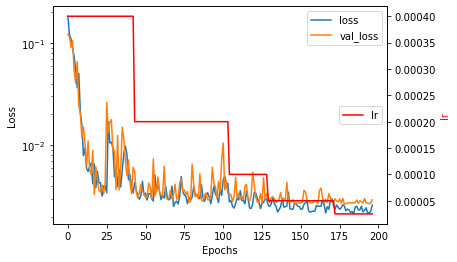

In [59]:
plt.plot(h3.history['loss'], label='loss')
plt.plot(h3.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h3.history['lr'], color='r',label='lr')
ax2.set_ylabel('lr',color='r')

plt.legend(loc=5)
plt.show()

In [60]:
benchmark(x_train1_gs, y_train1_scaled, x_test2_gs, y_test2_scaled, model_gs_optimized2)



*********** Benchmark results *********** 

R2  	(Train/Test) = 	0.982	/  0.965
RMSE  	(Train/Test) = 	2.262 	/  3.015
Huber 	(Train/Test) = 	1.131	/  1.756


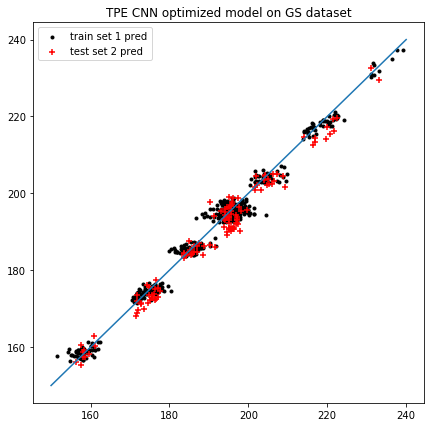

In [65]:
plt.figure(figsize=(7,7))
plt.title('TPE CNN optimized model on GS dataset')
plt.scatter(yscaler.inverse_transform(y_train1_scaled), yscaler.inverse_transform(model_gs_optimized2.predict(x_train1_gs)),c='k', marker='.',label='train set 1 pred')
plt.scatter(yscaler.inverse_transform(y_test2_scaled), yscaler.inverse_transform(model_gs_optimized2.predict(x_test2_gs)),c='r', marker='+', label='test set 2 pred')
plt.plot([150,240],[150,240]) # Y = PredY line
plt.legend()
plt.show()

The TPE optimization example presented here seems to do a bit better than the Bayesian optimization for the GS dataset. 
However the results are very close and given the variability of the output of the model (per singular run), nothing can be said.

The 10CV mean favours the TPE by a very slim margin:
 - The optimized BO for 10CV huber loss for the GS data is:  1.1615340778383885 <br>
 - The optimized TPE for 10CV huber loss for the GS data is:  1.1205828721874167

**TODO later:** <br>
- Review the code and look for bugs
- Redo Bayesian optimization using other package, e.g. bayes_opt
- Check the difference of using padding = 'valid' or 'same' in the Conv1d layers.
- Interpret the large size of the filters in the context of the padding used and the spectral resolution of the data...

## Further tests about the interpretability of the intermediate layers of the CNN

In [79]:
## re-compute one of the models with some chosen hyperparameters
_,_, model_x = evaluate_Bjerrum_model(x_train1_gs, y_train1_scaled, DenseN=339, DropoutR=0.02048171969277754, C1_K=12, C1_S=229, C2_K=32, C2_S=111)


Epoch 00090: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.

Epoch 00145: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
RMSE = 2.3858523077623435, Huber = 1.206732387564261


**Example of how to save and retrieve a trained model.**<br> Example of code here (commented)!

In [70]:
### Save the model and the history as pickle file
# name = "model_Bjrrum2017_gs"
# model_x.save("%s.h5"%name)
# hist = h.history
# import pickle
# pickle.dump(hist, file("%s_history.pickle"%name,"w"))

In [20]:
### Load model
# from tensorflow.keras.models import load_model
# name = "model_Bjrrum2017_gs"
# model_x = load_model("%s.h5"%name)

### Testing Playground

In [80]:
print(model_x.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 600)               0         
_________________________________________________________________
reshape (Reshape)            (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 12)           2760      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 32)           42656     
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 19200)             0         
_________________________________________________________________
dense (Dense)                (None, 339)               6

In [68]:
print('\nNumber of test samples: {}'.format(len(x_test2_gs)))


Number of test samples: 128


In [81]:
## Check for a couple of examples of the filters learned weights
# filtros=model_x.get_weights()
# print(np.asarray(filtros).shape)
# print(filtros[0].shape)
# print()
# plt.plot(filtros[0][:,0])

Visualize the activations/outputs of the intermediate layers of the CNN
adatapted from<br> https://stackoverflow.com/questions/54195973/how-to-most-effectively-visualize-1d-convolutions

In [87]:
from tensorflow.keras import models

# get the first 3 layers from the trained model (the input layer doesnt count!)
layers_outputs = [layer.output for layer in model_x.layers[:3]]

# define a sub-model based on the selected layers
activation_model = models.Model(inputs=model_x.input, outputs=layers_outputs)

# compute the activations as the output of that sub-model. Here we feed x_test2_emsc data to that submodel
activations = activation_model.predict(x_test2_emsc)

# The last element of the "activations" var correspond to the outputs of 
# conv1d layer and has dimensions (Nsamples, SampleSize-FilterSize+1, Nfilters)

# activations for the first conv1d layer
conv1d_activations = activations[2]

print(conv1d_activations.shape)
print(activation_model.summary())

(128, 600, 12)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_input (InputL [(None, 600)]             0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 600)               0         
_________________________________________________________________
reshape (Reshape)            (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 12)           2760      
Total params: 2,760
Trainable params: 2,760
Non-trainable params: 0
_________________________________________________________________
None


In [165]:
# print(np.argmax(np.mean(conv1d_activations[:,:,1],axis=0)))

## Compute the mean of the activations used on the test samples
# activations=np.mean(conv1d_activations,axis=0)
# print(mean_activations.shape)

## Sort mean activations by max
# mean_activations_sorted = np.sort(conv1d_activations, axis=1)[:,::-1,:]
# plt.plot(mean_activations_sorted[:,:,0])
# plt.show()

In [32]:
# np.argmax(mean_activations_sorted[0,:])

In [166]:
# for filt_number in range(10):
#     plt.figure(figsize=(8,2))
#     ax=plt.subplot()
#     extent=[min(l), max(l),-1.5,1.5]
# #     ax.imshow(conv1d_activations[0, : , filt_number][np.newaxis,:], cmap="RdBu", aspect="auto", extent=extent)
#     ax.imshow(np.abs(mean_activations_sorted[ : , filt_number][np.newaxis,:]), cmap="Blues", aspect="auto", extent=extent)
# #     ax.imshow(np.abs(conv1d_activations[0, : , filt_number][np.newaxis,:]), cmap="Blues", aspect="auto", extent=extent)
#     ax.plot(l, np.mean(x_test2_emsc, axis=0),'k')
#     ax.plot(l, mean_activations_sorted[ :, filt_number], 'r--')

In order to check what kind of pre-processing is being done in the convolutional layers, we can plot the activations/output of those layer (red dashed lines and blue shading) overlayed on a mean-spectrum of the input data. This works because in our Conv1d layers we defined padding='same' that ensures that the dimension of the data after the filters convolution is the same as the input data. This allow for us to see what kind of spectral features (peaks, rising phases, depressions, flats, etc.) is detected (has higher activations) by the filters in the CNN. The impact of choosing padding 'same' in the CNN seem to decrease the model performance based on some tests I did, but it requires more testing to form a solid oppinion on this. Take this info with a grain of salt!

Also the activation plotted is the one obtained for a specific input sample. There are multiple test samples... I'm still not sure how to best choose the samples for the visualizations or if they resemble all, etc. Hence the "testing playground section".


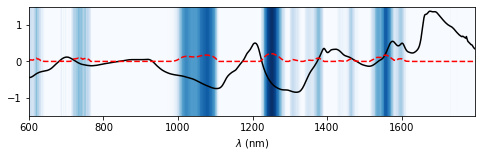

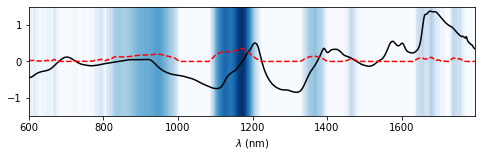

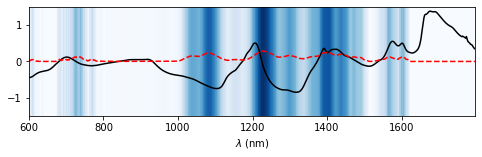

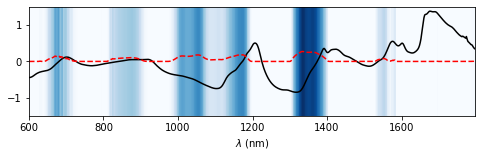

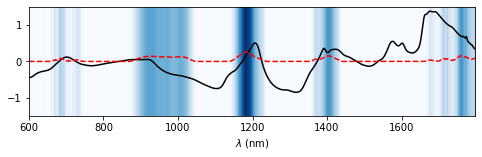

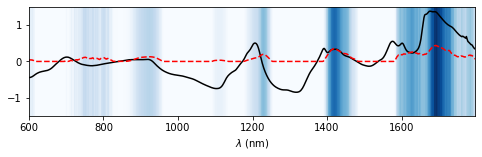

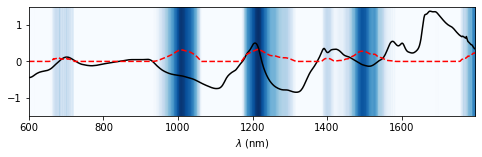

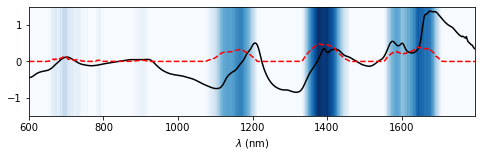

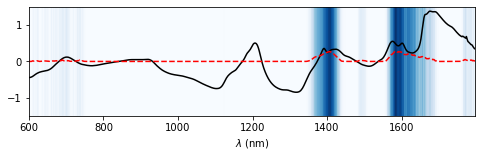

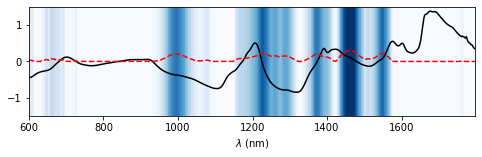

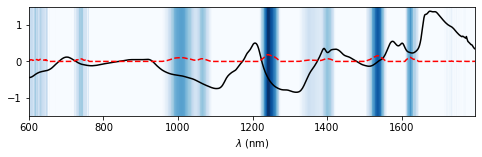

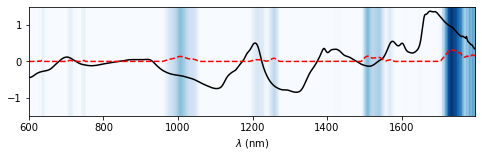

In [91]:
## Plot the mean  output (over all samples) of the several filters (here 12 in the 1st conv1d layer)
for filt_number in range(12):
    plt.figure(figsize=(8,2))
    ax=plt.subplot()
    extent=[min(l), max(l),-1.5,1.5]
#     ax.imshow(conv1d_activations[0, : , filt_number][np.newaxis,:], cmap="RdBu", aspect="auto", extent=extent)
    ax.imshow(np.abs(np.mean(conv1d_activations[:, : , filt_number],axis=0)[np.newaxis,:]), cmap="Blues", aspect="auto", extent=extent)
    ax.plot(l, np.mean(x_test2_emsc, axis=0),'k')
    ax.plot(l, np.mean(conv1d_activations[: , :, filt_number],axis=0), 'r--')
    plt.xlabel(r'$\lambda$ (nm)')

Have fun!